# <font color='#238278'>Machine Learning Project Notebook</font>

# <font color='#238278'>Contents</font> <a class="anchor" id="toc"></a>
* [Data Exploration](#explore)
* [Visual EDA](#visualeda)
* [Data Preprocessing](#preproc)
  * [Duplicate Information](#duplicate)
  * [Missing Values](#missing)
  * [Feature Engineering](#engineering)
  * [Transforming Categorical Variables](#cat2num)
  * [Final Preparations for Modelling](#finalprep)
* [Binary Classification](#binclass)
  * [Oversampling](#oversamplebin)
  * [Feature Selection](#selectionbin)
  * [Best Model Selection](#modelbin)
  * [Final Model](#finalbin)
* [Multiclass Classification](#multiclass)
  * [Oversampling](#oversamplemulti)
  * [Feature Selection](#selectionmulti)
  * [Best Model Selection](#modelmulti)
  * [Final Model](#finalmulti)

# <font color='#238278'>Data Exploration</font> <a class="anchor" id="explore"></a>
[Back to Contents](#toc)

Before anything, we should import all the needed packages to perform the following operations in this Notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from imblearn.over_sampling import SMOTE, SVMSMOTE
from scipy.stats import uniform, randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.linear_model import LassoCV, SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from openpyxl import load_workbook

In [2]:
# This will allow us to see all the columns in the dataset
pd.set_option("display.max_columns", 60)

As usual, we begin by loading our training sample and displaying the first five rows to get an overview of our data.

In [3]:
train = pd.read_csv('train.csv', delimiter = ",")
test = pd.read_csv('test.csv', delimiter = ",")

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (71236, 31)
Test set shape: (30530, 29)


In [4]:
train.head()

encounter_id country  patient_id             race  gender      age weight  \
0        533253     USA       70110        Caucasian  Female  [70-80)      ?   
1        426224     USA    29775006  AfricanAmerican    Male  [50-60)      ?   
2        634063     USA    80729253        Caucasian  Female  [60-70)      ?   
3        890610     USA     2919042  AfricanAmerican    Male  [60-70)      ?   
4        654194     USA    84871971        Caucasian  Female  [70-80)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0          ?                                   0   
1          ?                                   0   
2          ?                                   0   
3         MC                                   0   
4         HM                                   1   

   emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
0                                  0                                  2   
1                                  0                                  0   
2                                  0                                  1   
3                                  0                                  1   
4                                  0                                  0   

  admission_type       medical_specialty  average_pulse_bpm  \
0      Emergency  Family/GeneralPractice                127   
1      Emergency                       ?                128   
2            NaN  Family/GeneralPractice                 94   
3      Emergency        InternalMedicine                 81   
4       Elective                       ?                126   

                               discharge_disposition  \
0                                 Discharged to home   
1  Discharged/transferred to a federal health car...   
2                                 Discharged to home   
3                                 Discharged to home   
4  Discharged/transferred to home with home healt...   

                              admission_source  length_of_stay_in_hospital  \
0                               Emergency Room                           2   
1                              Clinic Referral                          14   
2                                          NaN                           6   
3   Transfer from another health care facility                           6   
4                           Physician Referral                           6   

   number_lab_tests  non_lab_procedures  number_of_medications  \
0                48                   0                     20   
1                71                   0                     25   
2                60                   1                     22   
3                48                   2                      9   
4                47                   1                     15   

  primary_diagnosis secondary_diagnosis additional_diagnosis  \
0               515                 276                  466   
1                38                 785                  162   
2               534                 135                  250   
3               569                 562                  455   
4               715                 599                  428   

   number_diagnoses glucose_test_result a1c_test_result  \
0                 8                 NaN             NaN   
1                 9                 NaN             NaN   
2                 6                 NaN             NaN   
3                 5                 NaN             NaN   
4                 9                 NaN             NaN   

  change_in_meds_during_hospitalization prescribed_diabetes_meds  \
0                                    No                       No   
1                                    No                      Yes   
2                                    Ch                      Yes   
3                                    No                       No   
4                                    No                       No   

                   medicati

Let's split our train dataset into one dedicated to training (70%), and other that we will use for validation (30%). For now, we will keep both target features together, but we will later separate them as well.

In [5]:
X = train.drop(columns = {"readmitted_binary", "readmitted_multiclass"})
y = train[["readmitted_binary",'readmitted_multiclass']]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.7, stratify = y, shuffle = True, random_state = 2023)

Now, we should start by creating a copy of our training dataset, which we will use in the initial data exploration stage.

In [7]:
train_copy = X_train.copy()

Let's make some initial analysis on the number of missing values and entries on each variable.

In [8]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49865 entries, 51995 to 41052
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           49865 non-null  int64 
 1   country                                49865 non-null  object
 2   patient_id                             49865 non-null  int64 
 3   race                                   47348 non-null  object
 4   gender                                 49865 non-null  object
 5   age                                    47391 non-null  object
 6   weight                                 49865 non-null  object
 7   payer_code                             49865 non-null  object
 8   outpatient_visits_in_previous_year     49865 non-null  int64 
 9   emergency_visits_in_previous_year      49865 non-null  int64 
 10  inpatient_visits_in_previous_year      49865 non-null  int64 
 11  admission_t

In [9]:
na_cols = train_copy.columns[train_copy.isna().any()].tolist()

# Missing values summary.

missing_values = pd.DataFrame(train_copy[na_cols].isna().sum(), columns = ["Number of missing values"])
missing_values["Percentage of missing values"] = round(missing_values["Number of missing values"] / len(train_copy) * 100, 2)
missing_values

Number of missing values  Percentage of missing values
race                                       2517                          5.05
age                                        2474                          4.96
admission_type                             2580                          5.17
discharge_disposition                      1787                          3.58
admission_source                           3241                          6.50
glucose_test_result                       47294                         94.84
a1c_test_result                           41488                         83.20

In [10]:
train_copy['glucose_test_result'].value_counts(dropna=False)

NaN     47294
Norm     1253
>200      744
>300      574
Name: glucose_test_result, dtype: int64

In [11]:
train_copy['a1c_test_result'].value_counts(dropna=False)

NaN     41488
>8       4037
Norm     2435
>7       1905
Name: a1c_test_result, dtype: int64

In [12]:
train_copy['race'].value_counts(dropna=False)

Caucasian          35571
AfricanAmerican     8791
NaN                 2517
?                   1068
Hispanic             942
Other                693
Asian                283
Name: race, dtype: int64

In [13]:
len(train_copy["patient_id"].unique())

40298

In [14]:
len(train_copy["encounter_id"].unique())

49865

And for this reason, 'encounter_id' should be our Index. We should also do the same for the test dataset.

In [15]:
X_train.set_index('encounter_id', inplace = True)
X_val.set_index('encounter_id', inplace = True)
test.set_index('encounter_id', inplace = True)

train.head()

encounter_id country  patient_id             race  gender      age weight  \
0        533253     USA       70110        Caucasian  Female  [70-80)      ?   
1        426224     USA    29775006  AfricanAmerican    Male  [50-60)      ?   
2        634063     USA    80729253        Caucasian  Female  [60-70)      ?   
3        890610     USA     2919042  AfricanAmerican    Male  [60-70)      ?   
4        654194     USA    84871971        Caucasian  Female  [70-80)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0          ?                                   0   
1          ?                                   0   
2          ?                                   0   
3         MC                                   0   
4         HM                                   1   

   emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
0                                  0                                  2   
1                                  0                                  0   
2                                  0                                  1   
3                                  0                                  1   
4                                  0                                  0   

  admission_type       medical_specialty  average_pulse_bpm  \
0      Emergency  Family/GeneralPractice                127   
1      Emergency                       ?                128   
2            NaN  Family/GeneralPractice                 94   
3      Emergency        InternalMedicine                 81   
4       Elective                       ?                126   

                               discharge_disposition  \
0                                 Discharged to home   
1  Discharged/transferred to a federal health car...   
2                                 Discharged to home   
3                                 Discharged to home   
4  Discharged/transferred to home with home healt...   

                              admission_source  length_of_stay_in_hospital  \
0                               Emergency Room                           2   
1                              Clinic Referral                          14   
2                                          NaN                           6   
3   Transfer from another health care facility                           6   
4                           Physician Referral                           6   

   number_lab_tests  non_lab_procedures  number_of_medications  \
0                48                   0                     20   
1                71                   0                     25   
2                60                   1                     22   
3                48                   2                      9   
4                47                   1                     15   

  primary_diagnosis secondary_diagnosis additional_diagnosis  \
0               515                 276                  466   
1                38                 785                  162   
2               534                 135                  250   
3               569                 562                  455   
4               715                 599                  428   

   number_diagnoses glucose_test_result a1c_test_result  \
0                 8                 NaN             NaN   
1                 9                 NaN             NaN   
2                 6                 NaN             NaN   
3                 5                 NaN             NaN   
4                 9                 NaN             NaN   

  change_in_meds_during_hospitalization prescribed_diabetes_meds  \
0                                    No                       No   
1                                    No                      Yes   
2                                    Ch                      Yes   
3                                    No                       No   
4                                    No                       No   

                   medicati

In [16]:
train_copy.set_index('encounter_id', inplace = True)

In [17]:
train_copy['country'].value_counts()

USA    49865
Name: country, dtype: int64

In [18]:
train_copy['gender'].unique()

array(['Male', 'Female', 'Unknown/Invalid'], dtype=object)

In [19]:
len(train_copy[train_copy['gender']== 'Unknown/Invalid'])

2

Let's now check in further detail this lines.

In [20]:
train_copy[train_copy['gender']=='Unknown/Invalid']

country  patient_id race           gender      age weight  \
encounter_id                                                             
978787           USA    60524946    ?  Unknown/Invalid  [60-70)      ?   
208080           USA    78119847    ?  Unknown/Invalid  [70-80)      ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
978787               CP                                   0   
208080               CP                                   0   

              emergency_visits_in_previous_year  \
encounter_id                                      
978787                                        0   
208080                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
978787                                        0      Emergency   
208080                                        0      Emergency   

             medical_specialty  average_pulse_bpm  \
encounter_id                                        
978787                       ?                 87   
208080                       ?                111   

                                          discharge_disposition  \
encounter_id                                                      
978787                                       Discharged to home   
208080        Discharged/transferred to another rehab fac in...   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
978787         Emergency Room                           1                38   
208080         Emergency Room                           8                59   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
978787                         1                      6               808   
208080                         2                     21               850   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
978787                       873                 E813                 5   
208080                       805                  808                 9   

             glucose_test_result a1c_test_result  \
encounter_id                                       
978787                       NaN             NaN   
208080                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
978787                                          No                       No   
208080                                          Ch                      Yes   

                                  medication  
encounter_id                                  
978787                                    []  
208080        ['metformin', 'rosiglitazone']

At last, let's just ensure that these patient id's only appear once or, on contrary, if they appear more than once with a different gender.

In [21]:
train_copy[train_copy['patient_id']==60524946]

country  patient_id race           gender      age weight  \
encounter_id                                                             
978787           USA    60524946    ?  Unknown/Invalid  [60-70)      ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
978787               CP                                   0   

              emergency_visits_in_previous_year  \
encounter_id                                      
978787                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
978787                                        0      Emergency   

             medical_specialty  average_pulse_bpm discharge_disposition  \
encounter_id                                                              
978787                       ?                 87    Discharged to home   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
978787         Emergency Room                           1                38   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
978787                         1                      6               808   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
978787                       873                 E813                 5   

             glucose_test_result a1c_test_result  \
encounter_id                                       
978787                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
978787                                          No                       No   

             medication  
encounter_id             
978787               []

In [22]:
train_copy[train_copy['patient_id']==78119847]

country  patient_id race           gender      age weight  \
encounter_id                                                             
208080           USA    78119847    ?  Unknown/Invalid  [70-80)      ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
208080               CP                                   0   

              emergency_visits_in_previous_year  \
encounter_id                                      
208080                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
208080                                        0      Emergency   

             medical_specialty  average_pulse_bpm  \
encounter_id                                        
208080                       ?                111   

                                          discharge_disposition  \
encounter_id                                                      
208080        Discharged/transferred to another rehab fac in...   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
208080         Emergency Room                           8                59   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
208080                         2                     21               850   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
208080                       805                  808                 9   

             glucose_test_result a1c_test_result  \
encounter_id                                       
208080                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
208080                                          Ch                      Yes   

                                  medication  
encounter_id                                  
208080        ['metformin', 'rosiglitazone']

In [23]:
train_copy['age'].value_counts(dropna=False)

[70-80)     12159
[60-70)     10455
[80-90)      8083
[50-60)      7979
[40-50)      4501
NaN          2474
[30-40)      1762
[90-100)     1318
[20-30)       733
[10-20)       331
[0-10)         70
Name: age, dtype: int64

In [24]:
train_copy['weight'].value_counts(dropna=False)

?            48311
[75-100)       641
[50-75)        431
[100-125)      314
[125-150)       69
[25-50)         49
[0-25)          29
[150-175)       14
[175-200)        6
>200             1
Name: weight, dtype: int64

In [25]:
train_copy[train_copy['weight']== '>200']

country  patient_id       race  gender      age weight  \
encounter_id                                                          
715879           USA    76776984  Caucasian  Female  [60-70)   >200   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
715879               CM                                   4   

              emergency_visits_in_previous_year  \
encounter_id                                      
715879                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
715879                                        0      Emergency   

             medical_specialty  average_pulse_bpm discharge_disposition  \
encounter_id                                                              
715879                       ?                 82    Discharged to home   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
715879         Emergency Room                           7                52   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
715879                         0                     17               296   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
715879                       491                  682                 9   

             glucose_test_result a1c_test_result  \
encounter_id                                       
715879                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
715879                                          No                      Yes   

               medication  
encounter_id               
715879        ['insulin']

In [26]:
train_copy['payer_code'].value_counts(dropna=False)

?     19663
MC    15969
HM     3043
SP     2467
BC     2285
MD     1720
CP     1240
UN     1191
CM      960
OG      517
PO      282
DM      281
CH       74
WC       68
OT       37
MP       37
SI       31
Name: payer_code, dtype: int64

In [27]:
train_copy['admission_type'].value_counts(dropna=False)

Emergency        26471
Elective          9267
Urgent            9078
NaN               2580
Not Available     2320
Not Mapped         138
Trauma Center        9
Newborn              2
Name: admission_type, dtype: int64

In [28]:
train_copy['discharge_disposition'].value_counts(dropna = False)

Discharged to home                                                                                           29638
Discharged/transferred to SNF                                                                                 6821
Discharged/transferred to home with home health service                                                       6299
NaN                                                                                                           1787
Discharged/transferred to another short term hospital                                                         1041
Discharged/transferred to another rehab fac including rehab units of a hospital .                              979
Expired                                                                                                        821
Discharged/transferred to another type of inpatient care institution                                           584
Not Mapped                                                                      

Dictionary of terms used in 'discharge_disposition':

- SNF: skilled nursing facility. It's a facility for
patients in need of nursing, medical, or rehab services (https://www.merriam-webster.com/medical/skilled%20nursing%20facility) (https://www.intelycare.com/facilities/resources/what-does-snf-mean-explanation-and-faq/). Perhaps it's an inpatient care.

- Expired: passed away (https://www.merriam-webster.com/dictionary/expiration).

- ICF: intermediate care facility. It seems similar to SNF, but patients here require lower levels of care (https://www.definitivehc.com/resources/glossary/intermediate-care-facility).

- AMA: discharges against medical advice (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2664598/).

- Hospice: care services for people who don't respond to medical treatments anymore. The idea is to reduce their suffering until they approach the end of their lives (https://www.nia.nih.gov/health/what-are-palliative-care-and-hospice-care#hospice)

In [29]:
train_copy['admission_source'].value_counts(dropna=False)

 Emergency Room                                               28324
 Physician Referral                                           14465
NaN                                                            3241
Transfer from a hospital                                       1561
 Transfer from another health care facility                    1081
Clinic Referral                                                 534
 Transfer from a Skilled Nursing Facility (SNF)                 410
HMO Referral                                                     89
 Not Mapped                                                      75
 Not Available                                                   63
 Court/Law Enforcement                                            8
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            4
 Sick Baby                                                        1
 Extramural Birth                               

In [30]:
train_copy['primary_diagnosis'].describe()

count     49865
unique      662
top         428
freq       3377
Name: primary_diagnosis, dtype: object

In [31]:
len(train_copy[train_copy['primary_diagnosis']=='?'])

10

In [32]:
train_copy['secondary_diagnosis'].describe()

count     49865
unique      657
top         428
freq       3279
Name: secondary_diagnosis, dtype: object

In [33]:
len(train_copy[train_copy['secondary_diagnosis']=='?'])/len(train_copy['additional_diagnosis'])*100

0.36097463150506365

In [34]:
len(train_copy[train_copy['additional_diagnosis']=='?'])/len(train_copy['additional_diagnosis'])*100

1.3917577459139676

In [35]:
train_copy['medical_specialty'].value_counts(dropna=False)

?                                24593
InternalMedicine                  7158
Emergency/Trauma                  3752
Family/GeneralPractice            3588
Cardiology                        2598
                                 ...  
DCPTEAM                              1
Neurophysiology                      1
Pediatrics-InfectiousDiseases        1
SportsMedicine                       1
Proctology                           1
Name: medical_specialty, Length: 67, dtype: int64

In [36]:
len(train_copy[train_copy['medical_specialty']=='?'])/len(train_copy['medical_specialty'])*100

49.31916173668906

In [37]:
train_copy['number_diagnoses'].value_counts(dropna=False)

9     24301
5      5558
8      5170
7      5075
6      5017
4      2667
3      1395
2       511
1       108
16       26
10       11
13       10
11        6
15        4
12        4
14        2
Name: number_diagnoses, dtype: int64

In [38]:
train_copy.duplicated().sum()

0

In [39]:
train_copy['patient_id'].value_counts()

88785891    24
1660293     14
88479036    13
23643405    13
88227540    13
            ..
99014517     1
85214349     1
79018992     1
58264470     1
66612906     1
Name: patient_id, Length: 40298, dtype: int64

In [40]:
train_copy['patient_id'].value_counts().value_counts()

1     33842
2      4618
3      1176
4       375
5       150
6        62
7        31
8        22
9         8
10        6
13        3
12        2
24        1
14        1
11        1
Name: patient_id, dtype: int64

We can see, from the cells above, that there are some patients who paid several visits to the hospital, whilst others (the vast majority) only came once to the hospital during this period.

In [41]:
y['readmitted_binary'].value_counts(normalize = True)*100

No     88.839912
Yes    11.160088
Name: readmitted_binary, dtype: float64

From the cell above, we can already identify that 0 is the predominant value for our binary target.

In [42]:
y['readmitted_multiclass'].value_counts(normalize = True)*100

No          53.912348
>30 days    34.927565
<30 days    11.160088
Name: readmitted_multiclass, dtype: float64

## <font color='#238278'>Visual EDA</font> <a class="anchor" id="visualeda"></a>
[Back to Contents](#toc)

In [43]:
#train_out = train_copy.copy()

<Axes: xlabel='outpatient_visits_in_previous_year'>

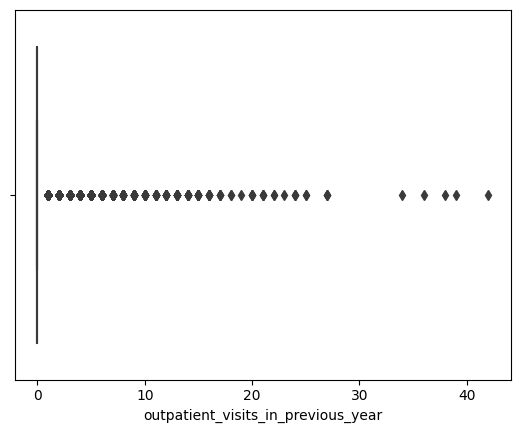

In [44]:
#sns.boxplot(train_out, x = 'outpatient_visits_in_previous_year', palette = 'crest')

Let's analyse the more extreme values that we identified in the boxplot above.

In [45]:
#train_out[train_out['outpatient_visits_in_previous_year']>40]

country  patient_id       race gender      age weight payer_code  \
encounter_id                                                                    
168050           USA    85551867  Caucasian   Male  [80-90)      ?         MC   

              outpatient_visits_in_previous_year  \
encounter_id                                       
168050                                        42   

              emergency_visits_in_previous_year  \
encounter_id                                      
168050                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
168050                                        0      Emergency   

             medical_specialty  average_pulse_bpm  \
encounter_id                                        
168050                       ?                136   

                                          discharge_disposition  \
encounter_id                                                      
168050        Discharged/transferred to home with home healt...   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
168050         Emergency Room                           3                 9   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
168050                         0                     18               428   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
168050                       427                  799                 9   

             glucose_test_result a1c_test_result  \
encounter_id                                       
168050                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
168050                                          No                      Yes   

                 medication  
encounter_id                 
168050        ['glyburide']

<Axes: xlabel='emergency_visits_in_previous_year'>

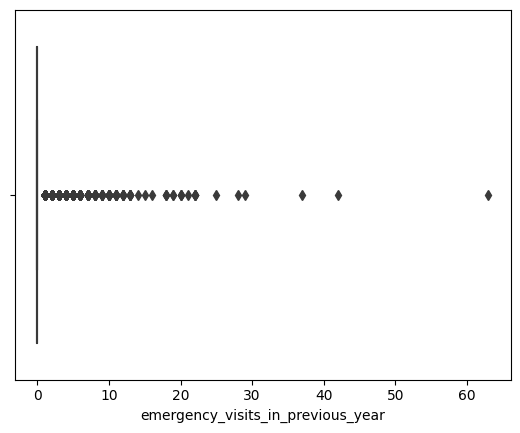

In [46]:
#sns.boxplot(data=train_out, x="emergency_visits_in_previous_year", palette = 'crest')

Let's analyse the more extreme values that we identified in the boxplot above.

In [47]:
#train_out[train_out['emergency_visits_in_previous_year']>60]

country  patient_id       race  gender      age weight  \
encounter_id                                                          
224813           USA    36645885  Caucasian  Female  [60-70)      ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
224813               MD                                   2   

              emergency_visits_in_previous_year  \
encounter_id                                      
224813                                       63   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
224813                                        3         Urgent   

             medical_specialty  average_pulse_bpm  \
encounter_id                                        
224813        Emergency/Trauma                103   

                                          discharge_disposition  \
encounter_id                                                      
224813        Discharged/transferred to home with home healt...   

             admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                  
224813         Emergency Room                           4                30   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
224813                         3                     18               401   

             secondary_diagnosis additional_diagnosis  number_diagnoses  \
encounter_id                                                              
224813                       537                  295                 9   

             glucose_test_result a1c_test_result  \
encounter_id                                       
224813                       NaN             NaN   

             change_in_meds_during_hospitalization prescribed_diabetes_meds  \
encounter_id                                                                  
224813                                          No                      Yes   

               medication  
encounter_id               
224813        ['insulin']

<Axes: xlabel='inpatient_visits_in_previous_year'>

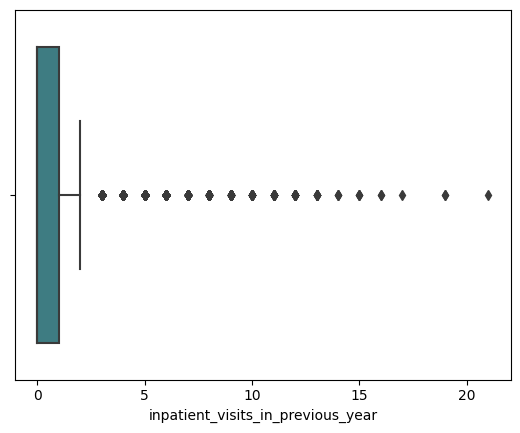

In [48]:
#sns.boxplot(train_out, x = 'inpatient_visits_in_previous_year', palette = 'crest')

<Axes: xlabel='average_pulse_bpm'>

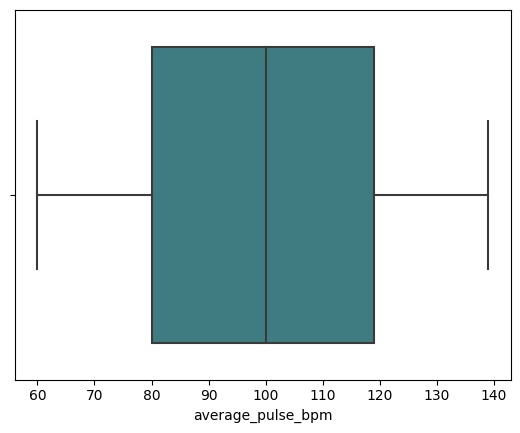

In [49]:
#sns.boxplot(train_out, x = 'average_pulse_bpm', palette = 'crest')

<Axes: xlabel='weight', ylabel='average_pulse_bpm'>

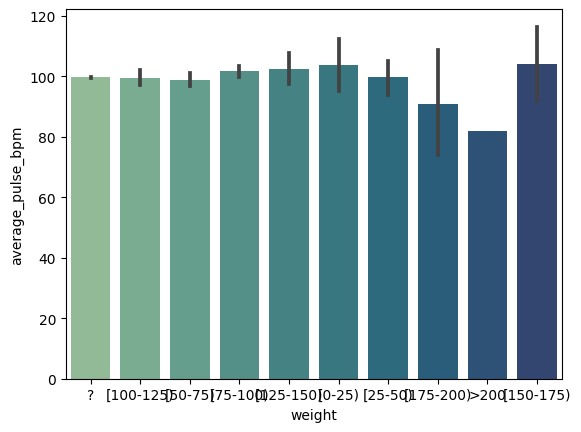

In [50]:
#sns.barplot(train_out, x = 'weight', y = 'average_pulse_bpm', palette = 'crest')

**From an initial observation it seems that the average pulse bpm is why higher in patients with [150-175) in weight.**

**Studies show that the normal heart bit per minute should be within 60 to 100 for healthy adults** (*Vital Signs (Body Temperature, Pulse Rate, Respiration Rate, Blood Pressure). (2022, June 14). Retrieved October 28, 2023, from Hopkinsmedicine.org website: https://www.hopkinsmedicine.org/health/conditions-and-diseases/vital-signs-body-temperature-pulse-rate-respiration-rate-blood-pressure* ), **and that females also tend to have faster heart rates than males.**

**Altough studies reveal that overweight increases heart rate** (*Saeid Yazdanirad, Dehghan, H., Rahimi, Y., Zeinodini, M., & Mahnaz Shakeriyan. (2015). The Relationship Between Overweight and Heart Rate in Hot and Very Hot Weather Under Controlled Conditions. Health Scope, 4(4). https://doi.org/10.17795/jhealthscope-30604*) **it is not expected to go above the 100 beats per minute** (*All About Heart Rate (Pulse). (2018, January 29). Retrieved October 28, 2023, from www.heart.org website: https://www.heart.org/en/health-topics/high-blood-pressure/the-facts-about-high-blood-pressure/all-about-heart-rate-pulse*), **revealing that we have some individuals in our data with some likely health problem to be getting such high values.**

<Axes: xlabel='length_of_stay_in_hospital'>

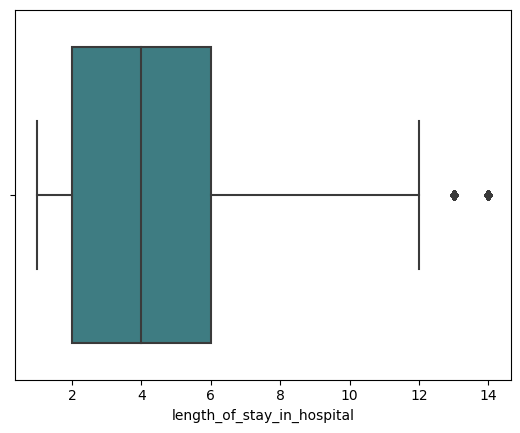

In [51]:
#sns.boxplot(train_out, x = 'length_of_stay_in_hospital', palette = 'crest')

<Axes: xlabel='weight', ylabel='length_of_stay_in_hospital'>

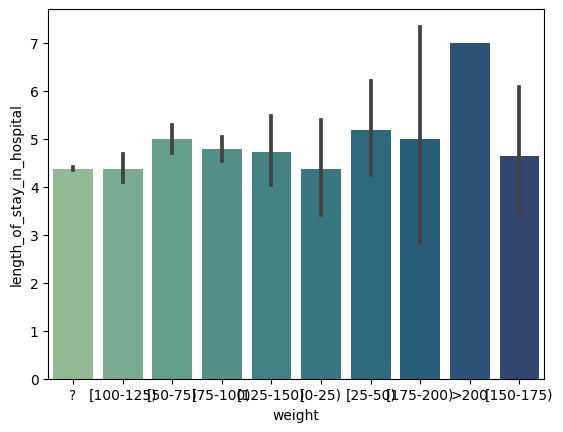

In [52]:
#sns.barplot(train_out, x = 'weight', y = 'length_of_stay_in_hospital', palette = 'crest')

In [53]:
#train_out[train_out['weight']=='>200']['length_of_stay_in_hospital']

encounter_id
715879    7
Name: length_of_stay_in_hospital, dtype: int64

<Axes: xlabel='age', ylabel='length_of_stay_in_hospital'>

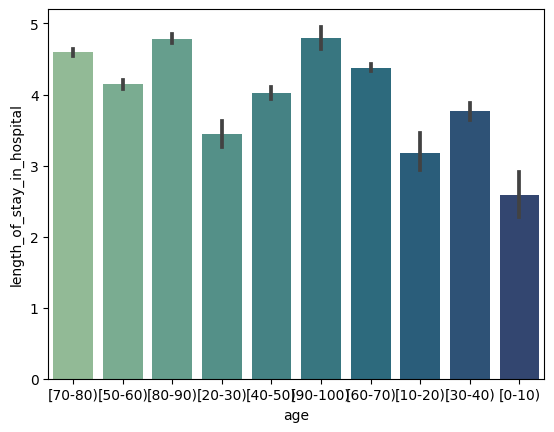

In [54]:
#sns.barplot(train_out, x = 'age', y = 'length_of_stay_in_hospital', palette = 'crest')

In [55]:
#train_out[train_out['length_of_stay_in_hospital'] == 14]['age'].value_counts(dropna= False)

[70-80)     135
[80-90)     111
[60-70)      95
[50-60)      70
[40-50)      41
NaN          27
[90-100)     17
[30-40)       8
[20-30)       5
[10-20)       3
Name: age, dtype: int64

**Older people seem to spend more days between admission and discharge in the hospital.**

<Axes: xlabel='race', ylabel='length_of_stay_in_hospital'>

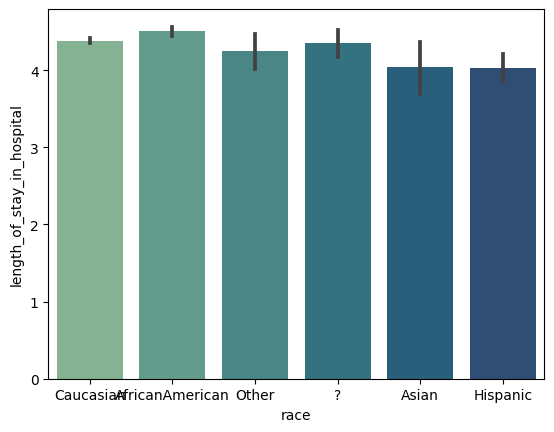

In [56]:
#sns.barplot(train_out, x = 'race', y = 'length_of_stay_in_hospital', palette = 'crest')

<Axes: xlabel='number_lab_tests'>

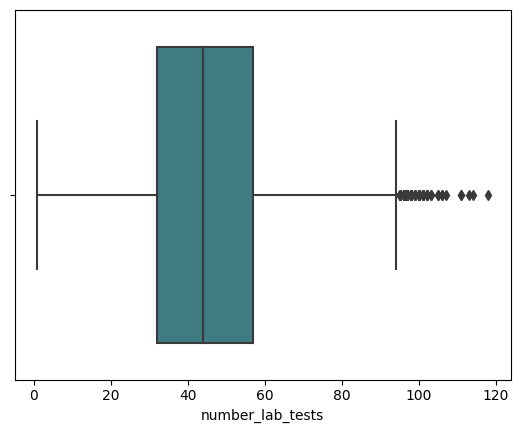

In [57]:
#sns.boxplot(train_out, x = 'number_lab_tests', palette = 'crest')

<Axes: xlabel='non_lab_procedures'>

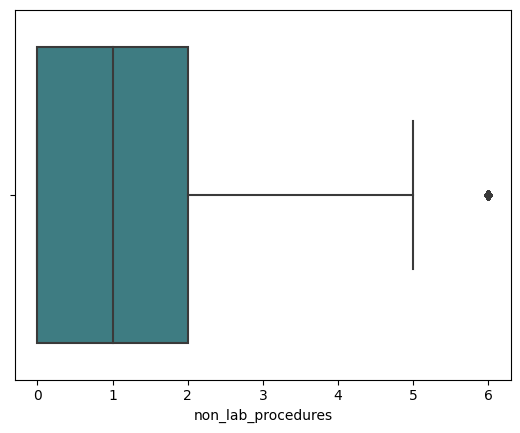

In [58]:
#sns.boxplot(train_out, x = 'non_lab_procedures', palette = 'crest')

<Axes: xlabel='number_of_medications'>

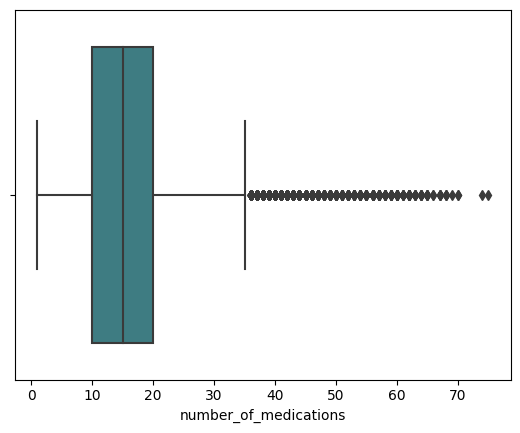

In [59]:
#sns.boxplot(train_out, x = 'number_of_medications', palette = 'crest')

<Axes: xlabel='number_diagnoses'>

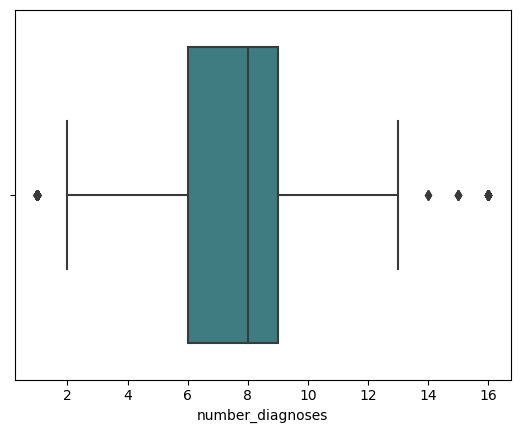

In [60]:
#sns.boxplot(train_out, x = 'number_diagnoses', palette = 'crest')

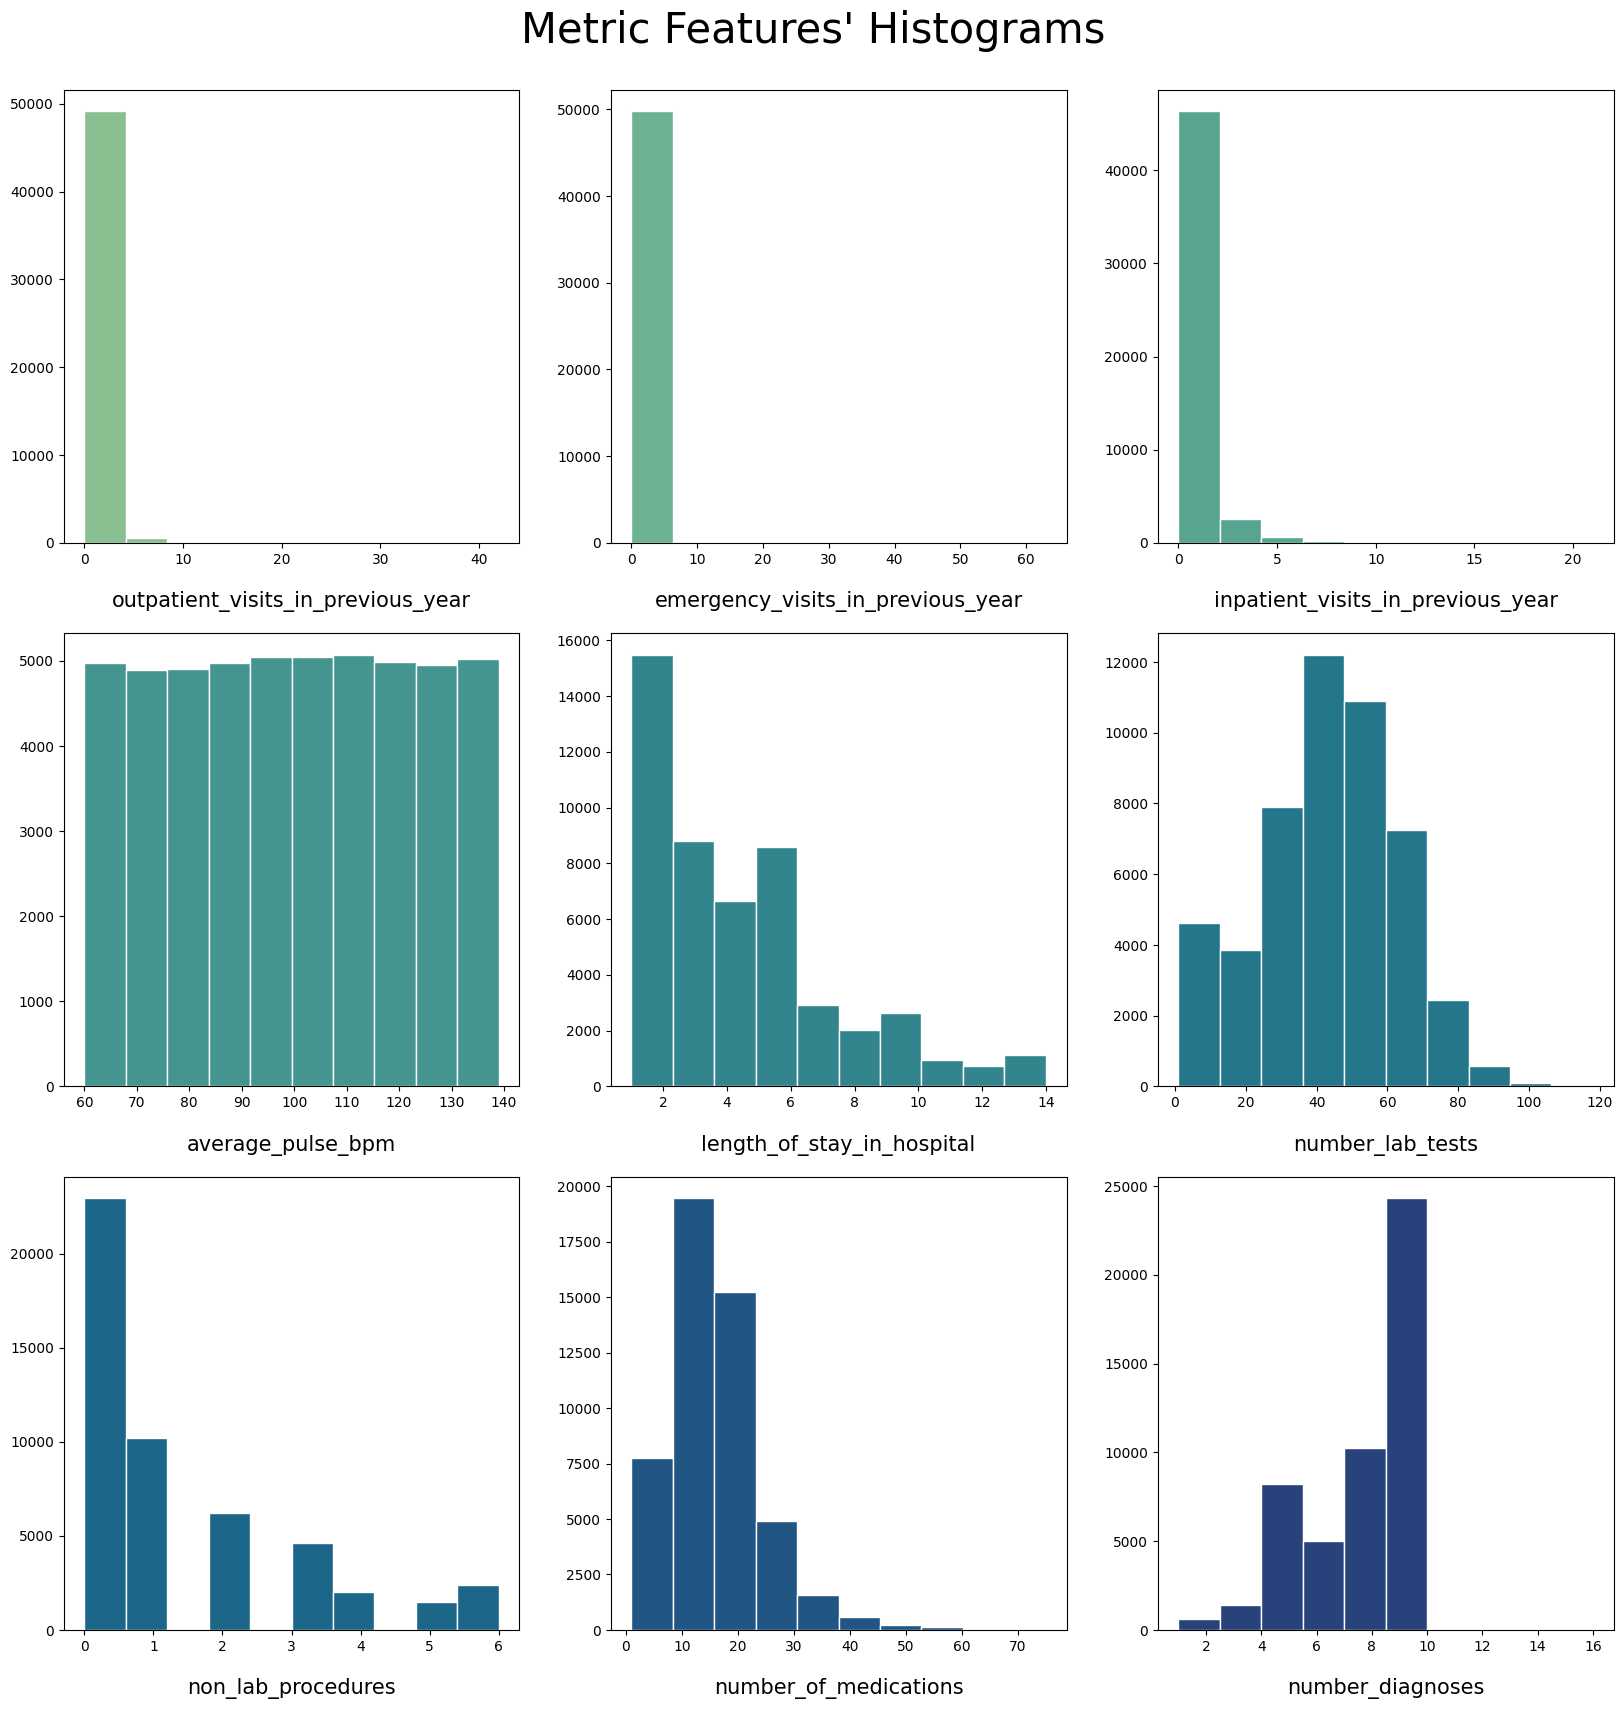

In [61]:
#metric_variables = ["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year",
#                   "inpatient_visits_in_previous_year", "average_pulse_bpm", "length_of_stay_in_hospital", "number_lab_tests",
#                   "non_lab_procedures", "number_of_medications", "number_diagnoses"]

#fig, axes = plt.subplots(3, ceil(len(metric_variables) / 3), figsize = (20, 20))

#colors = sns.color_palette('crest', n_colors=len(metric_variables))

## Plotting the data:
#for ax, feat, color in zip(axes.flatten(), metric_variables, colors):
#    ax.hist(train_out[feat], color = color, edgecolor = "white")
#    ax.set_title(feat, y= -0.16, fontsize = 15)

# Layout:
#plt.suptitle("Metric Features' Histograms", size = 30, y = 0.92)
#plt.show()

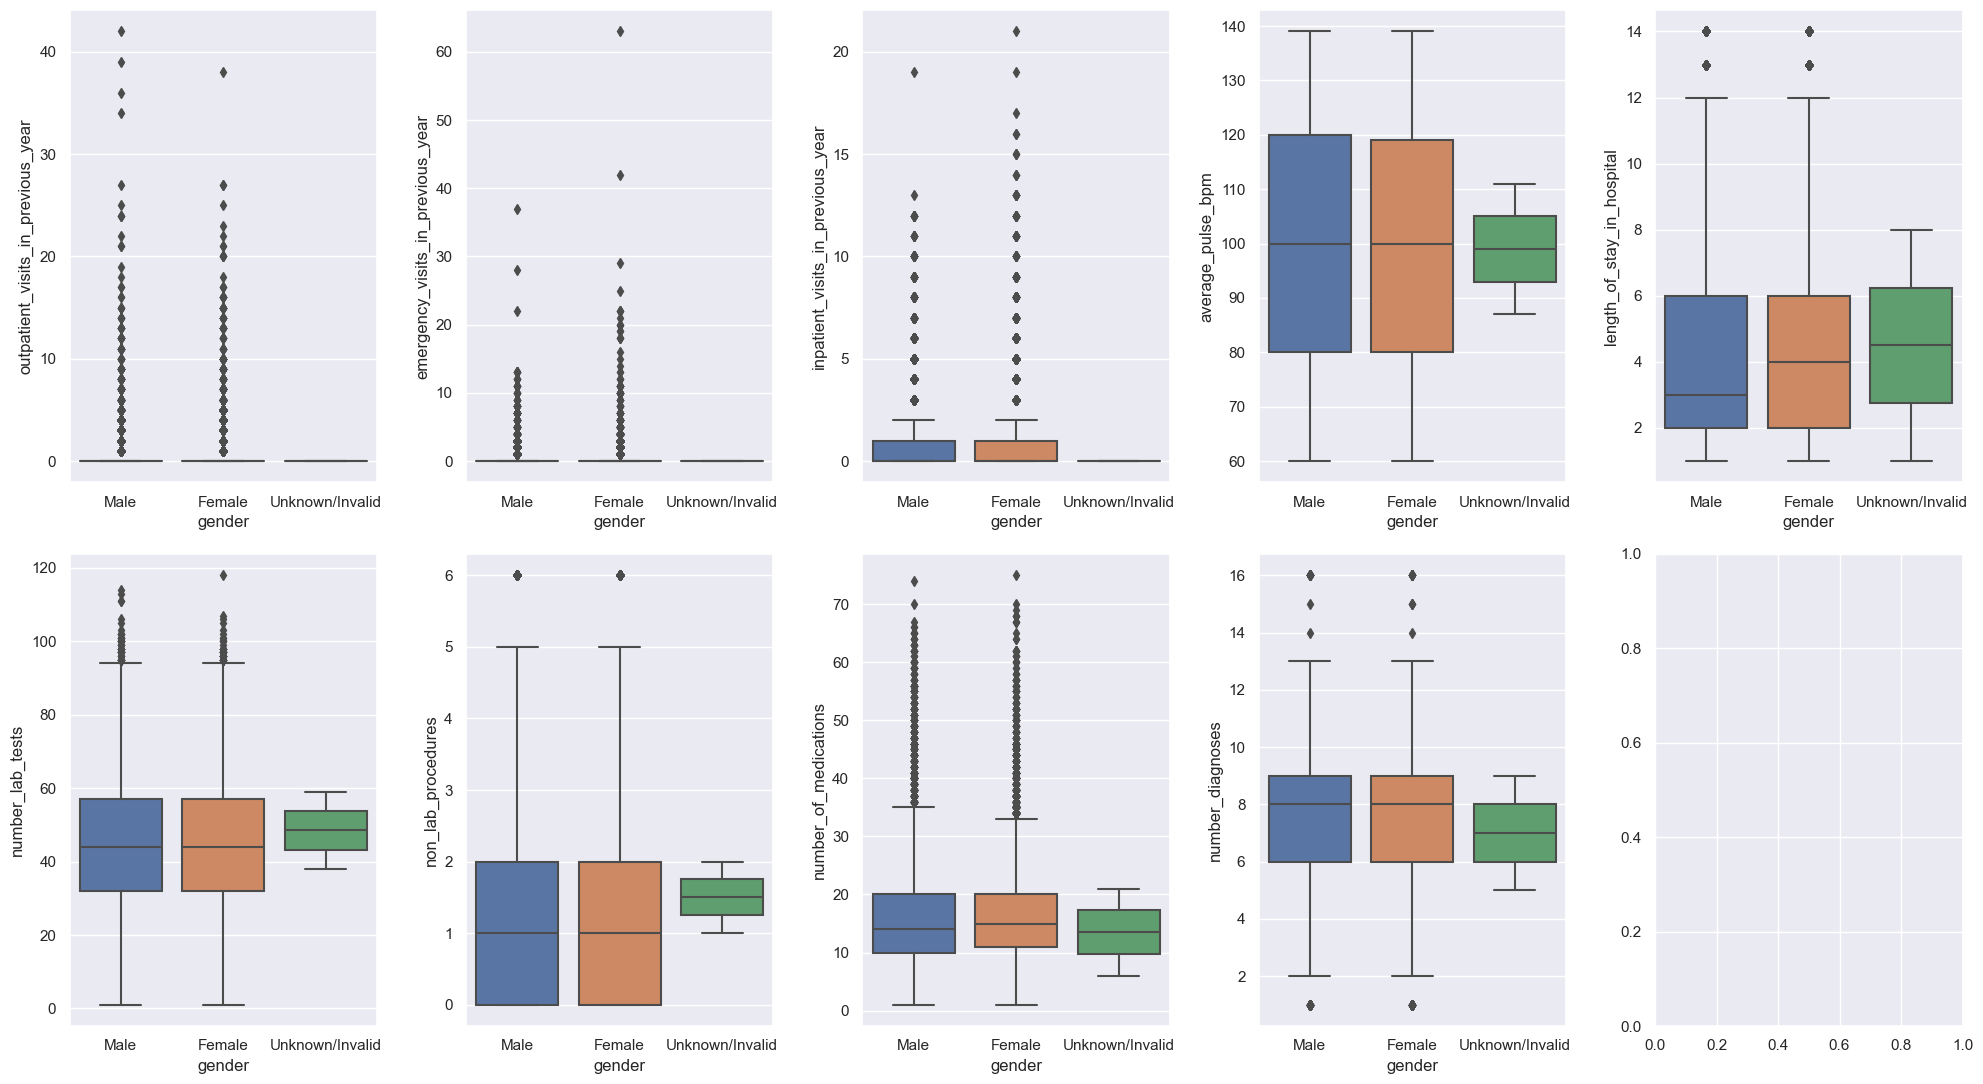

In [62]:
#Checking for outliers per category
# All Numeric Variables' Box Plots in one figure
#sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
#fig, axes = plt.subplots(2, ceil(len(metric_variables) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
#for ax, feat in zip(axes.flatten(), metric_variables): # Notice the zip() function and flatten() method
#    sns.boxplot(y=train_out[feat], x=train_out['gender'], ax=ax)

#plt.tight_layout()
#plt.show()

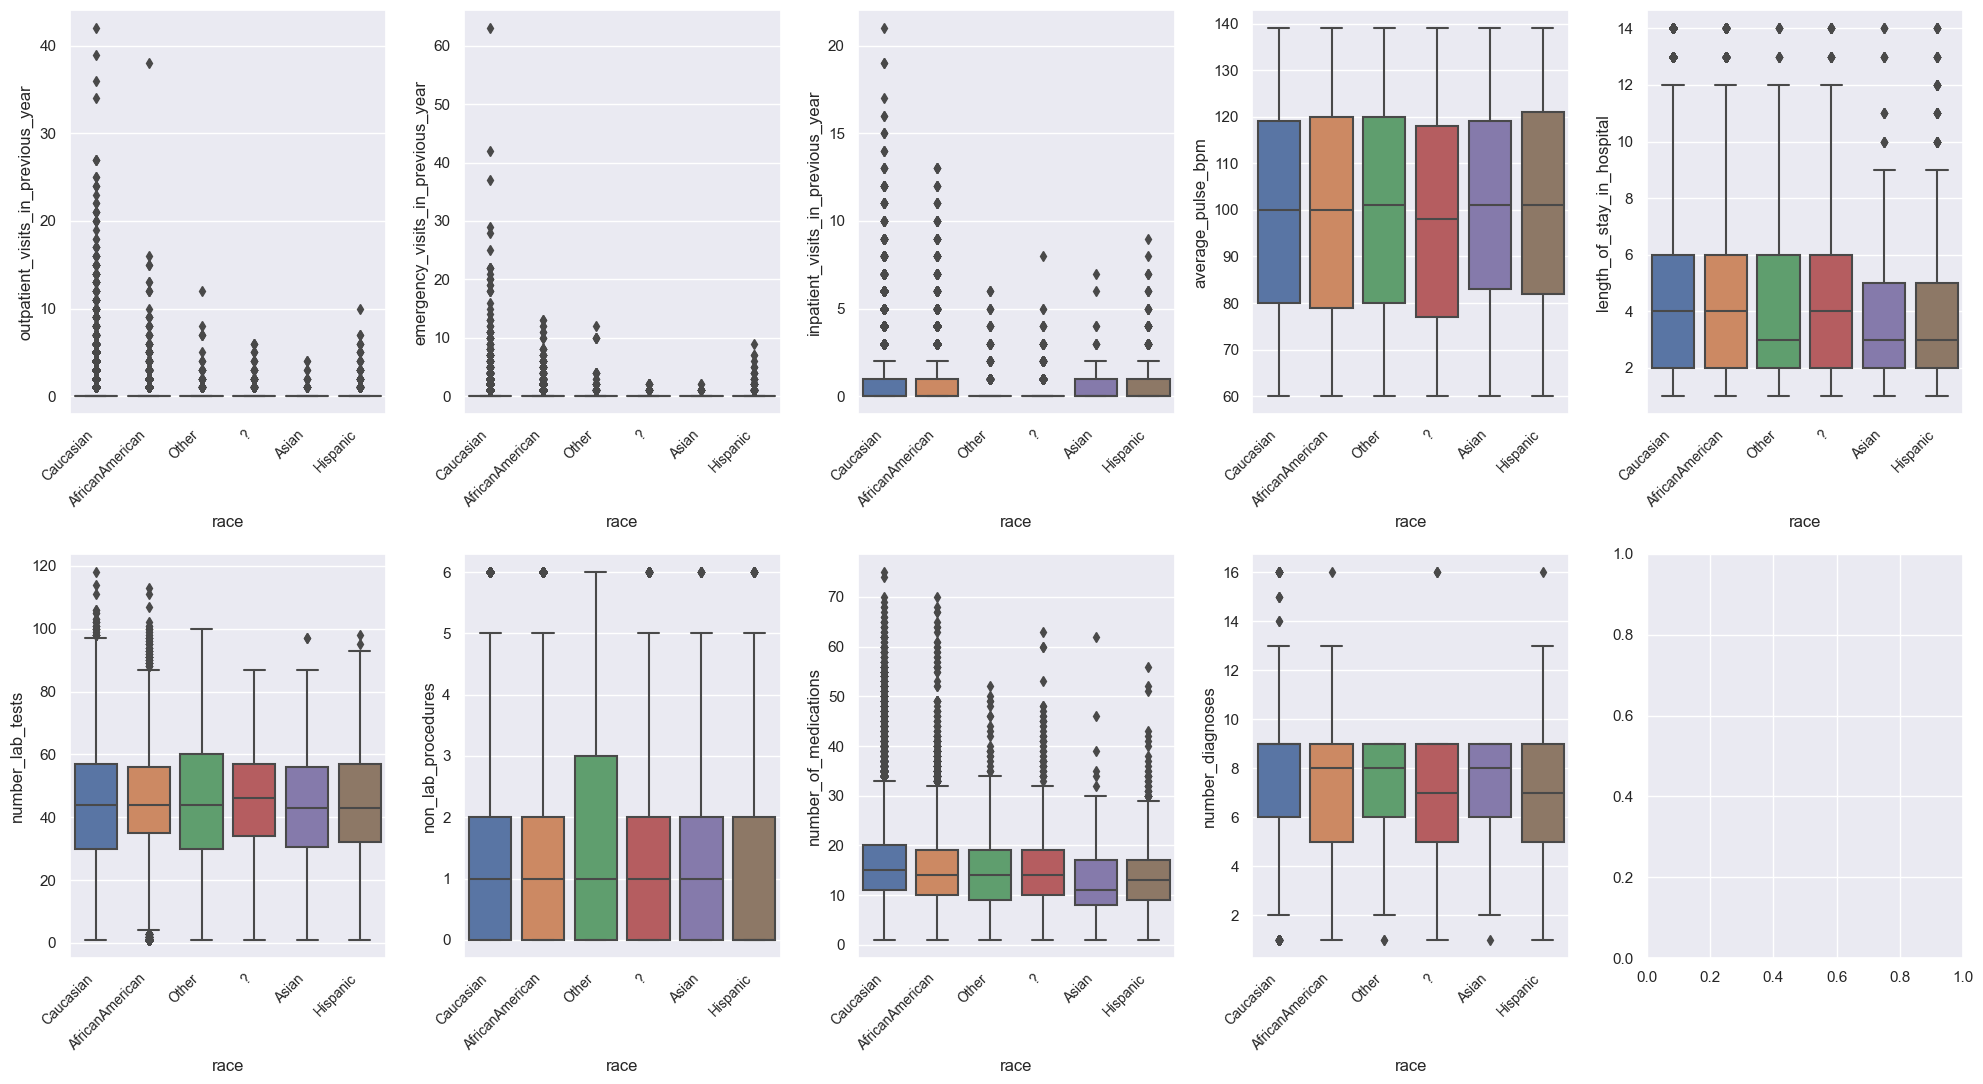

In [63]:
#Checking for outliers per category
# All Numeric Variables' Box Plots in one figure
#sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
#fig, axes = plt.subplots(2, ceil(len(metric_variables) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
#for ax, feat in zip(axes.flatten(), metric_variables): # Notice the zip() function and flatten() method
#    sns.boxplot(y=train_out[feat], x=train_out['race'], ax=ax)
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)

#plt.tight_layout()
#plt.show()

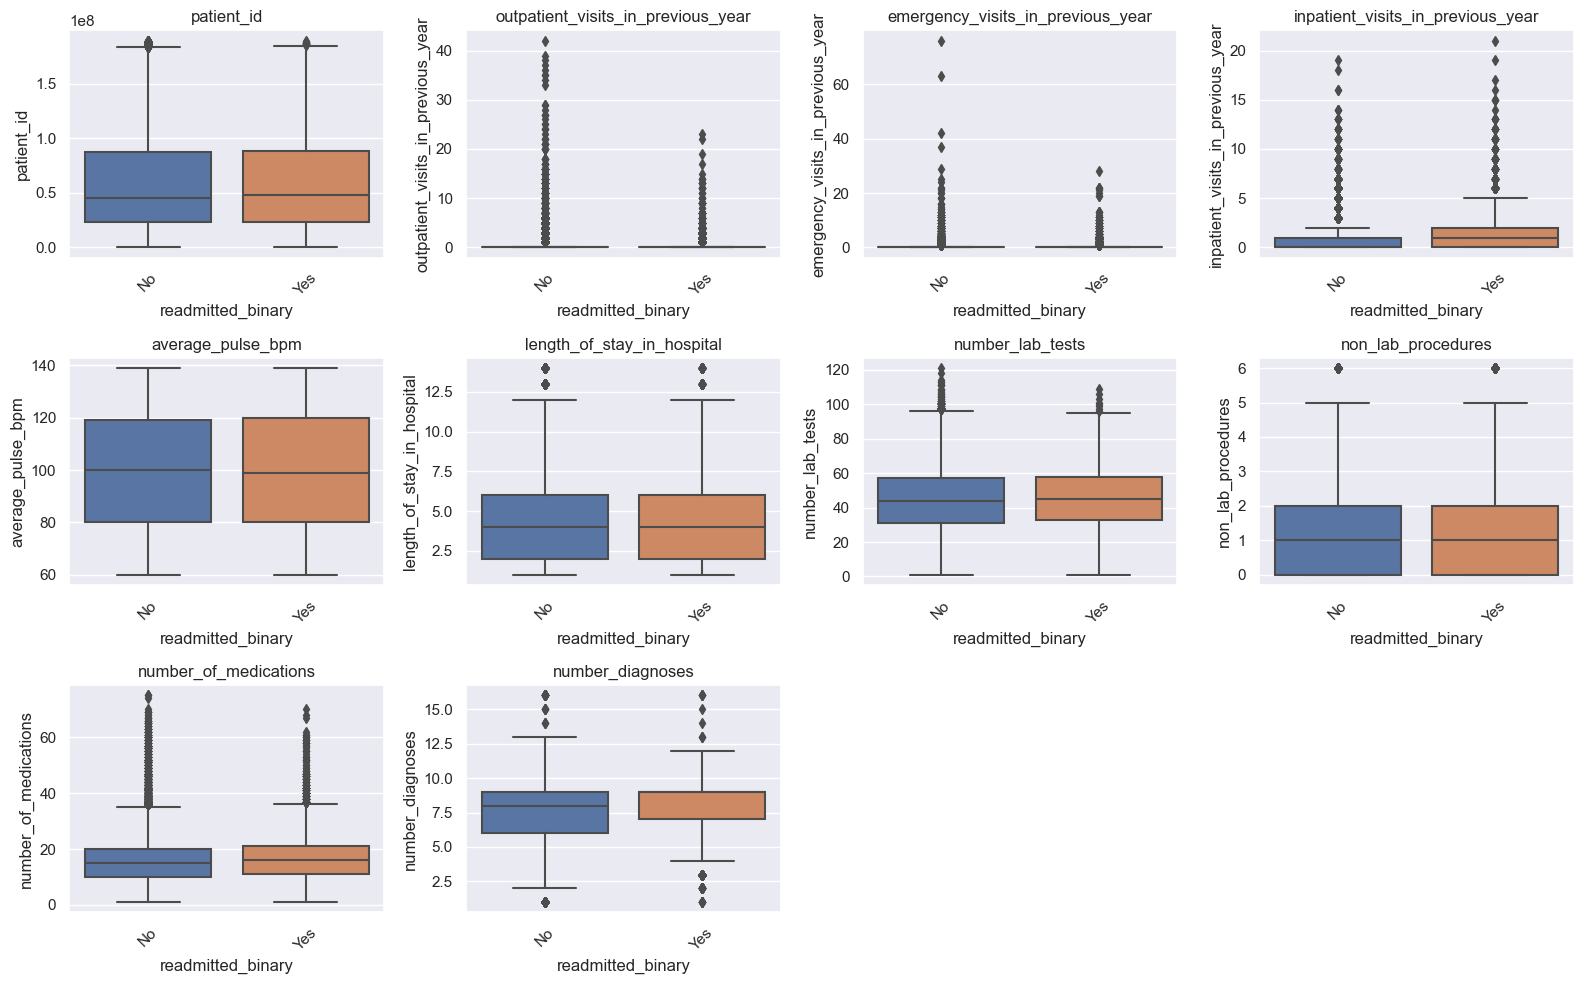

In [64]:
# Select numerical columns for outlier visualization
#numerical_features = train_out.select_dtypes(include=['int64', 'float64'])

# Plot box plots for numerical features to identify outliers
#plt.figure(figsize=(16, 10))
#for i, column in enumerate(numerical_features.columns, start=1):
#    plt.subplot(3, 4, i)  # Adjust the subplot grid as needed
#    sns.boxplot(x='readmitted_binary', y=column, data=train)
#    plt.title(f'{column}')
#    plt.xticks(rotation=45)
#    plt.tight_layout()

#plt.show()

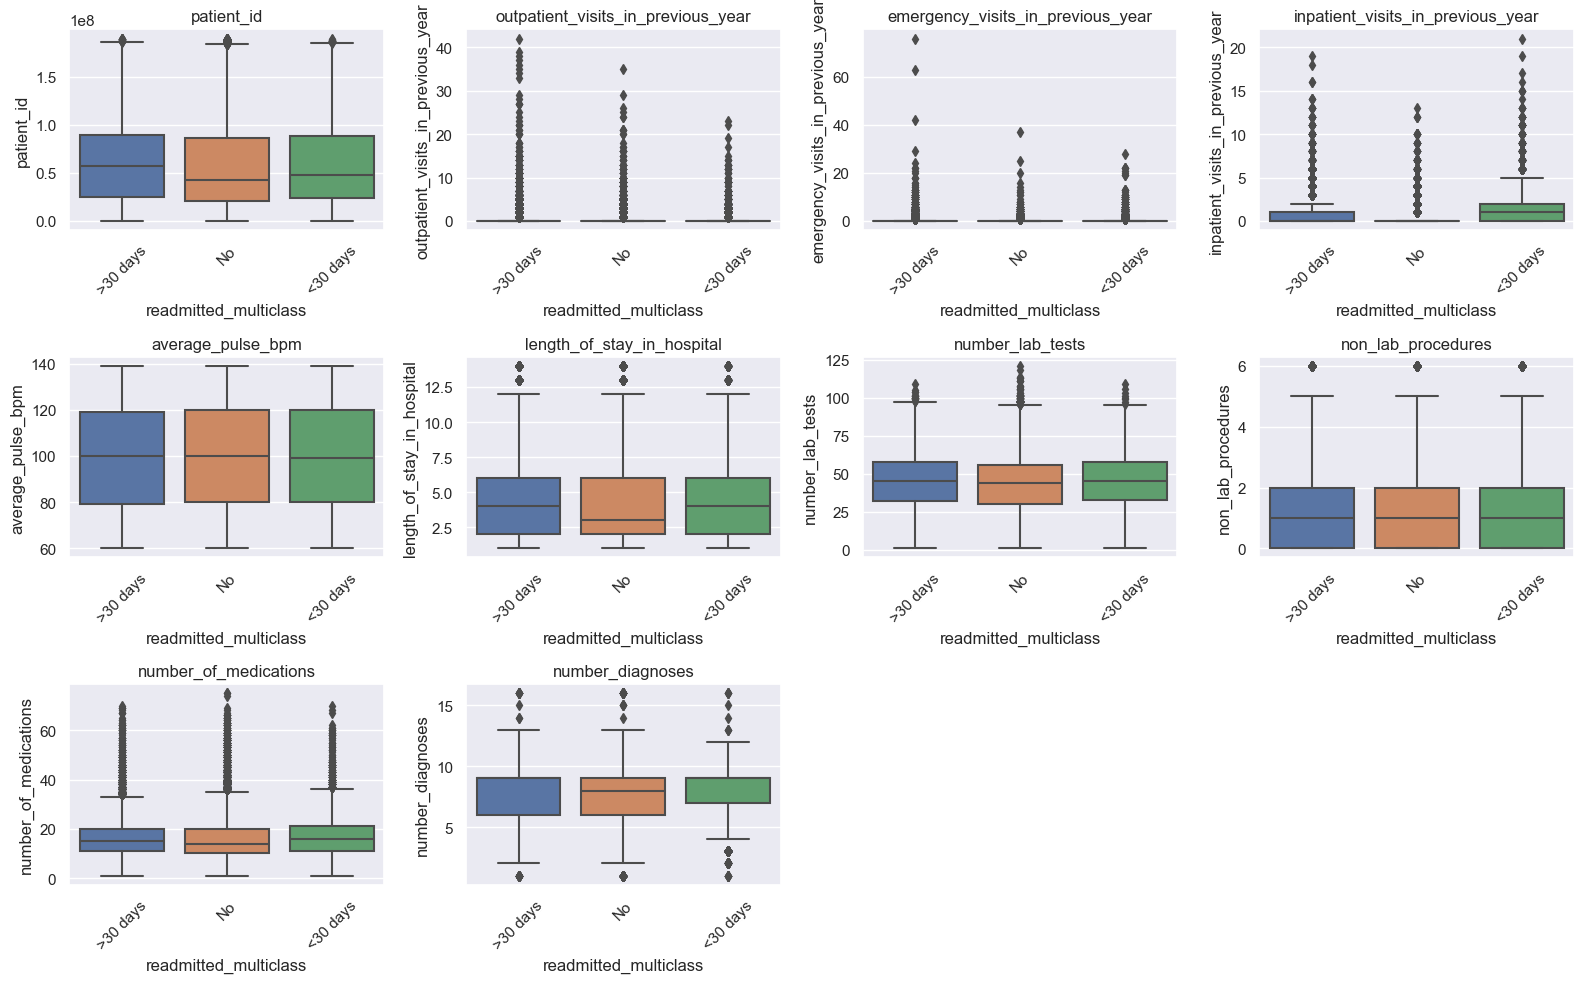

In [65]:
# Plot separate box plots for numerical features based on 'readmitted_multiclass' classes
#plt.figure(figsize=(16, 10))
#for i, column in enumerate(numerical_features.columns, start=1):
#    plt.subplot(3, 4, i)  # Adjust the subplot grid as needed
#    sns.boxplot(x='readmitted_multiclass', y=column, data=train)
#    plt.title(f'{column}')
#    plt.xticks(rotation=45)
#    plt.tight_layout()

#plt.show()

The Visual EDA allows us to conclude that, at least at this stage, there are __no outliers__ worth removing.

# <font color='#238278'>Data Preprocessing</font> <a class="anchor" id="preproc"></a>
[Back to Contents](#toc)

## <font color='#238278'>Duplicate Information</font> <a class="anchor" id="duplicate"></a>
[Back to Contents](#toc)

We should check if there are any duplicates in our dataset.

In [66]:
X_train.duplicated().sum()

0

Nice, we are good to go here.

## <font color='#238278'>Missing Values</font> <a class="anchor" id="missing"></a>
[Back to Contents](#toc)

First and foremost, we will create a copy of our train dataset so that the original data is not affected.

In [67]:
train_mv = X_train.copy()

### Gender

When it comes to Gender, the category has 2 rows with the value 'Unknown/Invalid', which do not exist in the Test dataset. Because of that, we will consider this value as missing, and we will replace it with the mode, both in the training and in the validation datasets.

In [68]:
train_mv["gender"].unique()

array(['Male', 'Female', 'Unknown/Invalid'], dtype=object)

In [69]:
print(train_mv["gender"].value_counts(), end = "\n----------------------\n")
print(X_val["gender"].value_counts(), end = "\n----------------------\n")
print(test["gender"].value_counts(), end = "\n----------------------\n")

Female             26781
Male               23082
Unknown/Invalid        2
Name: gender, dtype: int64
----------------------
Female             11447
Male                9923
Unknown/Invalid        1
Name: gender, dtype: int64
----------------------
Female    16480
Male      14050
Name: gender, dtype: int64
----------------------


In [70]:
gender_mode = train_mv["gender"].mode()[0]
gender_mode

'Female'

In [71]:
train_mv["gender"].replace(to_replace = 'Unknown/Invalid', value = gender_mode, inplace = True)
X_val["gender"].replace(to_replace = 'Unknown/Invalid', value = gender_mode, inplace = True)

In [72]:
train_mv['gender'].value_counts(dropna = False)

Female    26783
Male      23082
Name: gender, dtype: int64

### Missing Values' Summary

Now, let's start by checking the which columns have missing values, as well as their weight in the total amount of observations.

In [73]:
na_cols = train_mv.columns[train_mv.isna().any()].tolist()

# Missing values summary.
missing_values = pd.DataFrame(train_mv[na_cols].isna().sum(), columns = ["Number of missing values"])
missing_values["Percentage of missing values"] = round(missing_values["Number of missing values"] / len(train_mv) * 100, 2)
missing_values

Number of missing values  Percentage of missing values
race                                       2517                          5.05
age                                        2474                          4.96
admission_type                             2580                          5.17
discharge_disposition                      1787                          3.58
admission_source                           3241                          6.50
glucose_test_result                       47294                         94.84
a1c_test_result                           41488                         83.20

### Race

Regarding Race, we can assign the '?' to 'Other' and then assign our missing values to a new category named 'Unknown'.

In [74]:
train_mv['race'].replace(to_replace = '?', value = 'Other', inplace = True)
train_mv['race'].replace(to_replace = np.nan, value = 'Unknown', inplace = True)

train_mv['race'].value_counts(dropna = False)

Caucasian          35571
AfricanAmerican     8791
Unknown             2517
Other               1761
Hispanic             942
Asian                283
Name: race, dtype: int64

We will do the same to the validation and test datasets.

In [75]:
X_val['race'].replace(to_replace = '?', value = 'Other', inplace = True)
X_val['race'].replace(to_replace = np.nan, value = 'Unknown', inplace = True)

X_val['race'].value_counts(dropna = False)

Caucasian          15122
AfricanAmerican     3902
Unknown             1037
Other                750
Hispanic             422
Asian                138
Name: race, dtype: int64

In [76]:
test['race'].replace(to_replace = '?', value = 'Other', inplace = True)
test['race'].replace(to_replace = np.nan, value = 'Unknown', inplace = True)

test['race'].value_counts(dropna = False)

Caucasian          21617
AfricanAmerican     5535
Unknown             1534
Other               1094
Hispanic             563
Asian                187
Name: race, dtype: int64

### New Summary

About the remaining variables, we will replace the "?" and consider them as missing values.

In [77]:
train_mv.replace("?", np.nan, inplace = True)
X_val.replace("?", np.nan, inplace = True)
test.replace("?", np.nan, inplace = True)

Let's replot the missing values table and check which other columns now have missing values too.

In [78]:
na_cols = train_mv.columns[train_mv.isna().any()].tolist()

missing_values = pd.DataFrame(train_mv[na_cols].isna().sum(), columns = ["Number of missing values"])
missing_values["Percentage of missing values"] = round(missing_values["Number of missing values"] / len(train_mv) * 100, 2)
missing_values

Number of missing values  Percentage of missing values
age                                        2474                          4.96
weight                                    48311                         96.88
payer_code                                19663                         39.43
admission_type                             2580                          5.17
medical_specialty                         24593                         49.32
discharge_disposition                      1787                          3.58
admission_source                           3241                          6.50
primary_diagnosis                            10                          0.02
secondary_diagnosis                         180                          0.36
additional_diagnosis                        694                          1.39
glucose_test_result                       47294                         94.84
a1c_test_result                           41488                         83.20

We can also plot a heatmap that will show us the distribution of the missing values throughout the columns. This is helpful, for example, to detect if there are observations containing mising values for several attributes.

Text(0.5, 1.0, 'Heatmap of Missing Values (Train Dataset)')

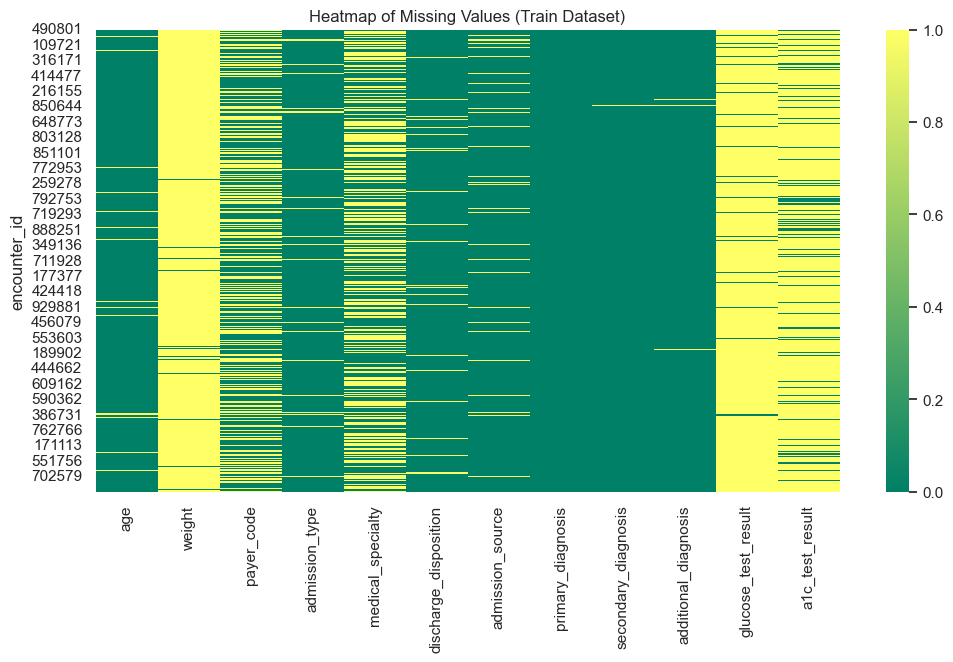

In [79]:
plt.figure(figsize = (12,6))
sns.heatmap(train_mv[na_cols].isna(), cmap = "summer")
plt.title("Heatmap of Missing Values (Train Dataset)")

### Age

For age, we will replace the missing values with their mode. The missing values in the validation and test datasets will also be replaced with the mode for the training dataset.

In [80]:
train_mv["age"].value_counts().sort_index()

[0-10)         70
[10-20)       331
[20-30)       733
[30-40)      1762
[40-50)      4501
[50-60)      7979
[60-70)     10455
[70-80)     12159
[80-90)      8083
[90-100)     1318
Name: age, dtype: int64

In [81]:
age_mode = train_mv["age"].mode().loc[0]
age_mode

'[70-80)'

In [82]:
train_mv["age"].fillna(age_mode, inplace=True)
X_val["age"].fillna(age_mode, inplace=True)
test["age"].fillna(age_mode, inplace=True)

### Weight

Also, as Weight is pretty much composed of only missing values, inputing this much would be biasing the results, so we will drop the variable.

In [83]:
train_mv = train_mv.drop('weight', axis='columns')
X_val = X_val.drop('weight', axis='columns')
test = test.drop('weight', axis='columns')

### Medical Specialty

Medical_Specialty could be removed as 49% of its values are missing. Therefore, we avoid unnecessary noise in the dataset by removing it.

In [84]:
train_mv.drop(columns = "medical_specialty", inplace = True)
X_val.drop(columns = "medical_specialty", inplace = True)
test.drop(columns = "medical_specialty", inplace = True)

### Discharge Disposition & Admission Source

The missing values in the "discharge_disposition" and "admission_source" column will be replaced with "Not Mapped", a category that already exists in our data.

In [85]:
train_mv["discharge_disposition"].fillna("Not Mapped", inplace = True)
X_val["discharge_disposition"].fillna("Not Mapped", inplace = True)
test["discharge_disposition"].fillna("Not Mapped", inplace = True)

In [86]:
train_mv["admission_source"].fillna("Not Mapped", inplace = True)
X_val["admission_source"].fillna("Not Mapped", inplace = True)
test["admission_source"].fillna("Not Mapped", inplace = True)

### Primary, Secondary and Additional Diagnosis

In the variables related to diagnosis (primary_diagnosis, secondary_diagnosis and additional_diagnosis), we will replace the missing values with "Other", since we consider that no diagnosis was taken (either because there was no need or because doctors couldn't find a diagnosis).

In [87]:
train_mv["primary_diagnosis"].fillna("Other", inplace = True)
train_mv["secondary_diagnosis"].fillna("Other", inplace = True)
train_mv["additional_diagnosis"].fillna("Other", inplace = True)

In [88]:
X_val["primary_diagnosis"].fillna("Other", inplace = True)
X_val["secondary_diagnosis"].fillna("Other", inplace = True)
X_val["additional_diagnosis"].fillna("Other", inplace = True)

In [89]:
test["primary_diagnosis"].fillna("Other", inplace = True)
test["secondary_diagnosis"].fillna("Other", inplace = True)
test["additional_diagnosis"].fillna("Other", inplace = True)

### Final Summary

In [90]:
na_cols = train_mv.columns[train_mv.isna().any()].tolist()

missing_values = pd.DataFrame(train_mv[na_cols].isna().sum(), columns = ["Number of missing values"])
missing_values["Percentage of missing values"] = round(missing_values["Number of missing values"] / len(train_mv) * 100, 2)
missing_values

Number of missing values  Percentage of missing values
payer_code                              19663                         39.43
admission_type                           2580                          5.17
glucose_test_result                     47294                         94.84
a1c_test_result                         41488                         83.20

The remaining features containing missing values (shown in the table above) will later be used in the feature engineering stage.

In [91]:
X_train = train_mv.copy()

## <font color='#238278'>Feature Engineering</font> <a class="anchor" id="engineering"></a>
[Back to Contents](#toc)

Let's create another copy of our dataset, which we will use to perform feature engineering.

In [92]:
train_fe = X_train.copy()

In [93]:
train_fe.head()

country  patient_id             race  gender      age payer_code  \
encounter_id                                                                    
490801           USA    94549842        Caucasian    Male  [70-80)         MC   
968682           USA    48274776        Caucasian  Female  [50-60)         MC   
223228           USA    99819513        Caucasian  Female  [80-90)         MC   
919675           USA    25202025  AfricanAmerican  Female  [50-60)        NaN   
681552           USA   108250083  AfricanAmerican  Female  [70-80)        NaN   

              outpatient_visits_in_previous_year  \
encounter_id                                       
490801                                         0   
968682                                         2   
223228                                         0   
919675                                         0   
681552                                         1   

              emergency_visits_in_previous_year  \
encounter_id                                      
490801                                        0   
968682                                        3   
223228                                        0   
919675                                        0   
681552                                        1   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
490801                                        3         Urgent   
968682                                        0      Emergency   
223228                                        0       Elective   
919675                                        0      Emergency   
681552                                        2      Emergency   

              average_pulse_bpm  \
encounter_id                      
490801                      136   
968682                      112   
223228                      103   
919675                       96   
681552                      124   

                                          discharge_disposition  \
encounter_id                                                      
490801                                       Discharged to home   
968682                                       Discharged to home   
223228                                       Discharged to home   
919675                                       Discharged to home   
681552        Discharged/transferred to home with home healt...   

                 admission_source  length_of_stay_in_hospital  \
encounter_id                                                    
490801         Physician Referral                           3   
968682             Emergency Room                           5   
223228         Physician Referral                           1   
919675             Emergency Room                           2   
681552             Emergency Room                           5   

              number_lab_tests  non_lab_procedures  number_of_medications  \
encounter_id                                                                
490801                      26                   0                      9   
968682                      65                   0                     14   
223228                      32                   6                      9   
919675                      45                   0                     11   
681552                      37                   2                     14   

             primary_diagnosis secondary_diagnosis additional_diagnosis  \
encounter_id                                                              
490801                       8                 584                  599   
968682                     276                 780                  250   
223228                     414                 428                  424   
919675                     786                 518                  530   
681552                     420                 198                  162   

              number_

### Country

First of all, we can remove the variable 'country' as it only has 1 value.

In [94]:
train_fe = train_fe.drop('country', axis='columns')
X_val = X_val.drop('country', axis='columns')
test = test.drop('country', axis='columns')

### Payer Code

For Payer_Code, let's transform this variable into a binary one, where if you have a code it will be classified has 1, i.e., you have health insurance, or 0 otherwise, where these 0s also represent the missing values. With this, we can then delete Payer_Code.

In [95]:
train_fe["health_insurance"] = np.where(train_fe["payer_code"].isna(), 0, 1)
X_val["health_insurance"] = np.where(X_val["payer_code"].isna(), 0, 1)
test["health_insurance"] = np.where(test["payer_code"].isna(), 0, 1)

train_fe.drop(columns = "payer_code", inplace = True)
X_val.drop(columns = "payer_code", inplace = True)
test.drop(columns = "payer_code", inplace = True)

In [96]:
train_fe["health_insurance"].value_counts(dropna = False)

1    30202
0    19663
Name: health_insurance, dtype: int64

### Admission Type

For Admission_Type let's group the categories.

In [97]:
train_fe['admission_type'].value_counts(dropna = False)

Emergency        26471
Elective          9267
Urgent            9078
NaN               2580
Not Available     2320
Not Mapped         138
Trauma Center        9
Newborn              2
Name: admission_type, dtype: int64

In [98]:
train_fe['admission_type'].replace(to_replace = np.nan, value = 'Unknown/Other', inplace = True)
train_fe['admission_type'].replace(to_replace = 'Not Available', value = 'Unknown/Other', inplace = True)
train_fe['admission_type'].replace(to_replace = 'Not Mapped', value = 'Unknown/Other', inplace = True)
train_fe['admission_type'].replace(to_replace = 'Trauma Center', value = 'Unknown/Other', inplace = True)
train_fe['admission_type'].replace(to_replace = 'Newborn', value = 'Unknown/Other', inplace = True)
train_fe['admission_type'].replace(to_replace = 'Urgent', value = 'Emergency', inplace = True)

train_fe['admission_type'].value_counts(dropna = False)

Emergency        35549
Elective          9267
Unknown/Other     5049
Name: admission_type, dtype: int64

We will perform the same changes to the validation and test datasets.

In [99]:
print(X_val['admission_type'].value_counts(dropna = False), end = "\n----------------\n")
print(test['admission_type'].value_counts(dropna = False), end = "\n----------------\n")

Emergency        11271
Urgent            3946
Elective          3944
NaN               1126
Not Available     1000
Not Mapped          76
Trauma Center        4
Newborn              4
Name: admission_type, dtype: int64
----------------
Emergency        16248
Elective          5658
Urgent            5456
NaN               1585
Not Available     1465
Not Mapped         106
Trauma Center        8
Newborn              4
Name: admission_type, dtype: int64
----------------


In [100]:
X_val['admission_type'].replace(to_replace = np.nan, value = 'Unknown/Other', inplace = True)
X_val['admission_type'].replace(to_replace = 'Not Available', value = 'Unknown/Other', inplace = True)
X_val['admission_type'].replace(to_replace = 'Not Mapped', value = 'Unknown/Other', inplace = True)
X_val['admission_type'].replace(to_replace = 'Trauma Center', value = 'Unknown/Other', inplace = True)
X_val['admission_type'].replace(to_replace = 'Newborn', value = 'Unknown/Other', inplace = True)
X_val['admission_type'].replace(to_replace = 'Urgent', value = 'Emergency', inplace = True)

test['admission_type'].replace(to_replace = np.nan, value = 'Unknown/Other', inplace = True)
test['admission_type'].replace(to_replace = 'Not Available', value = 'Unknown/Other', inplace = True)
test['admission_type'].replace(to_replace = 'Not Mapped', value = 'Unknown/Other', inplace = True)
test['admission_type'].replace(to_replace = 'Trauma Center', value = 'Unknown/Other', inplace = True)
test['admission_type'].replace(to_replace = 'Newborn', value = 'Unknown/Other', inplace = True)
test['admission_type'].replace(to_replace = 'Urgent', value = 'Emergency', inplace = True)

print(X_val['admission_type'].value_counts(dropna = False), end = "\n----------------\n")
print(test['admission_type'].value_counts(dropna = False), end = "\n----------------\n")

Emergency        15217
Elective          3944
Unknown/Other     2210
Name: admission_type, dtype: int64
----------------
Emergency        21704
Elective          5658
Unknown/Other     3168
Name: admission_type, dtype: int64
----------------


### Discharge Disposition

Regarding the discharge_disposition, we observed the initial categories and grouped them based on their similarity in terms of discharge destination. Also, our goal was to reduce the strings' length to facilitate visualizing the categories. Therefore, we grouped them according to whether the patient was transferred to home, to another hospital facility, as others when the info was unavailable, and as expired/hospice.

In [101]:
train_fe['discharge_disposition'] = train_fe['discharge_disposition'].astype(str)
X_val['discharge_disposition'] = X_val['discharge_disposition'].astype(str)
test['discharge_disposition'] = test['discharge_disposition'].astype(str)

In [102]:
def categorizing_discharge(disposition):
    if any(keyword.lower() in disposition.lower() for keyword in ['Expired', 'Hospice']):
        return 'Expired/hospice'
    elif any(keyword.lower() in disposition.lower() for keyword in ['Home']):
        return 'Home discharge'
    elif any(keyword.lower() in disposition.lower() for keyword in ['SNF', 'Hospital', 'Rehab',
                                                                    'Inpatient', 'Care', 'ICF',
                                                                    'Institution','Nursing',
                                                                    'Facility', 'Outpatient',
                                                                    'Service', 'Services', 'Health']):
        return 'Hospital care'
    else:
        return 'Other'

In [103]:
train_fe['merged_discharge_disposition'] = train_fe['discharge_disposition'].apply(categorizing_discharge)
X_val['merged_discharge_disposition'] = X_val['discharge_disposition'].apply(categorizing_discharge)
test['merged_discharge_disposition'] = test['discharge_disposition'].apply(categorizing_discharge)

In [104]:
train_fe['merged_discharge_disposition'].value_counts(dropna = False)

Home discharge     35996
Hospital care      10133
Other               2542
Expired/hospice     1194
Name: merged_discharge_disposition, dtype: int64

In [105]:
train_fe.drop(columns = "discharge_disposition", inplace = True)
X_val.drop(columns = "discharge_disposition", inplace = True)
test.drop(columns = "discharge_disposition", inplace = True)

train_fe.columns

Index(['patient_id', 'race', 'gender', 'age',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'admission_source', 'length_of_stay_in_hospital',
       'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
       'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis',
       'number_diagnoses', 'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'health_insurance', 'merged_discharge_disposition'],
      dtype='object')

### Admission Source

Regarding admission_source, we followed the same logic employed in discharge_disposition.

In [106]:
train_fe['admission_source'].value_counts()

 Emergency Room                                               28324
 Physician Referral                                           14465
Not Mapped                                                     3241
Transfer from a hospital                                       1561
 Transfer from another health care facility                    1081
Clinic Referral                                                 534
 Transfer from a Skilled Nursing Facility (SNF)                 410
HMO Referral                                                     89
 Not Mapped                                                      75
 Not Available                                                   63
 Court/Law Enforcement                                            8
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            4
 Sick Baby                                                        1
 Extramural Birth                               

In [107]:
X_val['admission_source'].value_counts()

 Emergency Room                                               11995
 Physician Referral                                            6213
Not Mapped                                                     1477
Transfer from a hospital                                        669
 Transfer from another health care facility                     481
Clinic Referral                                                 245
 Transfer from a Skilled Nursing Facility (SNF)                 185
HMO Referral                                                     40
 Not Mapped                                                      32
 Not Available                                                   25
 Court/Law Enforcement                                            3
 Transfer from critial access hospital                            3
 Transfer from hospital inpt/same fac reslt in a sep claim        2
 Transfer from Ambulatory Surgery Center                          1
Name: admission_source, dtype: int64

In [108]:
test['admission_source'].value_counts()

 Emergency Room                                               17175
 Physician Referral                                            8887
Not Mapped                                                     2063
Transfer from a hospital                                        957
 Transfer from another health care facility                     702
Clinic Referral                                                 325
 Transfer from a Skilled Nursing Facility (SNF)                 260
HMO Referral                                                     58
 Not Mapped                                                      54
 Not Available                                                   37
 Court/Law Enforcement                                            5
 Transfer from hospital inpt/same fac reslt in a sep claim        4
Normal Delivery                                                   1
 Transfer from critial access hospital                            1
 Extramural Birth                               

In [109]:
train_fe['admission_source'] = train_fe['admission_source'].astype(str)
X_val['admission_source'] = X_val['admission_source'].astype(str)
test['admission_source'] = test['admission_source'].astype(str)

In [110]:
def categorizing_admission(source):
    if any(keyword.lower() in source.lower() for keyword in ['Emergency']):
        return 'Emergency'
    elif any(keyword.lower() in source.lower() for keyword in ['Referral']):
        return 'Referral'
    elif any(keyword.lower() in source.lower() for keyword in ['Transfer']):
        return 'Transfer'
    else:
        return 'Unknown/Other'

In [111]:
train_fe['merged_admission_source'] = train_fe['admission_source'].apply(categorizing_admission)
X_val['merged_admission_source'] = X_val['admission_source'].apply(categorizing_admission)
test['merged_admission_source'] = test['admission_source'].apply(categorizing_admission)

In [112]:
train_fe['merged_admission_source'].value_counts()

Emergency        28324
Referral         15088
Unknown/Other     3390
Transfer          3063
Name: merged_admission_source, dtype: int64

In [113]:
train_fe.drop(columns = "admission_source", inplace = True)
X_val.drop(columns = "admission_source", inplace = True)
test.drop(columns = "admission_source", inplace = True)

train_fe.columns

Index(['patient_id', 'race', 'gender', 'age',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'health_insurance', 'merged_discharge_disposition',
       'merged_admission_source'],
      dtype='object')

### Glucose Test Result

For Glucose_Test_Result we transformed this variable in a binary one, Took_Glucose_Test, where if there is missing values is 0, otherwise we assign it to 1.

In [114]:
train_fe["took_glucose_test"] = np.where(train_fe["glucose_test_result"].isna(), 0, 1)
X_val["took_glucose_test"] = np.where(X_val["glucose_test_result"].isna(), 0, 1)
test["took_glucose_test"] = np.where(test["glucose_test_result"].isna(), 0, 1)

train_fe.drop(columns = "glucose_test_result", inplace = True)
X_val.drop(columns = "glucose_test_result", inplace = True)
test.drop(columns = "glucose_test_result", inplace = True)

In [115]:
train_fe['took_glucose_test'].value_counts(dropna = False)

0    47294
1     2571
Name: took_glucose_test, dtype: int64

### A1C Test Result & Change in Meds During Hospitalization & Prescribed Diabetes Meds

This same approach will be used to deal with a1c_test_result, change_in_meds_during_hospitalization, Prescribed_Diabetes_Meds.

In [116]:
train_fe["took_a1c_test"] = np.where(train_fe["a1c_test_result"].isna(),0,1)
X_val["took_a1c_test"] = np.where(X_val["a1c_test_result"].isna(),0,1)
test["took_a1c_test"] = np.where(test["a1c_test_result"].isna(),0,1)

train_fe.drop(columns = "a1c_test_result", inplace = True)
X_val.drop(columns = "a1c_test_result", inplace = True)
test.drop(columns = "a1c_test_result", inplace = True)

In [117]:
train_fe['took_a1c_test'].value_counts(dropna = False)

0    41488
1     8377
Name: took_a1c_test, dtype: int64

In [118]:
train_fe["change_in_meds_during_hospitalization"] = train_fe["change_in_meds_during_hospitalization"].replace({"No": 0, "Ch": 1})
X_val["change_in_meds_during_hospitalization"] = X_val["change_in_meds_during_hospitalization"].replace({"No": 0, "Ch": 1})
test["change_in_meds_during_hospitalization"] = test["change_in_meds_during_hospitalization"].replace({"No": 0, "Ch": 1})

In [119]:
train_fe["prescribed_diabetes_meds"] = train_fe["prescribed_diabetes_meds"].replace({"No":0, "Yes":1})
X_val["prescribed_diabetes_meds"] = X_val["prescribed_diabetes_meds"].replace({"No":0, "Yes":1})
test["prescribed_diabetes_meds"] = test["prescribed_diabetes_meds"].replace({"No":0, "Yes":1})

### Diabetes

Based on the ICD-9 codes (http://www.icd9data.com/2015/Volume1/default.htm) related to diabetes in primary_diagnosis, secondary_diagnosis, and additional_diagnosis, we extracted information from the decimal parts of the code regarding the type of diabetes and whether it is controlled. Also, we gathered information regarding the presence or lack of complications stemming from diabetes, which enables us to categorize diabetes according to the degree of severity. Such a degree mainly relates to whether a complication poses an immediate life-threatening situation to a patient.

In [120]:
def diabetes_severity(observation):
    code_unspecified = {'250'}
    code_mild = {'250.00', '250.01', '250.02', '250.03'}
    code_moderate = {'250.4', '250.40', '250.41', '250.42', '250.43', '250.5', '250.50', '250.51', '250.52', '250.53', '250.6',
                     '250.60', '250.61', '250.62', '250.63', '250.7', '250.70', '250.71', '250.72', '250.73', '250.8', '250.80',
                     '250.81', '250.82', '250.83', '250.4', '250.90', '250.91', '250.92', '250.93',}
    code_severe = {'250.1', '250.10', '250.11', '250.12', '250.13', '250.2', '250.20', '250.21', '250.22', '250.23', '250.3',
                   '250.30', '250.31', '250.32', '250.33'}

    unspecified = any(code in code_unspecified for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                            observation['additional_diagnosis']])
    mild = any(code in code_mild for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                              observation['additional_diagnosis']])
    moderate = any(code in code_moderate for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                      observation['additional_diagnosis']])
    severe = any(code in code_severe for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                  observation['additional_diagnosis']])

    if unspecified:
        return "Unspecified"
    elif mild:
        return "Mild"
    elif moderate:
        return "Moderate"
    elif severe:
        return "Severe"
    else:
        return "Unrelated"

In [121]:
train_fe['diabetes_severity'] = train_fe.apply(diabetes_severity, axis = 1)
X_val['diabetes_severity'] = X_val.apply(diabetes_severity, axis = 1)
test['diabetes_severity'] = test.apply(diabetes_severity, axis = 1)

In [122]:
train_fe['diabetes_severity'].value_counts(normalize = True)

Unrelated      0.628176
Unspecified    0.176276
Moderate       0.097864
Mild           0.070210
Severe         0.027474
Name: diabetes_severity, dtype: float64

In [123]:
def diabetes_control_type(observation):
    code_unspecified = {'250', '250.1', '250.2', '250.3', '250.4', '250.5', '250.6', '250.7', '250.8', '250.9'}
    code_unstatedI = {'250.01', '250.11', '250.21', '250.31', '250.41', '250.51', '250.61', '250.71', '250.81', '250.91'}
    code_unstatedII = {'250.00', '250.10', '250.20', '250.30', '250.40', '250.50', '250.60', '250.70', '250.80', '250.90'}
    code_uncontrolledI = {'250.03', '250.13', '250.23', '250.33', '250.43', '250.53', '250.63', '250.73', '250.83', '250.93'}
    code_uncontrolledII = {'250.02', '250.12', '250.22', '250.32', '250.42', '250.52', '250.62', '250.72', '250.82', '250.92'}

    unspecified = any(code in code_unspecified for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                            observation['additional_diagnosis']])
    unstatedI = any(code in code_unstatedI for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                        observation['additional_diagnosis']])
    unstatedII = any(code in code_unstatedII for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                          observation['additional_diagnosis']])
    uncontrolledI = any(code in code_uncontrolledI for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                                observation['additional_diagnosis']])
    uncontrolledII = any(code in code_uncontrolledII for code in [observation['primary_diagnosis'], observation['secondary_diagnosis'],
                                                                  observation['additional_diagnosis']])

    if unspecified:
        return "Unspecified"
    elif unstatedI:
        return "Unstated_typeI"
    elif unstatedII:
        return "Unstated_typeII"
    elif uncontrolledI:
        return "Uncontrolled_typeI"
    elif uncontrolledII:
        return "Uncontrolled_typeII"
    else:
        return "Unrelated"

In [124]:
train_fe['diabetes_control_type'] = train_fe.apply(diabetes_control_type, axis = 1)
X_val['diabetes_control_type'] = X_val.apply(diabetes_control_type, axis = 1)
test['diabetes_control_type'] = test.apply(diabetes_control_type, axis = 1)

In [125]:
train_fe['diabetes_control_type'].value_counts(normalize = True)

Unrelated              0.627955
Unspecified            0.252301
Uncontrolled_typeII    0.061747
Unstated_typeI         0.040168
Uncontrolled_typeI     0.017828
Name: diabetes_control_type, dtype: float64

### Primary, Secondary and Additional Diagnosis

Reagarding the variables related to diagnosis (primary_diagnosis, secondary_diagnosis and additional_diagnosis), we will replace the ICD-9 codes with their broader category, in order to facilitate posterior analysis. <br>
http://www.icd9data.com/2015/Volume1/default.htm

* 001-139  Infectious And Parasitic Diseases
* 140-239  Neoplasms
* 240-279  Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
* 280-289  Diseases Of The Blood And Blood-Forming Organs
* 290-319  Mental Disorders
* 320-389  Diseases Of The Nervous System And Sense Organs
* 390-459  Diseases Of The Circulatory System
* 460-519  Diseases Of The Respiratory System
* 520-579  Diseases Of The Digestive System
* 580-629  Diseases Of The Genitourinary System
* 630-679  Complications Of Pregnancy, Childbirth, And The Puerperium
* 680-709  Diseases Of The Skin And Subcutaneous Tissue
* 710-739  Diseases Of The Musculoskeletal System And Connective Tissue
* 740-759  Congenital Anomalies
* 760-779  Certain Conditions Originating In The Perinatal Period
* 780-799  Symptoms, Signs, And Ill-Defined Conditions
* 800-999  Injury And Poisoning
* V01-V91  Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services
* E000-E999  Supplementary Classification Of External Causes Of Injury And Poisoning

In [126]:
def categorizing_diagnosis(code):
    if "V" in code or "E" in code:
        return "Supplementary conditions"
    elif "Other" in code:
        return "Other"
    elif float(code) in np.arange(0, 140):
        return "Infectious disorders"
    elif float(code) in np.arange(140, 240):
        return "Neoplasms"
    elif float(code) in np.arange(240, 280):
        return "Metabolic disorders"
    elif float(code) in np.arange(280, 290):
        return "Hematologic disorders"
    elif float(code) in np.arange(290, 320):
        return "Mental disorders"
    elif float(code) in np.arange(320, 390):
        return "Neurological disorders"
    elif float(code) in np.arange(390, 460):
        return "Cardiovascular disorders"
    elif float(code) in np.arange(460, 520):
        return "Respiratory disorders"
    elif float(code) in np.arange(520, 580):
        return "Digestive disorders"
    elif float(code) in np.arange(580, 630):
        return "Genitourinary disorders"
    elif float(code) in np.arange(630, 680):
        return "Maternal complications"
    elif float(code) in np.arange(680, 710):
        return "Dermatologic disorders"
    elif float(code) in np.arange(710, 740):
        return "Musculoskeletal disorders"
    elif float(code) in np.arange(740, 760):
        return "Congenital anomalies"
    elif float(code) in np.arange(760, 780):
        return "Perinatal conditions"
    elif float(code) in np.arange(780, 800):
        return "Ill-defined conditions"
    else:
        return "Trauma conditions"

In [127]:
train_fe["prim_diagnosis_cat"] = train_fe["primary_diagnosis"].apply(categorizing_diagnosis)
train_fe["sec_diagnosis_cat"] = train_fe["secondary_diagnosis"].apply(categorizing_diagnosis)
train_fe["add_diagnosis_cat"] = train_fe["additional_diagnosis"].apply(categorizing_diagnosis)

X_val["prim_diagnosis_cat"] = X_val["primary_diagnosis"].apply(categorizing_diagnosis)
X_val["sec_diagnosis_cat"] = X_val["secondary_diagnosis"].apply(categorizing_diagnosis)
X_val["add_diagnosis_cat"] = X_val["additional_diagnosis"].apply(categorizing_diagnosis)

test["prim_diagnosis_cat"] = test["primary_diagnosis"].apply(categorizing_diagnosis)
test["sec_diagnosis_cat"] = test["secondary_diagnosis"].apply(categorizing_diagnosis)
test["add_diagnosis_cat"] = test["additional_diagnosis"].apply(categorizing_diagnosis)

In [128]:
train_fe.head(10)

patient_id             race  gender      age  \
encounter_id                                                 
490801          94549842        Caucasian    Male  [70-80)   
968682          48274776        Caucasian  Female  [50-60)   
223228          99819513        Caucasian  Female  [80-90)   
919675          25202025  AfricanAmerican  Female  [50-60)   
681552         108250083  AfricanAmerican  Female  [70-80)   
313211          24135570          Unknown  Female  [50-60)   
328287          28879128        Caucasian    Male  [50-60)   
585150          49313187          Unknown  Female  [70-80)   
399081          23976288  AfricanAmerican  Female  [80-90)   
126945          84818268  AfricanAmerican    Male  [50-60)   

              outpatient_visits_in_previous_year  \
encounter_id                                       
490801                                         0   
968682                                         2   
223228                                         0   
919675                                         0   
681552                                         1   
313211                                         1   
328287                                         0   
585150                                         2   
399081                                         0   
126945                                         0   

              emergency_visits_in_previous_year  \
encounter_id                                      
490801                                        0   
968682                                        3   
223228                                        0   
919675                                        0   
681552                                        1   
313211                                        0   
328287                                        0   
585150                                        0   
399081                                        0   
126945                                        0   

              inpatient_visits_in_previous_year admission_type  \
encounter_id                                                     
490801                                        3      Emergency   
968682                                        0      Emergency   
223228                                        0       Elective   
919675                                        0      Emergency   
681552                                        2      Emergency   
313211                                        5  Unknown/Other   
328287                                        2  Unknown/Other   
585150                                        0  Unknown/Other   
399081                                        0      Emergency   
126945                                        0       Elective   

              average_pulse_bpm  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                    
490801                      136                           3                26   
968682                      112                           5                65   
223228                      103                           1                32   
919675                       96                           2                45   
681552                      124                           5                37   
313211                       73                           6                17   
328287                      136                           1                15   
585150                       89                           2                72   
399081                      106                           4                51   
126945                       73                           2                51   

              non_lab_procedures  number_of_medications primary_diagnosis  \
encounter_id                                                                
490801                         0                      9                 8   
968682                         0  

In [129]:
train_fe.drop(columns = {"primary_diagnosis", "secondary_diagnosis", "additional_diagnosis"}, inplace = True)
X_val.drop(columns = {"primary_diagnosis", "secondary_diagnosis", "additional_diagnosis"}, inplace = True)
test.drop(columns = {"primary_diagnosis", "secondary_diagnosis", "additional_diagnosis"}, inplace = True)

## <font color='#238278'>Transforming Categorical Variables</font> <a class="anchor" id="cat2num"></a>
[Back to Contents](#toc)

### Age

We chose to pick the midpoint of each age interval and assign it to the respective observations. The reason lies in keeping the feature's group essence numerically. However, the median is not a whole number. Therefore, we round up every median to the closest whole number. For instance, the median of [70,80) is 74.5, and we rounded it to 75.

[70-80) -> 75;
[60-70) -> 65;
[80-90) -> 85;
[50-60) -> 55;
[40-50) -> 45;
[30-40) -> 35;
[90-100) -> 95;
[20-30) -> 25;
[10-20) -> 15;
[0-10) -> 5

In [130]:
midpoint = {'[70-80)': 75, '[60-70)': 65, '[80-90)': 85, '[50-60)': 55, '[40-50)': 45, '[30-40)': 35,
            '[90-100)': 95, '[20-30)': 25, '[10-20)': 15, '[0-10)': 5}

def getting_midpoint(interval):
    return midpoint.get(interval, None) #If the function finds the interval, it replaces the interval
    #for the midpoint in the dictionary. Otherwise, it returns None.

In [131]:
train_fe['age'] = train_fe['age'].apply(getting_midpoint)
X_val['age'] = X_val['age'].apply(getting_midpoint)
test['age'] = test['age'].apply(getting_midpoint)

train_fe['age'].value_counts()

75    14633
65    10455
85     8083
55     7979
45     4501
35     1762
95     1318
25      733
15      331
5        70
Name: age, dtype: int64

### Gender

Gender was very easily transformed into a new binary variable.

In [132]:
train_fe["gender"] = train_fe["gender"].replace({"Female": 0, "Male": 1})
X_val["gender"] = X_val["gender"].replace({"Female": 0, "Male": 1})
test["gender"] = test["gender"].replace({"Female": 0, "Male": 1})

### Race

We transformed the races through one-hot encoding since it would enable us to maintain its nominal essence. Approaches like label, ordinal, and frequency encoding may introduce a non-existent ordinal relationship between these categories.

In [133]:
train_fe_races = pd.get_dummies(train_fe['race'], prefix = 'race', drop_first = True).astype(int)
train_fe_races.columns = train_fe_races.columns.str.lower()
train_fe_races

race_asian  race_caucasian  race_hispanic  race_other  \
encounter_id                                                          
490801                 0               1              0           0   
968682                 0               1              0           0   
223228                 0               1              0           0   
919675                 0               0              0           0   
681552                 0               0              0           0   
...                  ...             ...            ...         ...   
443480                 0               1              0           0   
651646                 0               1              0           0   
837522                 0               1              0           0   
849949                 0               0              0           0   
991035                 0               1              0           0   

              race_unknown  
encounter_id                
490801                   0  
968682                   0  
223228                   0  
919675                   0  
681552                   0  
...                    ...  
443480                   0  
651646                   0  
837522                   0  
849949                   0  
991035                   0  

[49865 rows x 5 columns]

Let's do the same thing for the validation and test datasets.

In [134]:
X_val_races = pd.get_dummies(X_val['race'], prefix = 'race', drop_first = True).astype(int)
X_val_races.columns = X_val_races.columns.str.lower()

test_races = pd.get_dummies(test['race'], prefix = 'race', drop_first = True).astype(int)
test_races.columns = test_races.columns.str.lower()

In [135]:
train_fe = pd.concat([train_fe, train_fe_races], axis = 1)
X_val = pd.concat([X_val, X_val_races], axis = 1)
test = pd.concat([test, test_races], axis = 1)

train_fe.columns

Index(['patient_id', 'race', 'gender', 'age',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'health_insurance', 'merged_discharge_disposition',
       'merged_admission_source', 'took_glucose_test', 'took_a1c_test',
       'diabetes_severity', 'diabetes_control_type', 'prim_diagnosis_cat',
       'sec_diagnosis_cat', 'add_diagnosis_cat', 'race_asian',
       'race_caucasian', 'race_hispanic', 'race_other', 'race_unknown'],
      dtype='object')

In [136]:
train_fe.drop(columns = "race", inplace = True)
X_val.drop(columns = "race", inplace = True)
test.drop(columns = "race", inplace = True)

train_fe.columns

Index(['patient_id', 'gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'health_insurance', 'merged_discharge_disposition',
       'merged_admission_source', 'took_glucose_test', 'took_a1c_test',
       'diabetes_severity', 'diabetes_control_type', 'prim_diagnosis_cat',
       'sec_diagnosis_cat', 'add_diagnosis_cat', 'race_asian',
       'race_caucasian', 'race_hispanic', 'race_other', 'race_unknown'],
      dtype='object')

### Admission Type

We transformed the admission_type following the frequency encoding since we want to keep the level of prevalence between the categories. Also, it is a useful encoding method to keep the uniqueness of our categories (i.e., Trauma Center and Newborn).

In [137]:
train_fe["admission_type"].value_counts(normalize = True)

Emergency        0.712905
Elective         0.185842
Unknown/Other    0.101253
Name: admission_type, dtype: float64

In [138]:
X_val["admission_type"].value_counts(normalize = True)

Emergency        0.712040
Elective         0.184549
Unknown/Other    0.103411
Name: admission_type, dtype: float64

In [139]:
train_fe['admission_type_freq'] = train_fe['admission_type'].map(train_fe['admission_type'].value_counts(normalize = True))
X_val['admission_type_freq'] = X_val['admission_type'].map(train_fe['admission_type'].value_counts(normalize = True))
test['admission_type_freq'] = test['admission_type'].map(train_fe['admission_type'].value_counts(normalize = True))

In [140]:
train_fe.drop(columns = 'admission_type', inplace = True)
X_val.drop(columns = 'admission_type', inplace = True)
test.drop(columns = 'admission_type', inplace = True)

In [141]:
train_fe['admission_type_freq'].unique()

array([0.71290484, 0.18584177, 0.10125338])

In [142]:
X_val['admission_type_freq'].unique()

array([0.18584177, 0.71290484, 0.10125338])

In [143]:
test['admission_type_freq'].unique()

array([0.71290484, 0.10125338, 0.18584177])

### Merged Discharge Disposition

We transformed the merged_discharge_disposition into a numerical variable following the frequency encoding. The reason is the same as in admission_type. Also, the initial goal is to avoid creating new variables as much as possible.

In [144]:
train_fe["merged_discharge_disposition"].value_counts(normalize = True)

Home discharge     0.721869
Hospital care      0.203209
Other              0.050978
Expired/hospice    0.023945
Name: merged_discharge_disposition, dtype: float64

In [145]:
X_val["merged_discharge_disposition"].value_counts(normalize = True)

Home discharge     0.718076
Hospital care      0.206354
Other              0.053718
Expired/hospice    0.021852
Name: merged_discharge_disposition, dtype: float64

In [146]:
test["merged_discharge_disposition"].value_counts(normalize = True)

Home discharge     0.717393
Hospital care      0.204815
Other              0.052833
Expired/hospice    0.024959
Name: merged_discharge_disposition, dtype: float64

In [147]:
train_fe['discharge_disp_freq'] = train_fe['merged_discharge_disposition'].map(train_fe['merged_discharge_disposition'].value_counts(normalize = True))
X_val['discharge_disp_freq'] = X_val['merged_discharge_disposition'].map(train_fe['merged_discharge_disposition'].value_counts(normalize = True))
test['discharge_disp_freq'] = test['merged_discharge_disposition'].map(train_fe['merged_discharge_disposition'].value_counts(normalize = True))

In [148]:
train_fe['discharge_disp_freq'].unique()

array([0.72186905, 0.05097764, 0.20320866, 0.02394465])

In [149]:
X_val['discharge_disp_freq'].unique()

array([0.72186905, 0.20320866, 0.02394465, 0.05097764])

In [150]:
test['discharge_disp_freq'].unique()

array([0.72186905, 0.05097764, 0.02394465, 0.20320866])

### Merged Admission Source

We transformed the merged_admission_source into a numerical variable following the frequency encoding, similar to admission_type and discharge_disposition.

In [151]:
train_fe["merged_admission_source"].value_counts(normalize = True)

Emergency        0.568014
Referral         0.302577
Unknown/Other    0.067984
Transfer         0.061426
Name: merged_admission_source, dtype: float64

In [152]:
X_val["merged_admission_source"].value_counts(normalize = True)

Emergency        0.561275
Referral         0.304057
Unknown/Other    0.071920
Transfer         0.062749
Name: merged_admission_source, dtype: float64

In [153]:
test["merged_admission_source"].value_counts(normalize = True)

Emergency        0.562561
Referral         0.303636
Unknown/Other    0.070783
Transfer         0.063020
Name: merged_admission_source, dtype: float64

In [154]:
train_fe['admission_source_freq'] = train_fe['merged_admission_source'].map(train_fe['merged_admission_source'].value_counts(normalize = True))
X_val['admission_source_freq'] = X_val['merged_admission_source'].map(train_fe['merged_admission_source'].value_counts(normalize = True))
test['admission_source_freq'] = test['merged_admission_source'].map(train_fe['merged_admission_source'].value_counts(normalize = True))

In [155]:
train_fe.drop(columns = 'merged_admission_source', inplace = True)
X_val.drop(columns = 'merged_admission_source', inplace = True)
test.drop(columns = 'merged_admission_source', inplace = True)

In [156]:
train_fe['admission_source_freq'].unique()

array([0.30257696, 0.56801364, 0.06798356, 0.06142585])

In [157]:
X_val['admission_source_freq'].unique()

array([0.30257696, 0.56801364, 0.06798356, 0.06142585])

In [158]:
test['admission_source_freq'].unique()

array([0.56801364, 0.30257696, 0.06798356, 0.06142585])

### Medication

Regarding medication, we transformed it into a numerical variable by counting the number of medications for each patient. However, we needed first to count the occurrences of each medication (or the absence of it) to get a sense of our data. Printing these values allowed us to check the purpose of each medication and investigate whether we had duplicated values, especially when they were prescribed in tandem. Furthermore, checking the purpose of each medication enabled us to verify that all hyphenated medications are two different medications prescribed in tandem.

In [159]:
medications = train_fe['medication'].apply(eval) # the eval() built-in function enables us to check
# each string we have as lists by temporarily converting them into lists.

medications_count = dict()
no_medications = 0
for medication_list in medications:
    if len(medication_list) == 0:
        no_medications += 1
    else:
        for medication in medication_list:
            if medication in medications_count:
                medications_count[medication] += 1
            else:
                medications_count[medication] = 1
print('No medications: ', no_medications, '\n\n', 'Medications frequency: ', medications_count)

No medications:  11472 

 Medications frequency:  {'glipizide': 6193, 'insulin': 26590, 'metformin': 9786, 'pioglitazone': 3549, 'glyburide': 5307, 'repaglinide': 772, 'rosiglitazone': 3118, 'glimepiride': 2518, 'troglitazone': 2, 'glyburide-metformin': 342, 'nateglinide': 325, 'chlorpropamide': 33, 'acarbose': 145, 'tolazamide': 21, 'miglitol': 21, 'tolbutamide': 10, 'glipizide-metformin': 8, 'metformin-rosiglitazone': 1, 'acetohexamide': 1}


__Metmorfin__ is used for treating type 2 diabetes in people who are overweight. Check the link below.
https://academic.oup.com/eurheartj/article/41/2/255/5556890?login=false <br>
__Troglitazone__ was approved in 1997 in the US but was withdrawn in 2000 due to frequent and severe liver injuries. Check the following link: https://www.ncbi.nlm.nih.gov/books/NBK548142/.

__Insulin__ -> genericly used for diabetes (more crucial in type 1 diabetes). <br>
__Glimepiride__ -> used for type 2 diabetes (not type 1). Can sometimes be combined with other medications.  <br>
__Nateglinide__ -> used for type 2 diabetes. Indicated to combine with Metmorfin. (/https://www.ema.europa.eu/en/documents/product-information/starlix-epar-product-information_en.pdf) <br>
__Glipizide__ -> same conditions as Glimepiride.  <br>
__Glyburide__ -> "focuses on patients with type 2 diabetes mellitus who do not have atherosclerotic cardiovascular disease or chronic kidney disease and have not achieved their HbA1C target despite exhausting first-line treatment options." (https://www.ncbi.nlm.nih.gov/books/NBK545313/) <br>
__Rosiglitazone__ -> "used in the management and treatment of type 2 diabetes mellitus". Some sources say it increases the risk of cardiovascular complications, others deny that. (https://www.ncbi.nlm.nih.gov/books/NBK544230/) <br>
__Repaglinide__ -> used for the management and treatment of type 2 diabetes (https://www.ncbi.nlm.nih.gov/books/NBK559305/) <br>
__Pioglitazone__ -> type 2 diabetes. <br>
__Glyburide-Metformin__ -> "The combination of glyburide and metformin is used to treat type 2 diabetes" (https://medlineplus.gov/druginfo/meds/a699055.html) <br>
__Acarbose__ -> type 2 diabetes <br>
__Tolazamide__ -> type 2 diabetes. <br>
__Acetohexamide__ -> no longer marketed in the US (https://www.ncbi.nlm.nih.gov/books/NBK501049/) <br>
All the rest are for type 2 diabetes


Overall, the number of medications taken, including those taken in tandem, such as __glyburide-metformin__, seems important when, for instance, one drug is not enough for the patient's medical condition. Therefore, should we consider splitting them into different columns? Or should we consider another approach?


After investigating the medication's entries, we began the numerical transformation by stripping all special characters and white spaces from the values but the comma. The comma served as a delimiter, stating when one medication name finished and the next began. Also, we split the hyphenated names into two different names.
Afterward, we counted the occurrences of each medication, removed the duplicates, and attributed the value zero for the empty lists.

In [160]:
train_fe['medication'] = train_fe['medication'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", "").replace('-', '').replace(' ', ''))
X_val['medication'] = X_val['medication'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", "").replace('-', '').replace(' ', ''))
test['medication'] = test['medication'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", "").replace('-', '').replace(' ', ''))

In [161]:
def removing_duplicate(medicines):
    meds = medicines.split(',')
    unique_meds = list(set(meds))
    meds_count = len(unique_meds) if unique_meds[0] else 0 #Checking whether the first element of the list exists
    return meds_count

In [162]:
train_fe['medication_total'] = train_fe['medication'].apply(removing_duplicate)
X_val['medication_total'] = X_val['medication'].apply(removing_duplicate)
test['medication_total'] = test['medication'].apply(removing_duplicate)

In [163]:
train_fe['medication_total'].value_counts()

1    23182
0    11472
2    10765
3     3782
4      637
5       26
6        1
Name: medication_total, dtype: int64

In [164]:
train_fe.drop(columns = 'medication', inplace = True)
X_val.drop(columns = 'medication', inplace = True)
test.drop(columns = 'medication', inplace = True)

### Primary, Secondary and Additional Diagnosis

After replacing the ICD-9 codes with their broad category, we transformed the prim_diagnosis_cat, sec_diagnosis_cat, and add_diagnosis_cat into numerical variables through frequency encoding, similar to admission_type and the other variables.

In [165]:
train_fe["prim_diagnosis_cat"].value_counts(normalize = True)

Cardiovascular disorders     0.298686
Trauma conditions            0.150186
Respiratory disorders        0.102938
Digestive disorders          0.091447
Ill-defined conditions       0.076025
Genitourinary disorders      0.049253
Musculoskeletal disorders    0.047809
Neoplasms                    0.033932
Metabolic disorders          0.028778
Infectious disorders         0.028056
Dermatologic disorders       0.024747
Mental disorders             0.022501
Supplementary conditions     0.015763
Neurological disorders       0.011852
Hematologic disorders        0.010709
Maternal complications       0.006618
Congenital anomalies         0.000501
Other                        0.000201
Name: prim_diagnosis_cat, dtype: float64

In [166]:
train_fe["sec_diagnosis_cat"].value_counts(normalize = True)

Cardiovascular disorders     0.309435
Metabolic disorders          0.139376
Respiratory disorders        0.101273
Trauma conditions            0.090544
Genitourinary disorders      0.078352
Ill-defined conditions       0.045262
Digestive disorders          0.038424
Dermatologic disorders       0.036057
Hematologic disorders        0.028076
Mental disorders             0.025689
Supplementary conditions     0.025008
Neoplasms                    0.024847
Infectious disorders         0.019172
Musculoskeletal disorders    0.017166
Neurological disorders       0.012494
Maternal complications       0.004031
Other                        0.003610
Congenital anomalies         0.001183
Name: sec_diagnosis_cat, dtype: float64

In [167]:
train_fe["add_diagnosis_cat"].value_counts(normalize = True)

Cardiovascular disorders     0.293713
Metabolic disorders          0.202186
Trauma conditions            0.074080
Respiratory disorders        0.067141
Genitourinary disorders      0.061807
Supplementary conditions     0.050256
Ill-defined conditions       0.043538
Digestive disorders          0.035055
Mental disorders             0.031365
Dermatologic disorders       0.024887
Hematologic disorders        0.024606
Musculoskeletal disorders    0.018771
Infectious disorders         0.018450
Neoplasms                    0.018329
Neurological disorders       0.017848
Other                        0.013918
Maternal complications       0.003209
Congenital anomalies         0.000842
Name: add_diagnosis_cat, dtype: float64

In [168]:
train_fe['primary_diagnosis_freq'] = train_fe['prim_diagnosis_cat'].map(train_fe['prim_diagnosis_cat'].value_counts(normalize = True))
X_val['primary_diagnosis_freq'] = X_val['prim_diagnosis_cat'].map(train_fe['prim_diagnosis_cat'].value_counts(normalize = True))
test['primary_diagnosis_freq'] = test['prim_diagnosis_cat'].map(train_fe['prim_diagnosis_cat'].value_counts(normalize = True))

In [169]:
train_fe.drop(columns = 'prim_diagnosis_cat', inplace = True)
X_val.drop(columns = 'prim_diagnosis_cat', inplace = True)
test.drop(columns = 'prim_diagnosis_cat', inplace = True)

In [170]:
train_fe['secondary_diagnosis_freq'] = train_fe['sec_diagnosis_cat'].map(train_fe['sec_diagnosis_cat'].value_counts(normalize = True))
X_val['secondary_diagnosis_freq'] = X_val['sec_diagnosis_cat'].map(train_fe['sec_diagnosis_cat'].value_counts(normalize = True))
test['secondary_diagnosis_freq'] = test['sec_diagnosis_cat'].map(train_fe['sec_diagnosis_cat'].value_counts(normalize = True))

In [171]:
train_fe.drop(columns = 'sec_diagnosis_cat', inplace = True)
X_val.drop(columns = 'sec_diagnosis_cat', inplace = True)
test.drop(columns = 'sec_diagnosis_cat', inplace = True)

In [172]:
train_fe['additional_diagnosis_freq'] = train_fe['add_diagnosis_cat'].map(train_fe['add_diagnosis_cat'].value_counts(normalize = True))
X_val['additional_diagnosis_freq'] = X_val['add_diagnosis_cat'].map(train_fe['add_diagnosis_cat'].value_counts(normalize = True))
test['additional_diagnosis_freq'] = test['add_diagnosis_cat'].map(train_fe['add_diagnosis_cat'].value_counts(normalize = True))

In [173]:
train_fe.drop(columns = 'add_diagnosis_cat', inplace = True)
X_val.drop(columns = 'add_diagnosis_cat', inplace = True)
test.drop(columns = 'add_diagnosis_cat', inplace = True)

In [174]:
train_fe['primary_diagnosis_freq'].value_counts()

0.298686    14894
0.150186     7489
0.102938     5133
0.091447     4560
0.076025     3791
0.049253     2456
0.047809     2384
0.033932     1692
0.028778     1435
0.028056     1399
0.024747     1234
0.022501     1122
0.015763      786
0.011852      591
0.010709      534
0.006618      330
0.000501       25
0.000201       10
Name: primary_diagnosis_freq, dtype: int64

In [175]:
X_val['primary_diagnosis_freq'].value_counts()

0.298686    6329
0.150186    3327
0.102938    2158
0.091447    1916
0.076025    1586
0.049253    1103
0.047809    1059
0.033932     732
0.028778     594
0.028056     569
0.024747     510
0.022501     453
0.015763     369
0.011852     260
0.010709     225
0.006618     160
0.000501      15
0.000201       6
Name: primary_diagnosis_freq, dtype: int64

In [176]:
test['primary_diagnosis_freq'].value_counts()

0.298686    9113
0.150186    4680
0.102938    3116
0.091447    2732
0.076025    2259
0.049253    1519
0.047809    1514
0.033932    1009
0.028778     908
0.028056     800
0.024747     786
0.022501     687
0.015763     490
0.011852     360
0.010709     344
0.006618     197
0.000501      11
0.000201       5
Name: primary_diagnosis_freq, dtype: int64

### Diabetes Type, Control, and Severity

We transformed the diabetes features through one-hot encoding since it would enable us to maintain its nominal essence. Approaches like label, ordinal, and frequency encoding may introduce a non-existent ordinal relationship between these categories.

In [177]:
train_fe_diabetes_control_type = pd.get_dummies(train_fe['diabetes_control_type'], prefix = 'diabetes').astype(int)
train_fe_diabetes_control_type.columns = train_fe_diabetes_control_type.columns.str.lower()
train_fe_diabetes_control_type.drop(columns = 'diabetes_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes diagnoses.
train_fe_diabetes_control_type

diabetes_uncontrolled_typei  diabetes_uncontrolled_typeii  \
encounter_id                                                              
490801                                  0                             0   
968682                                  0                             0   
223228                                  0                             0   
919675                                  0                             0   
681552                                  0                             0   
...                                   ...                           ...   
443480                                  0                             0   
651646                                  0                             0   
837522                                  0                             0   
849949                                  0                             0   
991035                                  0                             0   

              diabetes_unspecified  diabetes_unstated_typei  
encounter_id                                                 
490801                           0                        0  
968682                           1                        0  
223228                           0                        0  
919675                           0                        0  
681552                           0                        0  
...                            ...                      ...  
443480                           0                        0  
651646                           0                        0  
837522                           0                        0  
849949                           0                        0  
991035                           0                        0  

[49865 rows x 4 columns]

In [178]:
X_val_diabetes_control_type = pd.get_dummies(X_val['diabetes_control_type'], prefix = 'diabetes').astype(int)
X_val_diabetes_control_type.columns = X_val_diabetes_control_type.columns.str.lower()
X_val_diabetes_control_type.drop(columns = 'diabetes_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes diagnoses.

test_diabetes_control_type = pd.get_dummies(test['diabetes_control_type'], prefix = 'diabetes').astype(int)
test_diabetes_control_type.columns = test_diabetes_control_type.columns.str.lower()
test_diabetes_control_type.drop(columns = 'diabetes_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes diagnoses.

In [179]:
train_fe = pd.concat([train_fe, train_fe_diabetes_control_type], axis = 1)
X_val = pd.concat([X_val, X_val_diabetes_control_type], axis = 1)
test = pd.concat([test, test_diabetes_control_type], axis = 1)

train_fe.columns

Index(['patient_id', 'gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'health_insurance', 'merged_discharge_disposition', 'took_glucose_test',
       'took_a1c_test', 'diabetes_severity', 'diabetes_control_type',
       'race_asian', 'race_caucasian', 'race_hispanic', 'race_other',
       'race_unknown', 'admission_type_freq', 'discharge_disp_freq',
       'admission_source_freq', 'medication_total', 'primary_diagnosis_freq',
       'secondary_diagnosis_freq', 'additional_diagnosis_freq',
       'diabetes_uncontrolled_typei', 'diabetes_uncontrolled_typeii',
       'diabetes_unspecified', 'diabetes_unstated_typei'],
      dtype='object')

In [180]:
train_fe.drop(columns = "diabetes_control_type", inplace = True)
X_val.drop(columns = "diabetes_control_type", inplace = True)
test.drop(columns = "diabetes_control_type", inplace = True)

train_fe.columns

Index(['patient_id', 'gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'health_insurance', 'merged_discharge_disposition', 'took_glucose_test',
       'took_a1c_test', 'diabetes_severity', 'race_asian', 'race_caucasian',
       'race_hispanic', 'race_other', 'race_unknown', 'admission_type_freq',
       'discharge_disp_freq', 'admission_source_freq', 'medication_total',
       'primary_diagnosis_freq', 'secondary_diagnosis_freq',
       'additional_diagnosis_freq', 'diabetes_uncontrolled_typei',
       'diabetes_uncontrolled_typeii', 'diabetes_unspecified',
       'diabetes_unstated_typei'],
      dtype='object')

In [181]:
train_fe_diabetes_severity = pd.get_dummies(train_fe['diabetes_severity'], prefix = 'diabetes_severity').astype(int)
train_fe_diabetes_severity.columns = train_fe_diabetes_severity.columns.str.lower()
train_fe_diabetes_severity.drop(columns = 'diabetes_severity_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes cases.
train_fe_diabetes_severity

diabetes_severity_mild  diabetes_severity_moderate  \
encounter_id                                                       
490801                             0                           0   
968682                             0                           0   
223228                             0                           0   
919675                             0                           0   
681552                             0                           0   
...                              ...                         ...   
443480                             0                           0   
651646                             0                           0   
837522                             0                           0   
849949                             0                           0   
991035                             0                           0   

              diabetes_severity_severe  diabetes_severity_unspecified  
encounter_id                                                           
490801                               0                              0  
968682                               0                              1  
223228                               0                              0  
919675                               0                              0  
681552                               0                              0  
...                                ...                            ...  
443480                               0                              0  
651646                               0                              0  
837522                               0                              0  
849949                               0                              0  
991035                               0                              0  

[49865 rows x 4 columns]

In [182]:
X_val_diabetes_severity = pd.get_dummies(X_val['diabetes_severity'], prefix = 'diabetes_severity').astype(int)
X_val_diabetes_severity.columns = X_val_diabetes_severity.columns.str.lower()
X_val_diabetes_severity.drop(columns = 'diabetes_severity_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes cases.

test_diabetes_severity = pd.get_dummies(test['diabetes_severity'], prefix = 'diabetes_severity').astype(int)
test_diabetes_severity.columns = test_diabetes_severity.columns.str.lower()
test_diabetes_severity.drop(columns = 'diabetes_severity_unrelated', inplace = True) #we will drop the column that returns values for non-diabetes cases.

In [183]:
train_fe = pd.concat([train_fe, train_fe_diabetes_severity], axis = 1)
X_val = pd.concat([X_val, X_val_diabetes_severity], axis = 1)
test = pd.concat([test, test_diabetes_severity], axis = 1)

train_fe.columns

Index(['patient_id', 'gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'health_insurance', 'merged_discharge_disposition', 'took_glucose_test',
       'took_a1c_test', 'diabetes_severity', 'race_asian', 'race_caucasian',
       'race_hispanic', 'race_other', 'race_unknown', 'admission_type_freq',
       'discharge_disp_freq', 'admission_source_freq', 'medication_total',
       'primary_diagnosis_freq', 'secondary_diagnosis_freq',
       'additional_diagnosis_freq', 'diabetes_uncontrolled_typei',
       'diabetes_uncontrolled_typeii', 'diabetes_unspecified',
       'diabetes_unstated_typei', 'diabetes_severity_mild',
       'diabetes_severity_moderate', 'diabetes_s

In [184]:
train_fe.drop(columns = "diabetes_severity", inplace = True)
X_val.drop(columns = "diabetes_severity", inplace = True)
test.drop(columns = "diabetes_severity", inplace = True)

train_fe.columns

Index(['patient_id', 'gender', 'age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'health_insurance', 'merged_discharge_disposition', 'took_glucose_test',
       'took_a1c_test', 'race_asian', 'race_caucasian', 'race_hispanic',
       'race_other', 'race_unknown', 'admission_type_freq',
       'discharge_disp_freq', 'admission_source_freq', 'medication_total',
       'primary_diagnosis_freq', 'secondary_diagnosis_freq',
       'additional_diagnosis_freq', 'diabetes_uncontrolled_typei',
       'diabetes_uncontrolled_typeii', 'diabetes_unspecified',
       'diabetes_unstated_typei', 'diabetes_severity_mild',
       'diabetes_severity_moderate', 'diabetes_severity_severe',
    

## Additional Transformations

### Total Visits, Total Medications, Daily Medications and Daily Diagnosis

In [185]:
train_fe["total_visits_in_previous_year"] = train_fe["outpatient_visits_in_previous_year"] + train_fe["emergency_visits_in_previous_year"] + train_fe["inpatient_visits_in_previous_year"]
train_fe["total_number_of_procedures"] = train_fe["number_lab_tests"] + train_fe["non_lab_procedures"]
train_fe["daily_medications"] = train_fe["number_of_medications"] / train_fe["length_of_stay_in_hospital"]
train_fe["daily_diagnosis"] = train_fe["number_diagnoses"] / train_fe["length_of_stay_in_hospital"]

X_val["total_visits_in_previous_year"] = X_val["outpatient_visits_in_previous_year"] + X_val["emergency_visits_in_previous_year"] + X_val["inpatient_visits_in_previous_year"]
X_val["total_number_of_procedures"] = X_val["number_lab_tests"] + X_val["non_lab_procedures"]
X_val["daily_medications"] = X_val["number_of_medications"] / X_val["length_of_stay_in_hospital"]
X_val["daily_diagnosis"] = X_val["number_diagnoses"] / X_val["length_of_stay_in_hospital"]

test["total_visits_in_previous_year"] = test["outpatient_visits_in_previous_year"] + test["emergency_visits_in_previous_year"] + test["inpatient_visits_in_previous_year"]
test["total_number_of_procedures"] = test["number_lab_tests"] + test["non_lab_procedures"]
test["daily_medications"] = test["number_of_medications"] / test["length_of_stay_in_hospital"]
test["daily_diagnosis"] = test["number_diagnoses"] / test["length_of_stay_in_hospital"]

### Multiple Encounters and Patient Status

Although patient_id is the identifier for each patient, it can still yield useful information regarding the number of encounters in the current year. Therefore, we created a binary variable to state whether the patient had multiple encounters in the year based on the number of times the same ID appears in the data frame. Based on that chain of encounters, we believe there is a higher chance of readmission when the number increases.

In [186]:
train_fe['multiple_encounters'] = train_fe['patient_id'].map(train_fe['patient_id'].value_counts()) > 1
train_fe["multiple_encounters"] = train_fe["multiple_encounters"].replace({False: 0, True: 1})

X_val['multiple_encounters'] = X_val['patient_id'].map(X_val['patient_id'].value_counts()) > 1
X_val["multiple_encounters"] = X_val["multiple_encounters"].replace({False: 0, True: 1})

test['multiple_encounters'] = test['patient_id'].map(test['patient_id'].value_counts()) > 1
test["multiple_encounters"] = test["multiple_encounters"].replace({False: 0, True: 1})

In [187]:
train_fe['multiple_encounters'].value_counts()

0    33842
1    16023
Name: multiple_encounters, dtype: int64

In [188]:
train_fe.drop(columns = 'patient_id', inplace = True)
X_val.drop(columns = 'patient_id', inplace = True)
test.drop(columns = 'patient_id', inplace = True)

We created a feature labeled patient_status to check whether a patient passed away. It has value one if the patient is alive. The logic behind creating such a binary variable is to add a penalty to cases that do not allow readmissions.

In [189]:
train_fe['patient_status'] = np.where(train_fe['merged_discharge_disposition'] == 'Expired/hospice', 0, 1)
X_val['patient_status'] = np.where(X_val['merged_discharge_disposition'] == 'Expired/hospice', 0, 1)
test['patient_status'] = np.where(test['merged_discharge_disposition'] == 'Expired/hospice', 0, 1)

train_fe.drop(columns = 'merged_discharge_disposition', inplace = True)
X_val.drop(columns = 'merged_discharge_disposition', inplace = True)
test.drop(columns = 'merged_discharge_disposition', inplace = True)

In [190]:
train_fe['patient_status'].value_counts(dropna = False)

1    48671
0     1194
Name: patient_status, dtype: int64

In [191]:
X_train = train_fe.copy()
X_train.head().T

encounter_id                               490801      968682      223228  \
gender                                   1.000000    0.000000    0.000000   
age                                     75.000000   55.000000   85.000000   
outpatient_visits_in_previous_year       0.000000    2.000000    0.000000   
emergency_visits_in_previous_year        0.000000    3.000000    0.000000   
inpatient_visits_in_previous_year        3.000000    0.000000    0.000000   
average_pulse_bpm                      136.000000  112.000000  103.000000   
length_of_stay_in_hospital               3.000000    5.000000    1.000000   
number_lab_tests                        26.000000   65.000000   32.000000   
non_lab_procedures                       0.000000    0.000000    6.000000   
number_of_medications                    9.000000   14.000000    9.000000   
number_diagnoses                         9.000000    9.000000    9.000000   
change_in_meds_during_hospitalization    1.000000    1.000000    0.000000   
prescribed_diabetes_meds                 1.000000    1.000000    1.000000   
health_insurance                         1.000000    1.000000    1.000000   
took_glucose_test                        0.000000    0.000000    0.000000   
took_a1c_test                            0.000000    0.000000    0.000000   
race_asian                               0.000000    0.000000    0.000000   
race_caucasian                           1.000000    1.000000    1.000000   
race_hispanic                            0.000000    0.000000    0.000000   
race_other                               0.000000    0.000000    0.000000   
race_unknown                             0.000000    0.000000    0.000000   
admission_type_freq                      0.712905    0.712905    0.185842   
discharge_disp_freq                      0.721869    0.721869    0.721869   
admission_source_freq                    0.302577    0.568014    0.302577   
medication_total                         2.000000    2.000000    1.000000   
primary_diagnosis_freq                   0.028056    0.028778    0.298686   
secondary_diagnosis_freq                 0.078352    0.045262    0.309435   
additional_diagnosis_freq                0.061807    0.202186    0.293713   
diabetes_uncontrolled_typei              0.000000    0.000000    0.000000   
diabetes_uncontrolled_typeii             0.000000    0.000000    0.000000   
diabetes_unspecified                     0.000000    1.000000    0.000000   
diabetes_unstated_typei                  0.000000    0.000000    0.000000   
diabetes_severity_mild                   0.000000    0.000000    0.000000   
diabetes_severity_moderate               0.000000    0.000000    0.000000   
diabetes_severity_severe                 0.000000    0.000000    0.000000   
diabetes_severity_unspecified            0.000000    1.000000    0.000000   
total_visits_in_previous_year            3.000000    5.000000    0.000000   
total_number_of_procedures              26.000000   65.000000   38.000000   
daily_medications                        3.000000    2.800000    9.000000   
daily_diagnosis                          3.000000    1.800000    9.000000   
multiple_encounters                      0.000000    0.000000    0.000000   
patient_status                           1.000000    1.000000    1.000000   

encounter_id                              919675      681552  
gender                                  0.000000    0.000000  
age                                    55.000000   75.000000  
outpatient_visits_in_previous_year      0.000000    1.000000  
emergency_visits_in_previous_year       0.000000    1.000000  
inpatient_visits_in_previous_year       0.000000    2.000000  
average_pulse_bpm                      96.000000  124.000000  
length_of_stay_in_hospital              2.000000    5.000000  
number_lab_tests                       45.000000   37.000000  
non_lab_procedures                      0.000000    2.000000  
number_of_medications                  11.000000   14.0000

## <font color='#238278'>Final Preparations for Modelling</font> <a class="anchor" id="finalprep"></a>
[Back to Contents](#toc)

### Scaling

Let's scale our data using the MinMaxScaler ranging from 0 to 1.

In [192]:
X_train.dtypes

gender                                     int64
age                                        int64
outpatient_visits_in_previous_year         int64
emergency_visits_in_previous_year          int64
inpatient_visits_in_previous_year          int64
average_pulse_bpm                          int64
length_of_stay_in_hospital                 int64
number_lab_tests                           int64
non_lab_procedures                         int64
number_of_medications                      int64
number_diagnoses                           int64
change_in_meds_during_hospitalization      int64
prescribed_diabetes_meds                   int64
health_insurance                           int32
took_glucose_test                          int32
took_a1c_test                              int32
race_asian                                 int32
race_caucasian                             int32
race_hispanic                              int32
race_other                                 int32
race_unknown        

In [193]:
features_scale = ['age', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year',
                  'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
                  'number_diagnoses', 'admission_type_freq', 'discharge_disp_freq', 'admission_source_freq', 'medication_total',
                  'primary_diagnosis_freq', 'secondary_diagnosis_freq', 'additional_diagnosis_freq', 'total_visits_in_previous_year',
                  'daily_medications', 'daily_diagnosis', 'total_number_of_procedures']

X_train_to_scale = X_train[features_scale]
X_val_to_scale = X_val[features_scale]
test_to_scale = test[features_scale]

In [194]:
scaler = MinMaxScaler().fit(X_train_to_scale)

min_max_X_train = scaler.transform(X_train_to_scale)
X_train_scaled = pd.DataFrame(min_max_X_train, columns = features_scale, index = X_train.index)
X_train = pd.concat([X_train.drop(columns = features_scale), X_train_scaled], axis = 1)

min_max_X_val = scaler.transform(X_val_to_scale)
X_val_scaled = pd.DataFrame(min_max_X_val, columns = features_scale, index = X_val.index)
X_val = pd.concat([X_val.drop(columns = features_scale), X_val_scaled], axis = 1)

min_max_test = scaler.transform(test_to_scale)
test_scaled = pd.DataFrame(min_max_test, columns = features_scale, index = test.index)
test = pd.concat([test.drop(columns = features_scale), test_scaled], axis = 1)

In [195]:
X_train.head().T

encounter_id                             490801    968682    223228    919675  \
gender                                 1.000000  0.000000  0.000000  0.000000   
change_in_meds_during_hospitalization  1.000000  1.000000  0.000000  0.000000   
prescribed_diabetes_meds               1.000000  1.000000  1.000000  1.000000   
health_insurance                       1.000000  1.000000  1.000000  0.000000   
took_glucose_test                      0.000000  0.000000  0.000000  0.000000   
took_a1c_test                          0.000000  0.000000  0.000000  0.000000   
race_asian                             0.000000  0.000000  0.000000  0.000000   
race_caucasian                         1.000000  1.000000  1.000000  0.000000   
race_hispanic                          0.000000  0.000000  0.000000  0.000000   
race_other                             0.000000  0.000000  0.000000  0.000000   
race_unknown                           0.000000  0.000000  0.000000  0.000000   
diabetes_uncontrolled_typei            0.000000  0.000000  0.000000  0.000000   
diabetes_uncontrolled_typeii           0.000000  0.000000  0.000000  0.000000   
diabetes_unspecified                   0.000000  1.000000  0.000000  0.000000   
diabetes_unstated_typei                0.000000  0.000000  0.000000  0.000000   
diabetes_severity_mild                 0.000000  0.000000  0.000000  0.000000   
diabetes_severity_moderate             0.000000  0.000000  0.000000  0.000000   
diabetes_severity_severe               0.000000  0.000000  0.000000  0.000000   
diabetes_severity_unspecified          0.000000  1.000000  0.000000  0.000000   
multiple_encounters                    0.000000  0.000000  0.000000  1.000000   
patient_status                         1.000000  1.000000  1.000000  1.000000   
age                                    0.777778  0.555556  0.888889  0.555556   
outpatient_visits_in_previous_year     0.000000  0.047619  0.000000  0.000000   
emergency_visits_in_previous_year      0.000000  0.047619  0.000000  0.000000   
inpatient_visits_in_previous_year      0.142857  0.000000  0.000000  0.000000   
average_pulse_bpm                      0.962025  0.658228  0.544304  0.455696   
length_of_stay_in_hospital             0.153846  0.307692  0.000000  0.076923   
number_lab_tests                       0.213675  0.547009  0.264957  0.376068   
non_lab_procedures                     0.000000  0.000000  1.000000  0.000000   
number_of_medications                  0.108108  0.175676  0.108108  0.135135   
number_diagnoses                       0.533333  0.533333  0.533333  0.333333   
admission_type_freq                    1.000000  1.000000  0.138295  1.000000   
discharge_disp_freq                    1.000000  1.000000  1.000000  1.000000   
admission_source_freq                  0.476030  1.000000  0.476030  1.000000   
medication_total                       0.333333  0.333333  0.166667  0.166667   
primary_diagnosis_freq                 0.093322  0.095740  1.000000  0.254031   
secondary_diagnosis_freq               0.250342  0.142997  1.000000  0.324702   
additional_diagnosis_freq              0.208162  0.687483  1.000000  0.116817   
total_visits_in_previous_year          0.044118  0.073529  0.000000  0.000000   
daily_medications                      0.068657  0.063881  0.211940  0.128358   
daily_diagnosis                        0.222222  0.128889  0.688889  0.222222   
total_number_of_procedures             0.204918  0.524590  0.303279  0.360656   

encounter_id                             681552  
gender                                 0.000000  
change_in_meds_during_hospitalization  0.000000  
prescribed_diabetes_meds               1.000000  
health_insurance                       0.000000  
took_glucose_test                      0.000000  
took_a1c_test                          0.000000  
race_asian                             0.000000  
race_caucasian                         0.000000  
race_hispanic                          0.000000  
race_other      

### Transforming the targets

In [196]:
y_train_bin = y_train["readmitted_binary"].replace({"No":0, "Yes":1})
y_val_bin = y_val["readmitted_binary"].replace({"No":0, "Yes":1})

y_train_multi = y_train["readmitted_multiclass"].replace({"No":0, "<30 days":1, ">30 days":2})
y_val_multi = y_val["readmitted_multiclass"].replace({"No":0, "<30 days":1, ">30 days":2})

# <font color='#238278'>Binary Classification</font> <a class="anchor" id="binclass"></a>
[Back to Contents](#toc)

In [197]:
X_train_bin = X_train.copy()
X_val_bin = X_val.copy()
test_bin = test.copy()

## <font color='#238278'>Oversampling</font> <a class="anchor" id="oversamplebin"></a>
[Back to Contents](#toc)

In [198]:
%%time
unique, counts = np.unique(y_train_bin, return_counts=True)
result = dict(zip(unique, counts))
print(result)

svm_smt = SVMSMOTE(random_state = 2023, n_jobs = -1)
X_train_bin, y_train_bin = svm_smt.fit_resample(X_train_bin, y_train_bin)

unique, counts = np.unique(y_train_bin, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 44300, 1: 5565}
{0: 44300, 1: 44300}
CPU times: total: 15min 43s
Wall time: 16min 1s


In [199]:
X_train_bin.duplicated().sum()

0

## <font color='#238278'>Feature Selection</font> <a class="anchor" id="selectionbin"></a>
[Back to Contents](#toc)

### Pearson Correlation

In [205]:
y_train_bin_new = pd.DataFrame(y_train_bin).set_index(X_train_bin.index)

In [206]:
X_corr = pd.concat([X_train_bin, y_train_bin_new], axis = 1)
X_corr.head()

gender  change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
0       1                                      1                         1   
1       0                                      1                         1   
2       0                                      0                         1   
3       0                                      0                         1   
4       0                                      0                         1   

   health_insurance  took_glucose_test  took_a1c_test  race_asian  \
0                 1                  0              0           0   
1                 1                  0              0           0   
2                 1                  0              0           0   
3                 0                  0              0           0   
4                 0                  0              0           0   

   race_caucasian  race_hispanic  race_other  race_unknown  \
0               1              0           0             0   
1               1              0           0             0   
2               1              0           0             0   
3               0              0           0             0   
4               0              0           0             0   

   diabetes_uncontrolled_typei  diabetes_uncontrolled_typeii  \
0                            0                             0   
1                            0                             0   
2                            0                             0   
3                            0                             0   
4                            0                             0   

   diabetes_unspecified  diabetes_unstated_typei  diabetes_severity_mild  \
0                     0                        0                       0   
1                     1                        0                       0   
2                     0                        0                       0   
3                     0                        0                       0   
4                     0                        0                       0   

   diabetes_severity_moderate  diabetes_severity_severe  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   diabetes_severity_unspecified  multiple_encounters  patient_status  \
0                              0                    0               1   
1                              1                    0               1   
2                              0                    0               1   
3                              0                    1               1   
4                              0                    0               1   

        age  outpatient_visits_in_previous_year  \
0  0.777778                            0.000000   
1  0.555556                            0.047619   
2  0.888889                            0.000000   
3  0.555556                            0.000000   
4  0.777778                            0.023810   

   emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
0                           0.000000                           0.142857   
1                           0.047619                           0.000000   
2                           0.000000                           0.000000   
3                           0.000000                           0.000000   
4                           0.015873                           0.095238   

   average_pulse_bpm  length_of_stay_in_hospital  number_lab_tests  \
0           0.962025                    0.153846          0.213675   
1           0.658228                    0.307692          0.547009   
2           0.544304                    0.000000          0.264957   
3           0.455696                    0.076923          0.376068   
4 

In [207]:
def cor_heatmap(cor, method):
    mask = np.triu(np.ones_like(cor, dtype=bool))

    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor,
                mask = mask,
                annot = True,
                annot_kws={"size": 7},
                cmap = "vlag",
                vmax = 1,
                vmin = -1,
                center = 0,
                fmt='.1')
    plt.title("{0} Correlation".format(method), y = 1.02)
    plt.show()

In [208]:
cor_pearson = X_corr.corr("pearson")
cor_pearson

gender  \
gender                                 1.000000   
change_in_meds_during_hospitalization -0.010023   
prescribed_diabetes_meds              -0.045162   
health_insurance                       0.042907   
took_glucose_test                      0.013429   
took_a1c_test                          0.046540   
race_asian                             0.018226   
race_caucasian                         0.061467   
race_hispanic                         -0.012117   
race_other                             0.027898   
race_unknown                           0.024574   
diabetes_uncontrolled_typei           -0.005699   
diabetes_uncontrolled_typeii           0.014103   
diabetes_unspecified                  -0.044115   
diabetes_unstated_typei               -0.002639   
diabetes_severity_mild                 0.003195   
diabetes_severity_moderate            -0.029226   
diabetes_severity_severe               0.007854   
diabetes_severity_unspecified         -0.023235   
multiple_encounters                   -0.136660   
patient_status                        -0.016547   
age                                   -0.078301   
outpatient_visits_in_previous_year    -0.000629   
emergency_visits_in_previous_year     -0.041067   
inpatient_visits_in_previous_year     -0.065981   
average_pulse_bpm                      0.037390   
length_of_stay_in_hospital            -0.084035   
number_lab_tests                      -0.050716   
non_lab_procedures                     0.033611   
number_of_medications                 -0.031590   
number_diagnoses                       0.035167   
admission_type_freq                   -0.049149   
discharge_disp_freq                    0.091480   
admission_source_freq                 -0.051196   
medication_total                      -0.020428   
primary_diagnosis_freq                 0.012080   
secondary_diagnosis_freq               0.020065   
additional_diagnosis_freq              0.069899   
total_visits_in_previous_year         -0.058114   
daily_medications                      0.056520   
daily_diagnosis                        0.096120   
total_number_of_procedures            -0.047348   
readmitted_binary                     -0.136817   

                                       change_in_meds_during_hospitalization  \
gender                                                             -0.010023   
change_in_meds_during_hospitalization                               1.000000   
prescribed_diabetes_meds                                            0.471145   
health_insurance                                                    0.106923   
took_glucose_test                                                   0.035481   
took_a1c_test                                                       0.037933   
race_asian                                                         -0.004270   
race_caucasian                                                      0.006103   
race_hispanic                                                       0.038981   
race_other                                                          0.006331   
race_unknown                                                       -0.000526   
diabetes_uncontrolled_typei                                         0.019406   
diabetes_uncontrolled_typeii                                        0.054913   
diabetes_unspecified                                               -0.062512   
diabetes_unstated_typei                                             0.065034   
diabetes_severity_mild                                              0.036542   
diabetes_severity_moderate                                          0.043246   
diabetes_severity_severe                                            0.058796   
diabetes_severity_unspecified                                      -0.081286   
multiple_encounters                                                 0.051587   
patient_status                                                      0.030114   
age                                 

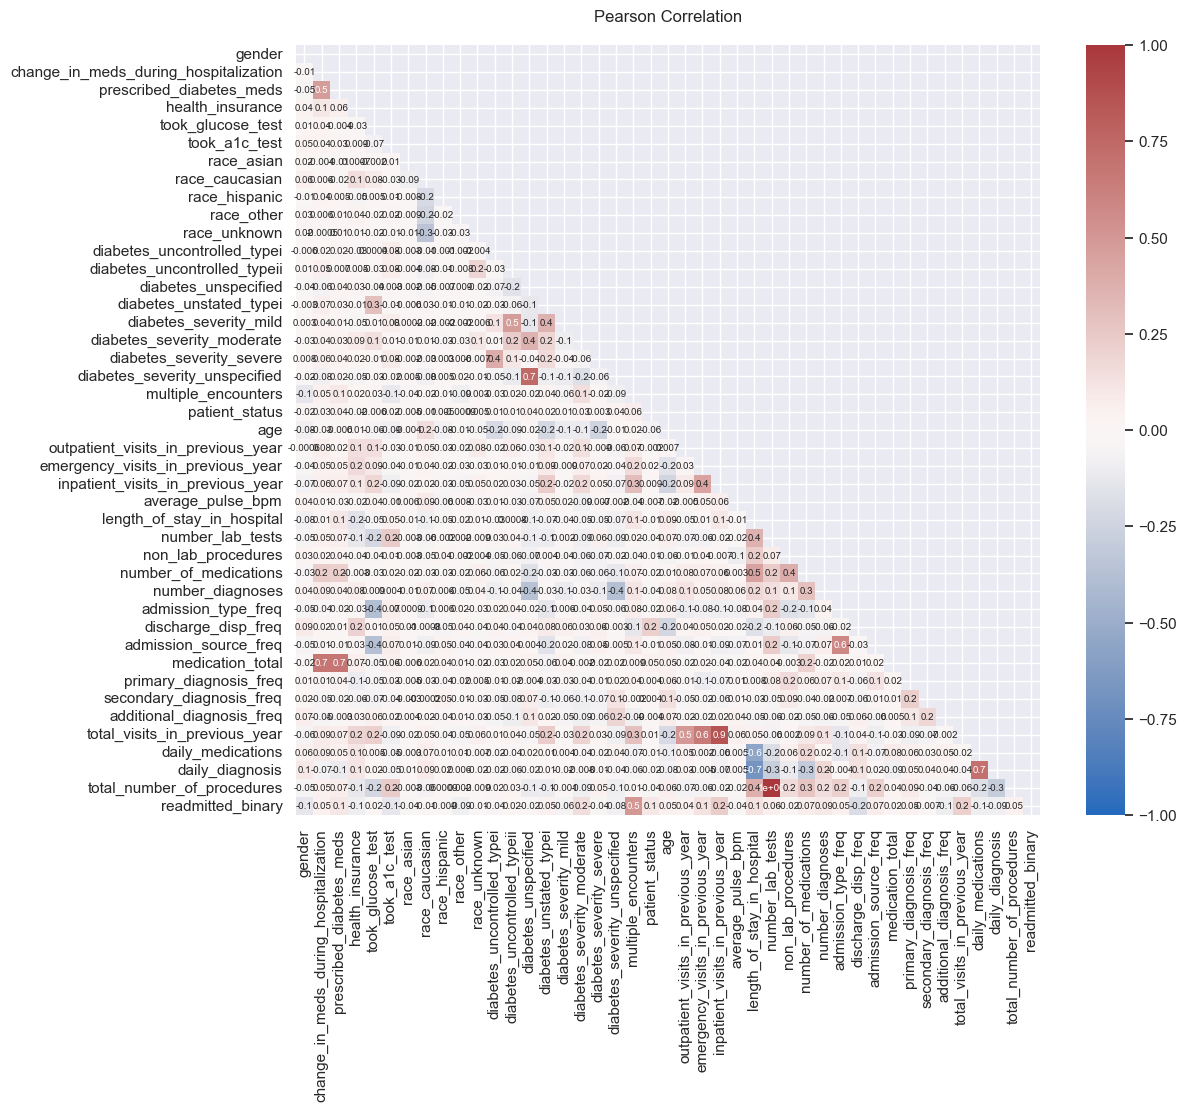

In [209]:
cor_heatmap(cor_pearson, "Pearson")

In [210]:
# Calculate the correlation matrix
correlation_matrix = X_corr.corr("pearson")

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")

High Correlation: change_in_meds_during_hospitalization and medication_total - Correlation: 0.6800204044751924
High Correlation: prescribed_diabetes_meds and medication_total - Correlation: 0.6779404358293601
High Correlation: diabetes_unspecified and diabetes_severity_unspecified - Correlation: 0.7404653960128454
High Correlation: inpatient_visits_in_previous_year and total_visits_in_previous_year - Correlation: 0.8533072931821108
High Correlation: length_of_stay_in_hospital and daily_diagnosis - Correlation: -0.6806157488478449
High Correlation: number_lab_tests and total_number_of_procedures - Correlation: 0.9963778470812924
High Correlation: daily_medications and daily_diagnosis - Correlation: 0.7071346245592044


Let's analyze what features from the identified pairs are more correlated with the target, since the one least correlated should be considered to to drop from our dataset.

In [211]:
# Last correlation analyzed:

correlation_matrix.loc['daily_medications', 'readmitted_binary'] > correlation_matrix.loc['daily_diagnosis', 'readmitted_binary']

False

### Spearman Correlation

In [212]:
cor_spearman = X_corr.corr("spearman")
cor_spearman

gender  \
gender                                 1.000000   
change_in_meds_during_hospitalization -0.010023   
prescribed_diabetes_meds              -0.045162   
health_insurance                       0.042907   
took_glucose_test                      0.013429   
took_a1c_test                          0.046540   
race_asian                             0.018226   
race_caucasian                         0.061467   
race_hispanic                         -0.012117   
race_other                             0.027898   
race_unknown                           0.024574   
diabetes_uncontrolled_typei           -0.005699   
diabetes_uncontrolled_typeii           0.014103   
diabetes_unspecified                  -0.044115   
diabetes_unstated_typei               -0.002639   
diabetes_severity_mild                 0.003195   
diabetes_severity_moderate            -0.029226   
diabetes_severity_severe               0.007854   
diabetes_severity_unspecified         -0.023235   
multiple_encounters                   -0.136660   
patient_status                        -0.016547   
age                                   -0.100991   
outpatient_visits_in_previous_year     0.031431   
emergency_visits_in_previous_year     -0.027190   
inpatient_visits_in_previous_year     -0.030143   
average_pulse_bpm                      0.034880   
length_of_stay_in_hospital            -0.073706   
number_lab_tests                      -0.040136   
non_lab_procedures                     0.029581   
number_of_medications                 -0.033868   
number_diagnoses                       0.018933   
admission_type_freq                   -0.047757   
discharge_disp_freq                    0.083847   
admission_source_freq                 -0.059779   
medication_total                      -0.025962   
primary_diagnosis_freq                 0.003556   
secondary_diagnosis_freq               0.016871   
additional_diagnosis_freq              0.066794   
total_visits_in_previous_year         -0.045968   
daily_medications                      0.069165   
daily_diagnosis                        0.098621   
total_number_of_procedures            -0.036651   
readmitted_binary                     -0.136817   

                                       change_in_meds_during_hospitalization  \
gender                                                             -0.010023   
change_in_meds_during_hospitalization                               1.000000   
prescribed_diabetes_meds                                            0.471145   
health_insurance                                                    0.106923   
took_glucose_test                                                   0.035481   
took_a1c_test                                                       0.037933   
race_asian                                                         -0.004270   
race_caucasian                                                      0.006103   
race_hispanic                                                       0.038981   
race_other                                                          0.006331   
race_unknown                                                       -0.000526   
diabetes_uncontrolled_typei                                         0.019406   
diabetes_uncontrolled_typeii                                        0.054913   
diabetes_unspecified                                               -0.062512   
diabetes_unstated_typei                                             0.065034   
diabetes_severity_mild                                              0.036542   
diabetes_severity_moderate                                          0.043246   
diabetes_severity_severe                                            0.058796   
diabetes_severity_unspecified                                      -0.081286   
multiple_encounters                                                 0.051587   
patient_status                                                      0.030114   
age                                 

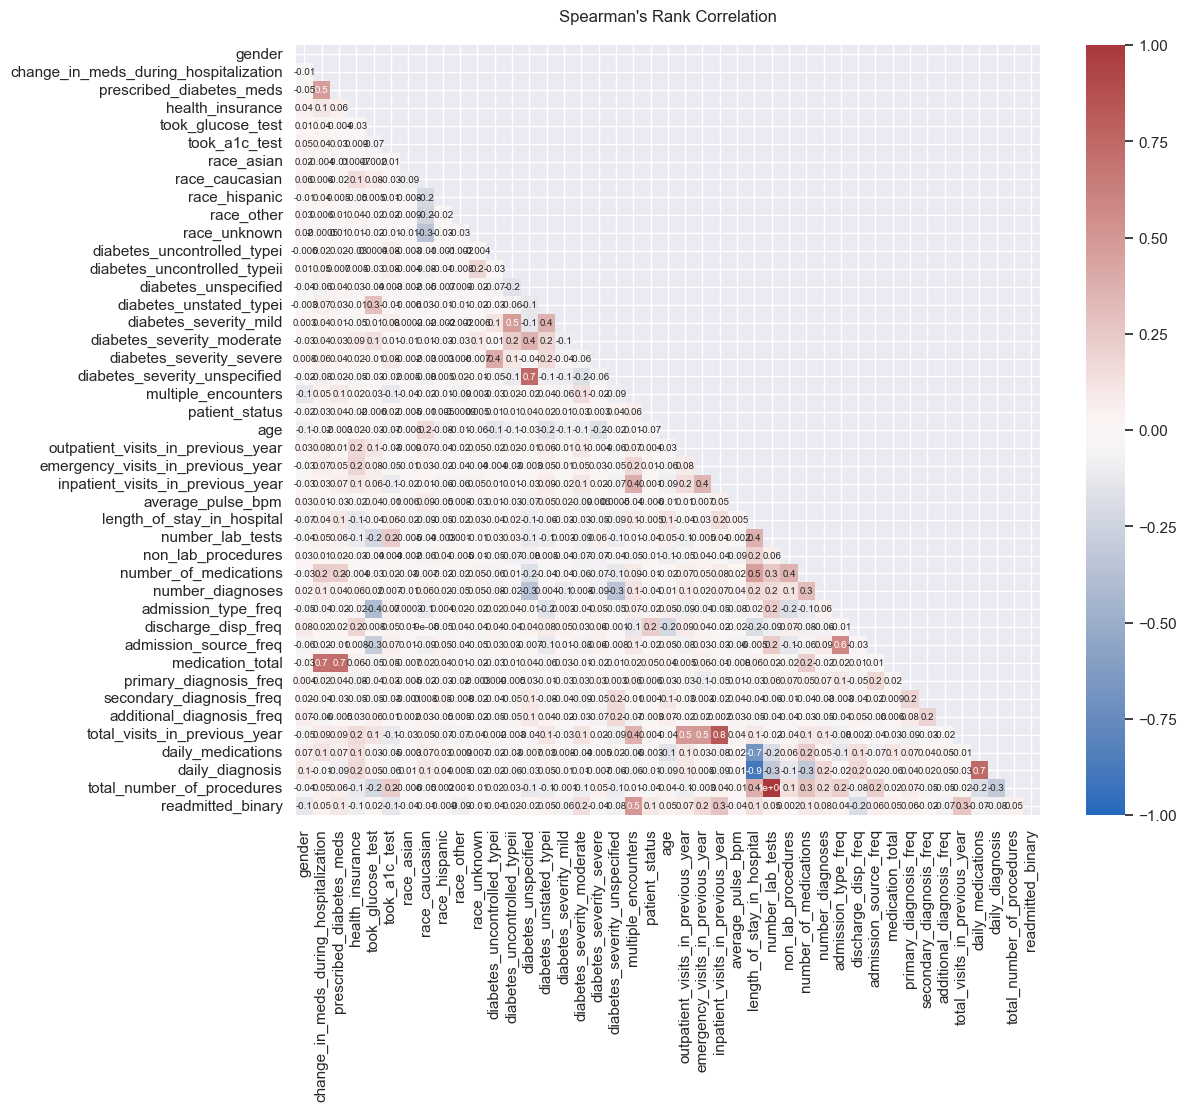

In [213]:
cor_heatmap(cor_spearman, "Spearman's Rank")

In [214]:
# Calculate the correlation matrix
correlation_matrix = X_corr.corr("spearman")

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")

High Correlation: change_in_meds_during_hospitalization and medication_total - Correlation: 0.7073239438818925
High Correlation: prescribed_diabetes_meds and medication_total - Correlation: 0.7214120233998668
High Correlation: diabetes_unspecified and diabetes_severity_unspecified - Correlation: 0.7404653960128594
High Correlation: inpatient_visits_in_previous_year and total_visits_in_previous_year - Correlation: 0.8399195263460927
High Correlation: length_of_stay_in_hospital and daily_medications - Correlation: -0.6929607802840608
High Correlation: length_of_stay_in_hospital and daily_diagnosis - Correlation: -0.8964802524945508
High Correlation: number_lab_tests and total_number_of_procedures - Correlation: 0.995570857267494
High Correlation: daily_medications and daily_diagnosis - Correlation: 0.7364438417592315


As before, all pairs are analyzed to determine which features are more correlated with the target from those with high correlation between them.

In [215]:
# Last correlation analyzed:

correlation_matrix.loc['daily_medications', 'readmitted_binary'] > correlation_matrix.loc['daily_diagnosis', 'readmitted_binary']

True

### ANOVA

In [201]:
anova = SelectKBest(f_classif, k = 25)
X_anova = anova.fit_transform(X_train_bin, y_train_bin)
important_features = pd.Series(anova.get_support(), index = X_train_bin.columns)
important_features

gender                                    True
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                  True
health_insurance                          True
took_glucose_test                        False
took_a1c_test                             True
race_asian                               False
race_caucasian                           False
race_hispanic                            False
race_other                                True
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                    True
diabetes_severity_moderate                True
diabetes_severity_severe                 False
diabetes_severity_unspecified             True
multiple_encounters                       True
patient_status                            True
age          

### Decision Tree

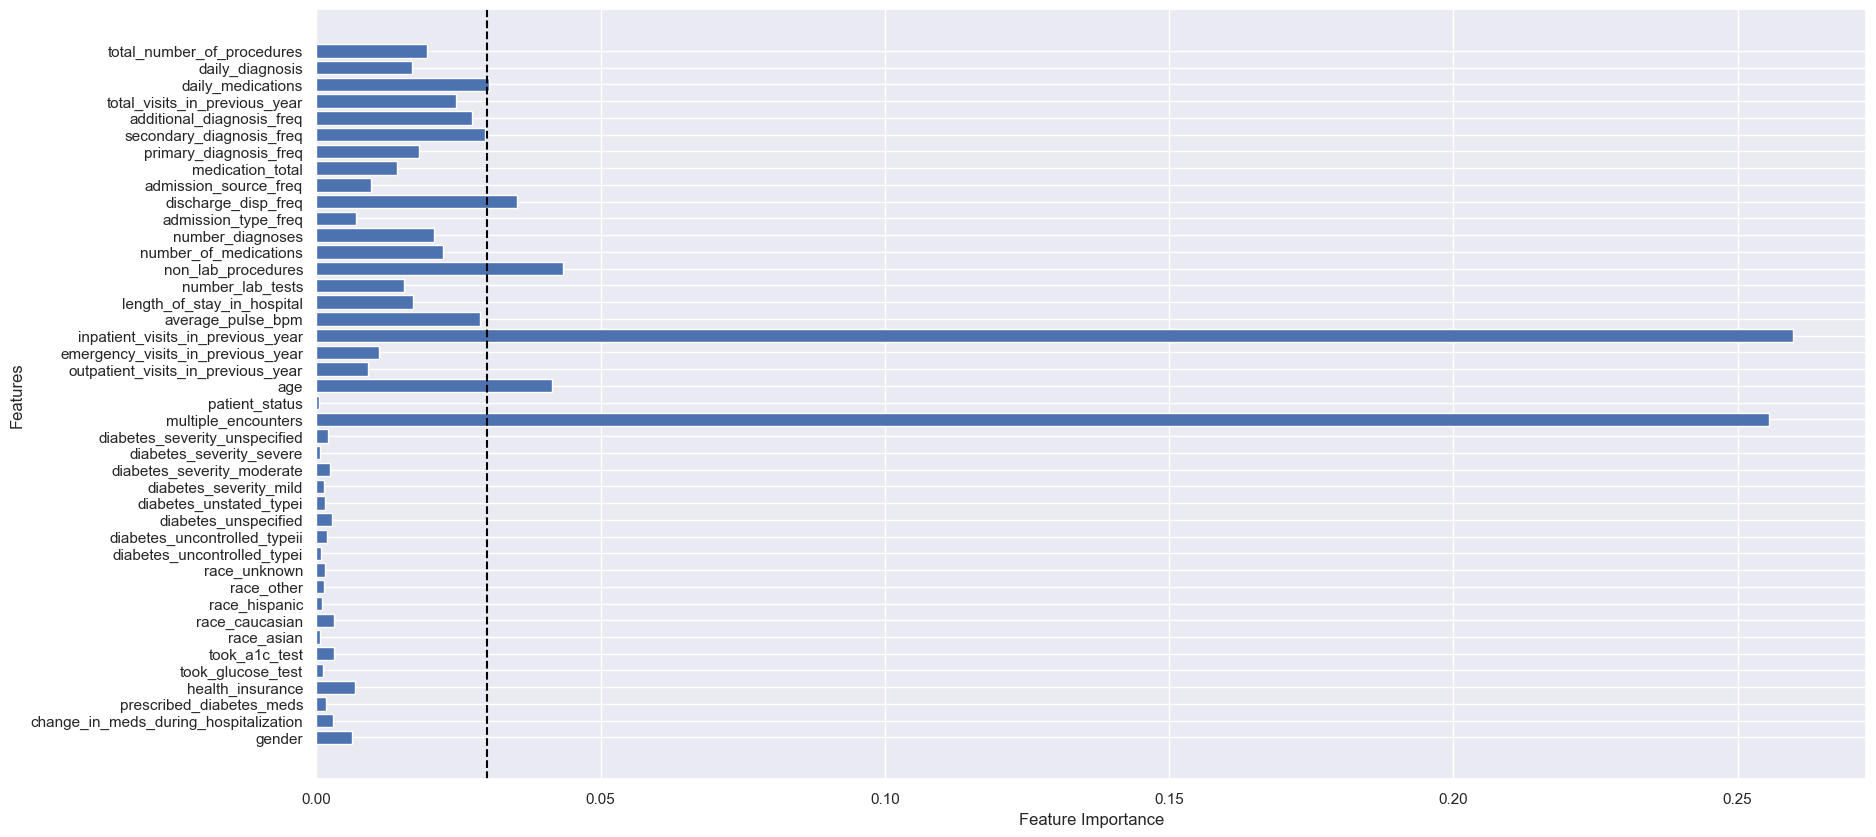

In [200]:
modelDT = DecisionTreeClassifier(random_state = 2023)

modelDT.fit(X_train_bin, y_train_bin)

modelDT.feature_importances_
def plot_feature_importances(modelDT):
    n_features = X_train_bin.shape[1]
    plt.figure(figsize = (20,10))
    plt.barh(range(n_features), modelDT.feature_importances_, align = 'center')
    plt.axvline(x = 0.03, color = "black", linestyle = "--")
    plt.yticks(np.arange(n_features), X_train_bin.columns)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.show()

plot_feature_importances(modelDT)

### Random Forest

In [202]:
forest_fs = RandomForestClassifier(n_estimators = 500, random_state = 2023)

forest_fs.fit(X_train_bin, y_train_bin)
importances = forest_fs.feature_importances_

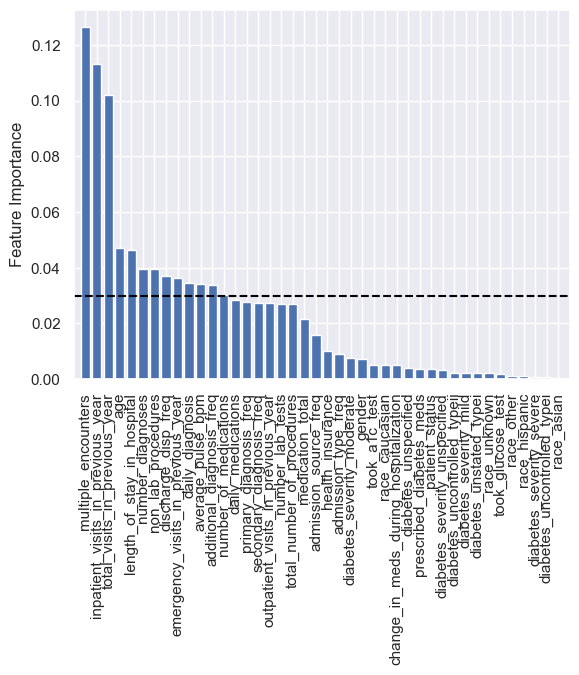

In [203]:
indices = np.argsort(importances)[::-1]

plt.bar(range(X_train_bin.shape[1]), importances[indices], align = "center")
plt.ylabel("Feature Importance")

feat_labels = X_train_bin.columns
plt.xticks(range(X_train_bin.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train_bin.shape[1]])

plt.axhline(y = 0.03, color = "black", linestyle = "--")

plt.show()

### RFE Logistic Regression

In [216]:
X_train_bin.shape

(88600, 42)

Optimum number of features: 11
Score with 11 features: 0.288556
Features to select: 
gender                                   False
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                 False
health_insurance                         False
took_glucose_test                        False
took_a1c_test                             True
race_asian                                True
race_caucasian                           False
race_hispanic                            False
race_other                                True
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate                True
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

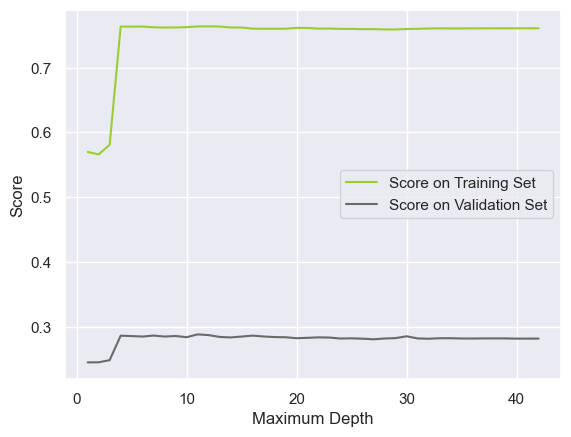

CPU times: total: 43min 6s
Wall time: 43min 32s


In [217]:
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    rfe_model = LogisticRegression(solver = 'saga', penalty = 'l1', C = 0.5, random_state = 2023)

    rfe = RFE(estimator = rfe_model, n_features_to_select = nof_list[n])

    X_train_rfe = rfe.fit_transform(X_train_bin, y_train_bin)
    X_val_rfe = rfe.transform(X_val_bin)

    rfe_model.fit(X_train_rfe, y_train_bin)

    #storing results on training data
    rfe_labels_train = rfe_model.predict(X_train_rfe)
    train_score = f1_score(y_train_bin, rfe_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    rfe_labels_val = rfe_model.predict(X_val_rfe)
    val_score = f1_score(y_val_bin, rfe_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = rfe.support_, index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

### RFE Support Vector Classifier - Linear

Optimum number of features: 12
Score with 12 features: 0.286167
Features to select: 
gender                                   False
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                 False
health_insurance                         False
took_glucose_test                        False
took_a1c_test                             True
race_asian                                True
race_caucasian                           False
race_hispanic                            False
race_other                                True
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate                True
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

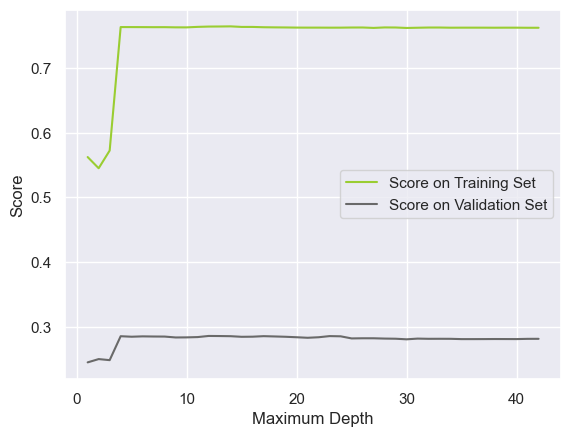

CPU times: total: 1h 28min 9s
Wall time: 1h 28min 28s


In [218]:
%%time
#no of features
nof_list=np.arange(1, 43)
high_score=0
#Variable to store the optimum features
nof=0
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    #call support vector machines classifier
    rfe_model = rfe_model = LinearSVC(penalty = 'l1', C = 0.5, dual = False, random_state = 2023)

    #create RFE instance
    rfe = RFE(estimator = rfe_model, n_features_to_select = nof_list[n])

    #fit and transform for training data, transform for val data
    X_train_rfe = rfe.fit_transform(X_train_bin,y_train_bin)
    X_val_rfe = rfe.transform(X_val_bin)

    rfe_model.fit(X_train_rfe,y_train_bin)

    #storing results on training data
    rfe_labels_train = rfe_model.predict(X_train_rfe)
    train_score = f1_score(y_train_bin, rfe_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    rfe_labels_val = rfe_model.predict(X_val_rfe)
    val_score = f1_score(y_val_bin, rfe_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score > high_score):
        high_score = val_score
        nof = nof_list[n]

        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lasso

Lasso picked 35 variables and eliminated the other 7 variables


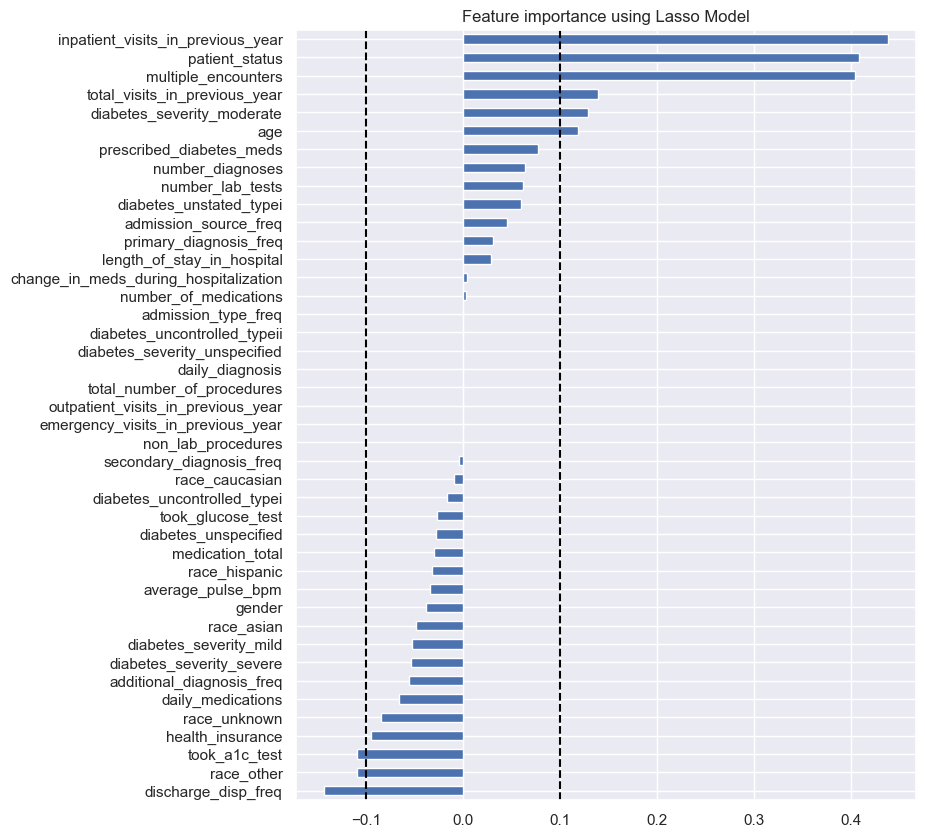

In [204]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (8,10))
    imp_coef.plot(kind = "barh")
    plt.axvline(x = 0.1, color = "black", linestyle = "--")
    plt.axvline(x = -0.1, color = "black", linestyle = "--")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV(random_state = 2023)

reg.fit(X_train_bin, y_train_bin)

coef = pd.Series(data = reg.coef_, index = X_train_bin.columns)
coef

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

coef.sort_values()

plot_importance(coef, "Lasso")

### Dropping Variables

The results of all methods used were combined in a table, where we decided to keep in our dataset all the features that were voted to discard by at least 5 of the 8 models used.

In [457]:
excel_path = "Variable Selection.xlsx"
sheet_name = "Final_Binary"
wb = load_workbook(excel_path)
sheet = wb[sheet_name]

df = pd.DataFrame(sheet.values, columns=[cell.value for cell in sheet[1]])

def highlight_cell(val, column):
    if 'Result' in column:
        return 'background-color: #FFFF66' if val == 'Keep' else ''
    elif val == "Keep":
        return 'background-color: #99FF99'
    elif val == "Discard":
        return 'background-color: #FF8989'
    return ""

styled_df = df.style.apply(lambda row: [highlight_cell(val, column) for val, column in zip(row, df.columns)], axis=1)

styled_df.hide(0)

In [220]:
# Checkpoint if we wish to select different features for our models. Also, it ensures that we are using the correct values for the features.
X_train_bin_copy = X_train_bin.copy()
X_val_bin_copy = X_val_bin.copy()
test_bin_copy = test_bin.copy()

In [221]:
selected_features = ['took_a1c_test', 'race_hispanic', 'discharge_disp_freq', 'diabetes_severity_moderate', 'multiple_encounters', 'patient_status',
                     'age', 'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital', 'non_lab_procedures', 'number_diagnoses']

In [222]:
X_train_bin_copy = X_train_bin[selected_features].copy()
X_val_bin_copy = X_val_bin[selected_features].copy()
test_bin_copy = test_bin[selected_features].copy()

In [223]:
X_train_bin_copy.head().T

0         1         2         3  \
took_a1c_test                      0.000000  0.000000  0.000000  0.000000   
race_hispanic                      0.000000  0.000000  0.000000  0.000000   
discharge_disp_freq                1.000000  1.000000  1.000000  1.000000   
diabetes_severity_moderate         0.000000  0.000000  0.000000  0.000000   
multiple_encounters                0.000000  0.000000  0.000000  1.000000   
patient_status                     1.000000  1.000000  1.000000  1.000000   
age                                0.777778  0.555556  0.888889  0.555556   
inpatient_visits_in_previous_year  0.142857  0.000000  0.000000  0.000000   
length_of_stay_in_hospital         0.153846  0.307692  0.000000  0.076923   
non_lab_procedures                 0.000000  0.000000  1.000000  0.000000   
number_diagnoses                   0.533333  0.533333  0.533333  0.333333   

                                          4  
took_a1c_test                      0.000000  
race_hispanic                      0.000000  
discharge_disp_freq                1.000000  
diabetes_severity_moderate         0.000000  
multiple_encounters                0.000000  
patient_status                     1.000000  
age                                0.777778  
inpatient_visits_in_previous_year  0.095238  
length_of_stay_in_hospital         0.307692  
non_lab_procedures                 0.333333  
number_diagnoses                   0.533333

## <font color='#238278'>Best Model Selection</font> <a class="anchor" id="modelbin"></a>
[Back to Contents](#toc)

In [224]:
def metrics(y_train, pred_train, y_val, pred_val):
    print('            TRAINING SCORES              ')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print('_________________________________________')
    print('            VALIDATION SCORES            ')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

### Logistic Regression

In [225]:
#model = LogisticRegression(random_state = 0)
#parameter_space_logR = {'penalty': ['l1', 'l2', 'elasticnet'],
#                        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                        'solver': ['lbfgs', 'liblinear', 'saga', 'sag'],
#                        'max_iter': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}

#grid_logR = GridSearchCV(model, parameter_space_logR, scoring = 'f1', verbose = 4, cv = 10)
#grid_logR.fit(X_train_bin_copy, y_train_bin)

#print('Best parameters:', grid_logR.best_params_)
#print('Best F1Score:', grid_logR.best_score_)

Best parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [226]:
logR_model = LogisticRegression(C = 10, max_iter = 100, penalty = "l2", solver = "liblinear", random_state = 0)
logR_model.fit(X_train_bin_copy, y_train_bin)

LogisticRegression(C=10, random_state=0, solver='liblinear')

In [227]:
logR_labels_train = logR_model.predict(X_train_bin_copy)
logR_labels_val = logR_model.predict(X_val_bin_copy)

In [228]:
metrics(y_train_bin, logR_labels_train, y_val_bin, logR_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[32227 12073]
 [ 9494 34806]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.84      0.87     18986
           1       0.23      0.39      0.29      2385

    accuracy                           0.79     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.79      0.81     21371

[[15869  3117]
 [ 1458   927]]


In [229]:
f1_logR = f1_score(y_val_bin, logR_labels_val)
print(f1_logR)

0.2883807746150257


In [230]:
accuracy_logR = accuracy_score(y_val_bin, logR_labels_val)
roc_logR = roc_auc_score(y_val_bin, logR_labels_val)
precision_logR = precision_score(y_val_bin, logR_labels_val)
recall_logR = recall_score(y_val_bin, logR_labels_val)

In [231]:
'''
logR_labels_test = logR_model.predict(test_bin_copy)
logR_labels_test_list = logR_labels_test.tolist()
logR_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in logR_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = logR_labels_test_list
submission.to_csv("submissions/Group14_Version90.csv", index = "encounter_id")
'''

'\nlogR_labels_test = logR_model.predict(test_bin_copy)\nlogR_labels_test_list = logR_labels_test.tolist()\nlogR_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in logR_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = logR_labels_test_list\nsubmission.to_csv("submissions/Group14_Version90.csv", index = "encounter_id")\n'

### Neural Networks

In [232]:
nn_model = MLPClassifier(solver = 'adam', learning_rate = 'constant', activation = 'logistic', alpha = 0.001,
                         hidden_layer_sizes = 100, batch_size = 500, random_state = 0)
nn_model.fit(X_train_bin_copy, y_train_bin)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=500,
              hidden_layer_sizes=100, random_state=0)

In [233]:
nn_labels_train = nn_model.predict(X_train_bin_copy)
nn_labels_val = nn_model.predict(X_val_bin_copy)

In [234]:
metrics(y_train_bin, nn_labels_train, y_val_bin, nn_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     44300
           1       0.74      0.80      0.77     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[32124 12176]
 [ 8843 35457]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     18986
           1       0.23      0.44      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.62      0.58     21371
weighted avg       0.84      0.77      0.80     21371

[[15421  3565]
 [ 1344  1041]]


In [235]:
f1_nn = f1_score(y_val_bin, nn_labels_val)
print(f1_nn)

0.2978114718924332


In [236]:
accuracy_nn = accuracy_score(y_val_bin, nn_labels_val)
roc_nn = roc_auc_score(y_val_bin, nn_labels_val)
precision_nn = precision_score(y_val_bin, nn_labels_val)
recall_nn = recall_score(y_val_bin, nn_labels_val)

In [237]:
'''
nn_test = nn_model.predict(test_bin_copy)
nn_labels_test_list = nn_test.tolist()
nn_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in nn_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = nn_labels_test_list
submission.to_csv("submissions/Group14_Version107.csv", index = "encounter_id")
'''

'\nnn_test = nn_model.predict(test_bin_copy)\nnn_labels_test_list = nn_test.tolist()\nnn_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in nn_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = nn_labels_test_list\nsubmission.to_csv("submissions/Group14_Version107.csv", index = "encounter_id")\n'

### Gaussian Naïve Bayes

In [238]:
gnb_model = GaussianNB(var_smoothing = 0.3)
gnb_model.fit(X_train_bin_copy, y_train_bin)

GaussianNB(var_smoothing=0.3)

In [239]:
gnb_labels_train = gnb_model.predict(X_train_bin_copy)
gnb_labels_val = gnb_model.predict(X_val_bin_copy)

In [240]:
metrics(y_train_bin, gnb_labels_train, y_val_bin, gnb_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     44300
           1       0.74      0.78      0.76     44300

    accuracy                           0.75     88600
   macro avg       0.75      0.75      0.75     88600
weighted avg       0.75      0.75      0.75     88600

[[32155 12145]
 [ 9792 34508]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.22      0.40      0.29      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.78      0.80     21371

[[15720  3266]
 [ 1441   944]]


In [241]:
f1_gnb = f1_score(y_val_bin, gnb_labels_val)
print(f1_gnb)

0.28627748294162236


In [242]:
accuracy_gnb = accuracy_score(y_val_bin, gnb_labels_val)
roc_gnb = roc_auc_score(y_val_bin, gnb_labels_val)
precision_gnb = precision_score(y_val_bin, gnb_labels_val)
recall_gnb = recall_score(y_val_bin, gnb_labels_val)

In [243]:
'''
gnb_test = gnb_model.predict(test_bin_copy)
gnb_labels_test_list = gnb_test.tolist()
gnb_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in gnb_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = gnb_labels_test_list
submission.to_csv("submissions/Group14_Version130.csv", index = "encounter_id")
'''

'\ngnb_test = gnb_model.predict(test_bin_copy)\ngnb_labels_test_list = gnb_test.tolist()\ngnb_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in gnb_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = gnb_labels_test_list\nsubmission.to_csv("submissions/Group14_Version130.csv", index = "encounter_id")\n'

### Bernoulli Naïve Bayes

In [244]:
bnb_model = BernoulliNB(binarize = 0.05)
bnb_model.fit(X_train_bin_copy, y_train_bin)

BernoulliNB(binarize=0.05)

In [245]:
bnb_labels_train = bnb_model.predict(X_train_bin_copy)
bnb_labels_val = bnb_model.predict(X_val_bin_copy)

In [246]:
metrics(y_train_bin, bnb_labels_train, y_val_bin, bnb_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[32307 11993]
 [ 9457 34843]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     18986
           1       0.23      0.42      0.30      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.62      0.58     21371
weighted avg       0.84      0.78      0.80     21371

[[15600  3386]
 [ 1379  1006]]


In [247]:
f1_bnb = f1_score(y_val_bin, bnb_labels_val)
print(f1_bnb)

0.2968865279622252


In [248]:
accuracy_bnb = accuracy_score(y_val_bin, bnb_labels_val)
roc_bnb = roc_auc_score(y_val_bin, bnb_labels_val)
precision_bnb = precision_score(y_val_bin, bnb_labels_val)
recall_bnb = recall_score(y_val_bin, bnb_labels_val)

In [249]:
'''
bnb_test = bnb_model.predict(test_bin_copy)
bnb_labels_test_list = bnb_test.tolist()
bnb_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in bnb_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = bnb_labels_test_list
submission.to_csv("submissions/Group14_Version86.csv", index = "encounter_id")
'''

'\nbnb_test = bnb_model.predict(test_bin_copy)\nbnb_labels_test_list = bnb_test.tolist()\nbnb_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in bnb_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = bnb_labels_test_list\nsubmission.to_csv("submissions/Group14_Version86.csv", index = "encounter_id")\n'

### Decision Tree Classifier

In [250]:
#model = DecisionTreeClassifier(random_state = 18)

#parameter_space_dtc = {
#    'criterion': ['gini', 'entropy'],
#    'splitter': ['best', 'random'],
#    'max_depth': [None, 3, 6, 9, 12, 15],
#    'min_samples_split': [2, 10, 20, 50, 100, 500, 1000],
#    'min_samples_leaf': [1, 10, 50, 100, 200, 500],
#    'max_features': [None, 0.1, 0.3, 0.5, 'sqrt', 'log2'],
#    'max_leaf_nodes': [None, 5, 10, 20, 30],
#    'min_impurity_decrease': [0, 0.01, 0.05]
#}

#grid_dtc = GridSearchCV(model, parameter_space_dtc, scoring = "f1", verbose = 4)
#grid_dtc.fit(X_train_bin_copy, y_train_bin)

#print("Best parameters:", grid_dtc.best_params_)
#print("Best F1Score:", grid_dtc.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0, 'min_samples_leaf': 100, 'min_samples_split': 1000, 'splitter': 'best'}

In [251]:
dtc_model = DecisionTreeClassifier(criterion = "gini", max_depth = None, max_features = 0.3, max_leaf_nodes = 20,
                                  min_impurity_decrease = 0, min_samples_leaf = 100, min_samples_split = 1000,
                                  splitter = "best", random_state = 18)
dtc_model.fit(X_train_bin_copy, y_train_bin)

DecisionTreeClassifier(max_features=0.3, max_leaf_nodes=20,
                       min_impurity_decrease=0, min_samples_leaf=100,
                       min_samples_split=1000, random_state=18)

In [252]:
dtc_labels_train = dtc_model.predict(X_train_bin_copy)
dtc_labels_val = dtc_model.predict(X_val_bin_copy)

In [253]:
metrics(y_train_bin, dtc_labels_train, y_val_bin, dtc_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     44300
           1       0.75      0.79      0.77     44300

    accuracy                           0.77     88600
   macro avg       0.77      0.77      0.77     88600
weighted avg       0.77      0.77      0.77     88600

[[32876 11424]
 [ 9127 35173]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     18986
           1       0.22      0.37      0.27      2385

    accuracy                           0.78     21371
   macro avg       0.56      0.60      0.57     21371
weighted avg       0.84      0.78      0.80     21371

[[15799  3187]
 [ 1508   877]]


In [254]:
f1_dtc = f1_score(y_val_bin, dtc_labels_val)
print(f1_dtc)

0.2719801519615444


#### Decision Tree Classifier - Postpruning

In [255]:
path = dtc_model.cost_complexity_pruning_path(X_train_bin_copy, y_train_bin)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

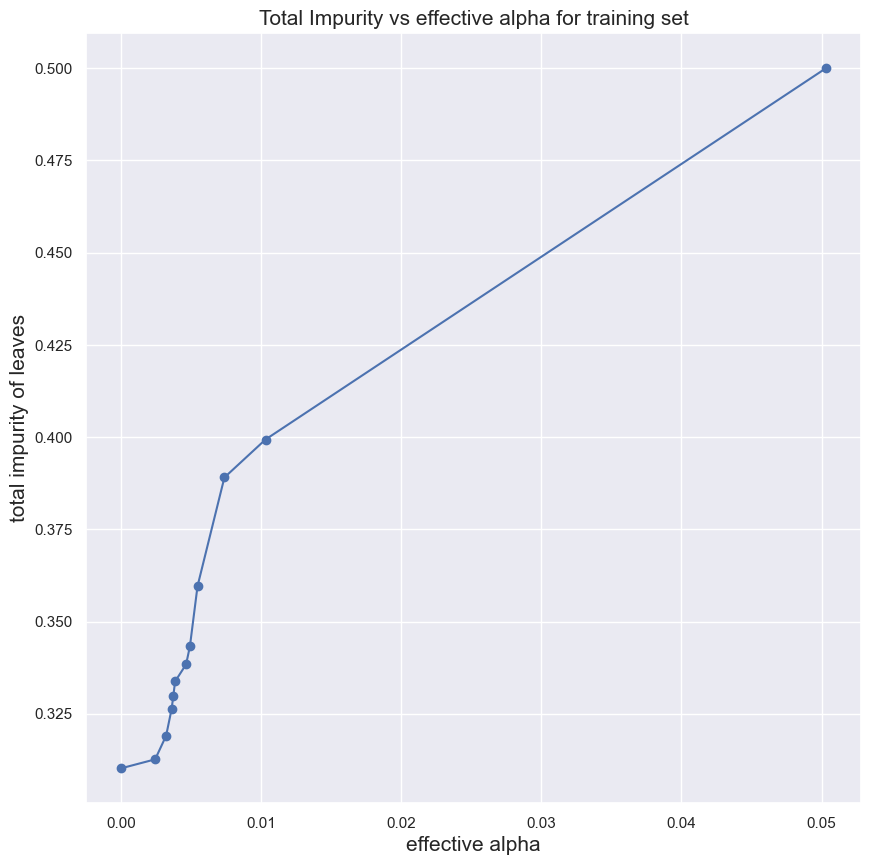

In [256]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas, impurities, marker='o')
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

In [257]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(criterion = "gini", max_depth = None, max_features = 0.3, max_leaf_nodes = 20,
                                  min_impurity_decrease = 0, min_samples_leaf = 100, min_samples_split = 1000,
                                  splitter = "best", random_state = 18, ccp_alpha=ccp_alpha).fit(X_train_bin_copy, y_train_bin)
    trees.append(dt_alpha)

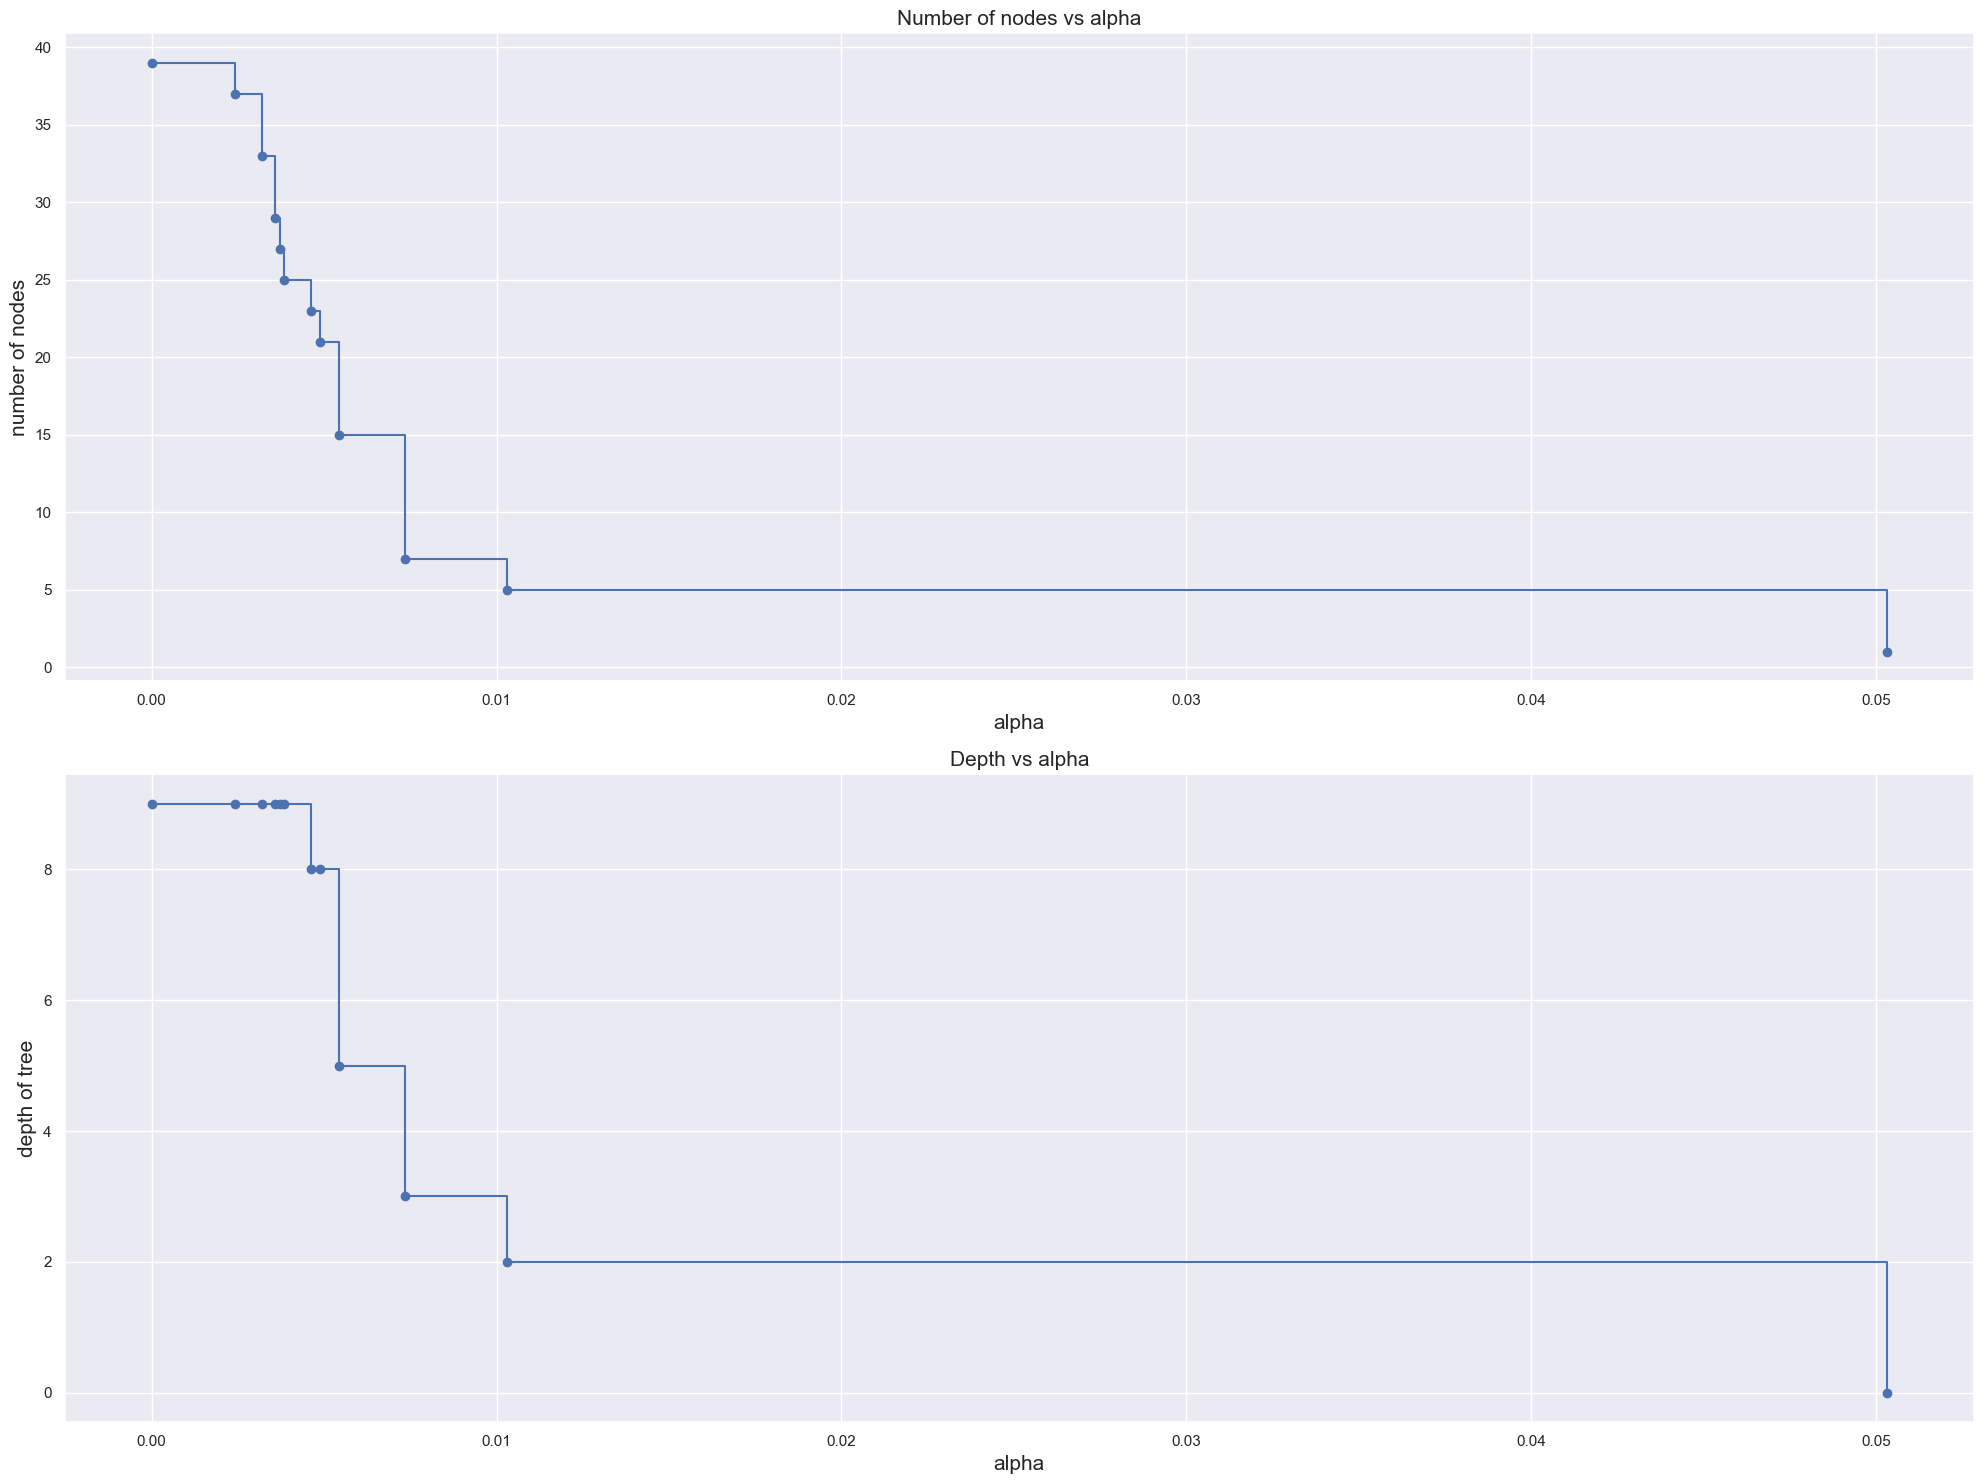

In [258]:
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.get_depth() for tree in trees]

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha", fontsize=15)
ax[0].set_ylabel("number of nodes", fontsize=15)
ax[0].set_title("Number of nodes vs alpha", fontsize=15)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=15)
ax[1].set_ylabel("depth of tree", fontsize=15)
ax[1].set_title("Depth vs alpha", fontsize=15)
fig.tight_layout()

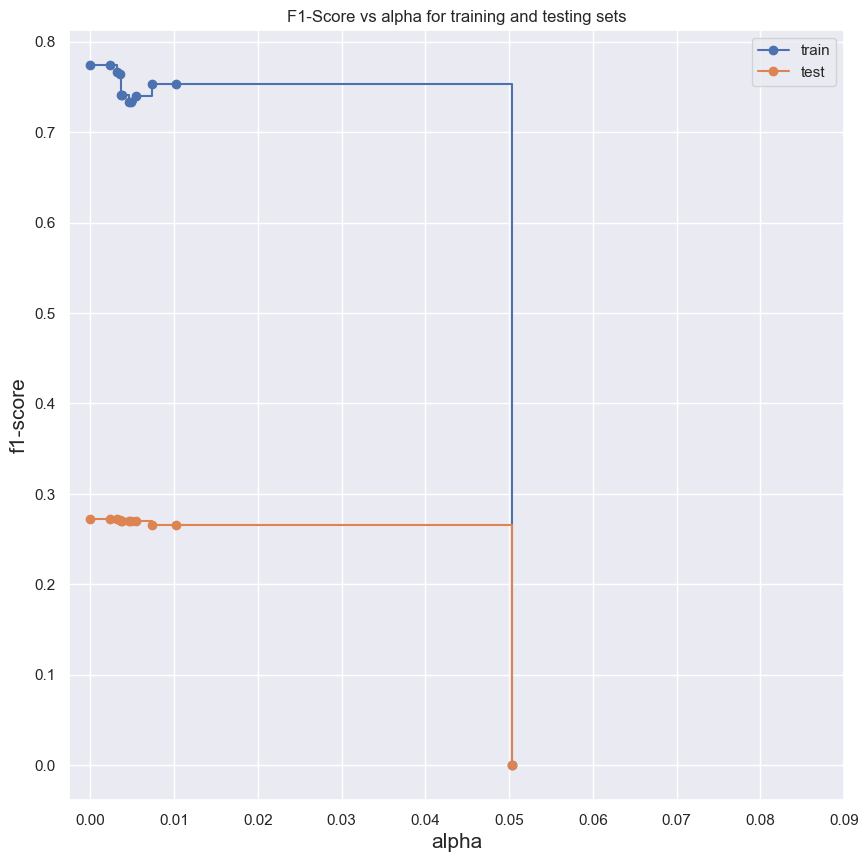

In [259]:
train_f1_scores = [f1_score(y_train_bin, tree.predict(X_train_bin_copy)) for tree in trees]
val_f1_scores = [f1_score(y_val_bin, tree.predict(X_val_bin_copy)) for tree in trees]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("f1-score", fontsize=15)
ax.set_title("F1-Score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_f1_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_f1_scores, marker='o', label="test", drawstyle="steps-post")
plt.xticks(np.arange(0,0.1,0.01))
ax.legend()
plt.show()

In [260]:
index_best_model = np.argmax(val_f1_scores)
best_model = trees[index_best_model]

f1_dtc_alpha_train = f1_score(y_train_bin, best_model.predict(X_train_bin_copy))
f1_dtc_alpha_val = f1_score(y_val_bin, best_model.predict(X_val_bin_copy))

print('ccp_alpha of best model: ', best_model.ccp_alpha)
print('_____________________________________________________________')
print('F1-Score of best model (train): ', f1_dtc_alpha_train)
print('F1-Score of best model (val): ', f1_dtc_alpha_val)

ccp_alpha of best model:  0.0
_____________________________________________________________
F1-Score of best model (train):  0.7739089298876749
F1-Score of best model (val):  0.2719801519615444


In [261]:
dtc_model = DecisionTreeClassifier(criterion = "gini", max_depth = None, max_features = 0.3, max_leaf_nodes = 20,
                                  min_impurity_decrease = 0, min_samples_leaf = 100, min_samples_split = 1000,
                                  splitter = "best", random_state = 18, ccp_alpha = best_model.ccp_alpha)
dtc_model.fit(X_train_bin_copy, y_train_bin)

DecisionTreeClassifier(max_features=0.3, max_leaf_nodes=20,
                       min_impurity_decrease=0, min_samples_leaf=100,
                       min_samples_split=1000, random_state=18)

In [262]:
dtc_labels_train = dtc_model.predict(X_train_bin_copy)
dtc_labels_val = dtc_model.predict(X_val_bin_copy)

In [263]:
metrics(y_train_bin, dtc_labels_train, y_val_bin, dtc_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     44300
           1       0.75      0.79      0.77     44300

    accuracy                           0.77     88600
   macro avg       0.77      0.77      0.77     88600
weighted avg       0.77      0.77      0.77     88600

[[32876 11424]
 [ 9127 35173]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     18986
           1       0.22      0.37      0.27      2385

    accuracy                           0.78     21371
   macro avg       0.56      0.60      0.57     21371
weighted avg       0.84      0.78      0.80     21371

[[15799  3187]
 [ 1508   877]]


In [264]:
f1_dtc = f1_score(y_val_bin, dtc_labels_val)
print(f1_dtc)

0.2719801519615444


In [265]:
accuracy_dtc = accuracy_score(y_val_bin, dtc_labels_val)
roc_dtc = roc_auc_score(y_val_bin, dtc_labels_val)
precision_dtc = precision_score(y_val_bin, dtc_labels_val)
recall_dtc = recall_score(y_val_bin, dtc_labels_val)

In [266]:
'''
dtc_test = dtc_model.predict(test_bin_copy)
dtc_labels_test_list = dtc_test.tolist()
dtc_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in dtc_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = dtc_labels_test_list
submission.to_csv("submissions/Group14_Version89.csv", index = "encounter_id")
'''

'\ndtc_test = dtc_model.predict(test_bin_copy)\ndtc_labels_test_list = dtc_test.tolist()\ndtc_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in dtc_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = dtc_labels_test_list\nsubmission.to_csv("submissions/Group14_Version89.csv", index = "encounter_id")\n'

We weren't able to get anything more out of postpruning, and we end up with a f1-score of around 0.27198 for our Decision Trees.

### Support Vector Classifiers

In [267]:
#model = SVC(random_state = 0)

#parameter_space_svc = {'C': [0.01, 0.1, 0.5, 1, 10],
#                       'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#                       'gamma': ['scale', 'auto', 0.001, 0.01, 1, 10]} #0.1 would be very similar to "scale"

#random_svc = RandomizedSearchCV(model, parameter_space_svc, scoring = "f1", verbose = 4)
#random_svc.fit(X_train_bin_copy, y_train_bin)

#print("Best parameters:", random_svc.best_params_)
#print("Best F1Score:", random_svc.best_score_)

Best parameters: {'kernel': 'poly', 'gamma': 1, 'C': 1}

In [268]:
svc_model = SVC(kernel = 'poly', degree = 3, gamma = 1, class_weight = 'balanced', random_state = 0)
svc_model.fit(X_train_bin_copy, y_train_bin)

SVC(class_weight='balanced', gamma=1, kernel='poly', random_state=0)

In [269]:
svc_labels_train = svc_model.predict(X_train_bin_copy)
svc_labels_val = svc_model.predict(X_val_bin_copy)

In [270]:
metrics(y_train_bin, svc_labels_train, y_val_bin, svc_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     44300
           1       0.76      0.79      0.77     44300

    accuracy                           0.77     88600
   macro avg       0.77      0.77      0.77     88600
weighted avg       0.77      0.77      0.77     88600

[[33085 11215]
 [ 9459 34841]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     18986
           1       0.24      0.37      0.29      2385

    accuracy                           0.80     21371
   macro avg       0.58      0.61      0.58     21371
weighted avg       0.84      0.80      0.81     21371

[[16125  2861]
 [ 1500   885]]


In [271]:
f1_svc = (f1_score(y_val_bin, svc_labels_val))
f1_svc

0.28869678682107325

In [272]:
accuracy_svc = accuracy_score(y_val_bin, svc_labels_val)
roc_svc = roc_auc_score(y_val_bin, svc_labels_val)
precision_svc = precision_score(y_val_bin, svc_labels_val)
recall_svc = recall_score(y_val_bin, svc_labels_val)

In [273]:
'''
svc_test = svc_model.predict(test_bin_copy)
svc_labels_test_list = svc_test.tolist()
svc_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in svc_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = svc_labels_test_list
submission.to_csv("submissions/Group14_Version109.csv", index = "encounter_id")
'''

'\nsvc_test = svc_model.predict(test_bin_copy)\nsvc_labels_test_list = svc_test.tolist()\nsvc_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in svc_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = svc_labels_test_list\nsubmission.to_csv("submissions/Group14_Version109.csv", index = "encounter_id")\n'

In [274]:
#model = LinearSVC(dual = "auto", random_state = 0)

#parameter_space_svcl = {'penalty': ['l1', 'l2'],
#                        'C': [0.01, 0.1, 0.5, 1, 10, 100],
#                        'intercept_scaling': [0.001, 0.01, 0.1, 1, 10, 100]}

#grid_svcl = GridSearchCV(model, parameter_space_svcl, scoring = "f1", verbose = 4)
#grid_svcl.fit(X_train_bin_copy, y_train_bin)

#print("Best parameters:", grid_svcl.best_params_)
#print("Best F1Score:", grid_svcl.best_score_)

Best parameters: {'C': 0.5, 'intercept_scaling': 10, 'penalty': 'l2'}

In [275]:
svcl_model = LinearSVC(C = 0.5, intercept_scaling = 20, penalty = "l2", class_weight = 'balanced', random_state = 0)
svcl_model.fit(X_train_bin_copy, y_train_bin)

LinearSVC(C=0.5, class_weight='balanced', intercept_scaling=20, random_state=0)

In [276]:
svcl_labels_train = svcl_model.predict(X_train_bin_copy)
svcl_labels_val = svcl_model.predict(X_val_bin_copy)

In [277]:
metrics(y_train_bin, svcl_labels_train, y_val_bin, svcl_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.72      0.74     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.75     88600
   macro avg       0.76      0.75      0.75     88600
weighted avg       0.76      0.75      0.75     88600

[[31687 12613]
 [ 9124 35176]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.23      0.40      0.29      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.78      0.81     21371

[[15768  3218]
 [ 1439   946]]


In [278]:
f1_svcl = f1_score(y_val_bin, svcl_labels_val)
print(f1_svcl)

0.2888990685600855


In [279]:
accuracy_svcl = accuracy_score(y_val_bin, svcl_labels_val)
roc_svcl = roc_auc_score(y_val_bin, svcl_labels_val)
precision_svcl = precision_score(y_val_bin, svcl_labels_val)
recall_svcl = recall_score(y_val_bin, svcl_labels_val)

In [280]:
'''
svcl_test = svcl_model.predict(test_bin_copy)
svcl_labels_test_list = svcl_test.tolist()
svcl_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in svcl_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = svcl_labels_test_list
submission.to_csv("submissions/Group14_Version91.csv", index = "encounter_id")
'''

'\nsvcl_test = svcl_model.predict(test_bin_copy)\nsvcl_labels_test_list = svcl_test.tolist()\nsvcl_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in svcl_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = svcl_labels_test_list\nsubmission.to_csv("submissions/Group14_Version91.csv", index = "encounter_id")\n'

### Stochastic Gradient Descent Classifier

In [281]:
#model = SGDClassifier(random_state = 0)
#parameter_space_sgdc = {'loss': ['modified_huber', 'squared_hinge', 'perceptron'],
#                        'penalty': ['l2', 'l1', 'elasticnet', None],
#                        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#                        'max_iter': [10, 20, 50, 100, 500, 1000, 1500],
#                        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#                        'eta0': [0.001, 0.01, 0.1, 0.5, 1, 5]}

#grid_sgdc = GridSearchCV(model, parameter_space_sgdc, scoring = "f1", verbose = 4)
#grid_sgdc.fit(X_train_bin_copy, y_train_bin)

#print("Best parameters:", grid_sgdc.best_params_)
#print("Best F1Score:", grid_sgdc.best_score_)

Best parameters: {'loss': 'modified_huber', 'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'optimal', 'max_iter': 10, 'penalty': None}

In [282]:
sgdc_model = SGDClassifier(alpha = 0.01, eta0 = 0.1, learning_rate = 'optimal',
                           loss = 'modified_huber', max_iter = 10, penalty = None, random_state = 0)
sgdc_model.fit(X_train_bin_copy, y_train_bin)

SGDClassifier(alpha=0.01, eta0=0.1, loss='modified_huber', max_iter=10,
              penalty=None, random_state=0)

In [283]:
sgdc_labels_train = sgdc_model.predict(X_train_bin_copy)
sgdc_labels_val = sgdc_model.predict(X_val_bin_copy)

In [284]:
metrics(y_train_bin, sgdc_labels_train, y_val_bin, sgdc_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[31975 12325]
 [ 9302 34998]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.84      0.87     18986
           1       0.23      0.39      0.29      2385

    accuracy                           0.79     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.79      0.81     21371

[[15892  3094]
 [ 1461   924]]


In [285]:
f1_sgdc = f1_score(y_val_bin, sgdc_labels_val)
print(f1_sgdc)

0.28861471185381854


In [286]:
accuracy_sgdc = accuracy_score(y_val_bin, sgdc_labels_val)
roc_sgdc = roc_auc_score(y_val_bin, sgdc_labels_val)
precision_sgdc = precision_score(y_val_bin, sgdc_labels_val)
recall_sgdc = recall_score(y_val_bin, sgdc_labels_val)

In [287]:
'''
sgdc_test = sgdc_model.predict(test_bin_copy)
sgdc_labels_test_list = sgdc_test.tolist()
sgdc_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in sgdc_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = sgdc_labels_test_list
submission.to_csv("submissions/Group14_Version94.csv", index = "encounter_id")
'''

'\nsgdc_test = sgdc_model.predict(test_bin_copy)\nsgdc_labels_test_list = sgdc_test.tolist()\nsgdc_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in sgdc_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = sgdc_labels_test_list\nsubmission.to_csv("submissions/Group14_Version94.csv", index = "encounter_id")\n'

## Model Results (Before Ensemble)

Having concluded the application of single models to our dataset, let's recap the results we have so far, joining all calculated models and metrics in a table. This may be useful for the creation of the best ensemble models.

In [288]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'Neural Network', 'Gaussian Naive Bayes',
                                 'Bernoulli Naive Bayes', 'Decision Tree', 'SVM - Poly',
                                 'Linear SVC', 'Stochastic Gradient Descent'],
                       'Accuracy Score - validation': [accuracy_logR, accuracy_nn, accuracy_gnb, accuracy_bnb, accuracy_dtc,
                                                       accuracy_svc, accuracy_svcl, accuracy_sgdc],
                       'ROC-AUC Score - validation': [roc_logR, roc_nn, roc_gnb, roc_bnb, roc_dtc,
                                                      roc_svc, roc_svcl, roc_sgdc],
                       'Precision Score - validation': [precision_logR, precision_nn, precision_gnb, precision_bnb,
                                                        precision_dtc, precision_svc, precision_svcl, precision_sgdc],
                       'Recall Score - validation': [recall_logR, recall_nn, recall_gnb, recall_bnb, recall_dtc,
                                                     recall_svc, recall_svcl, recall_sgdc],
                       'F1 Score - validation': [f1_logR, f1_nn, f1_gnb, f1_bnb, f1_dtc,
                                                 f1_svc, f1_svcl, f1_sgdc]})
models.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
1               Neural Network                     0.770296   
3        Bernoulli Naive Bayes                     0.777034   
6                   Linear SVC                     0.782088   
5                   SVM - Poly                     0.795938   
7  Stochastic Gradient Descent                     0.786861   
0          Logistic Regression                     0.785925   
2         Gaussian Naive Bayes                     0.779748   
4                Decision Tree                     0.780310   

   ROC-AUC Score - validation  Precision Score - validation  \
1                    0.624354                      0.226010   
3                    0.621730                      0.229053   
6                    0.613576                      0.227185   
5                    0.610190                      0.236252   
7                    0.612230                      0.229965   
0                    0.612253                      0.229228   
2                    0.611893                      0.224228   
4                    0.599927                      0.215797   

   Recall Score - validation  F1 Score - validation  
1                   0.436478               0.297811  
3                   0.421803               0.296887  
6                   0.396646               0.288899  
5                   0.371069               0.288697  
7                   0.387421               0.288615  
0                   0.388679               0.288381  
2                   0.395807               0.286277  
4                   0.367715               0.271980

## Ensemble Methods

### Random Forest

In [289]:
#model = RandomForestClassifier(random_state = 0)
#parameter_space_rdf = {
#    'criterion': ['gini', 'entropy'],
#    'splitter': ['best', 'random'],
#    'max_depth': [None, 3, 6, 9, 12, 15],
#    'min_samples_split': [2, 10, 20, 50, 100, 500, 1000],
#    'min_samples_leaf': [1, 10, 50, 100, 200, 500],
#    'max_features': [None, 0.1, 0.3, 0.5, 'sqrt', 'log2'],
#    'max_leaf_nodes': [None, 5, 10, 20, 30],
#    'max_samples': [0.1, 0.2, 0.4, 0.6, 0.8, None],
#}

#grid_rdf = GridSearchCV(model, parameter_space_rdf, scoring = "f1", verbose = 4)
#grid_rdf.fit(X_train_bin_copy, y_train_bin)

#print("Best parameters:", grid_rdf.best_params_)
#print("Best F1Score:", grid_rdf.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.3, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0, 'min_samples_leaf': 400, 'max_samples': 0.1, 'min_samples_split': 1000, 'splitter': 'best'}

In [290]:
rdf_model = RandomForestClassifier(criterion = "gini", max_depth = 10, max_features = 0.3, max_leaf_nodes = 10,
                                  min_impurity_decrease = 0, min_samples_leaf = 400, min_samples_split = 1000,
                                   random_state = 0, max_samples = 0.1, class_weight = "balanced_subsample")
rdf_model.fit(X_train_bin_copy, y_train_bin)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.3, max_leaf_nodes=10, max_samples=0.1,
                       min_impurity_decrease=0, min_samples_leaf=400,
                       min_samples_split=1000, random_state=0)

In [291]:
rdf_labels_train = rdf_model.predict(X_train_bin_copy)
rdf_labels_val = rdf_model.predict(X_val_bin_copy)

In [292]:
metrics(y_train_bin, rdf_labels_train, y_val_bin, rdf_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     44300
           1       0.75      0.82      0.79     44300

    accuracy                           0.77     88600
   macro avg       0.78      0.77      0.77     88600
weighted avg       0.78      0.77      0.77     88600

[[32077 12223]
 [ 7763 36537]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.84      0.87     18986
           1       0.23      0.38      0.29      2385

    accuracy                           0.79     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.79      0.81     21371

[[15873  3113]
 [ 1467   918]]


In [293]:
f1_rdf = f1_score(y_val_bin, rdf_labels_val)
print(f1_rdf)

0.28615960099750626


In [294]:
accuracy_rdf = accuracy_score(y_val_bin, rdf_labels_val)
roc_rdf = roc_auc_score(y_val_bin, rdf_labels_val)
precision_rdf = precision_score(y_val_bin, rdf_labels_val)
recall_rdf = recall_score(y_val_bin, rdf_labels_val)

In [295]:
'''
rdf_test = rdf_model.predict(test_bin_copy)
rdf_labels_test_list = rdf_test.tolist()
rdf_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in rdf_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = rdf_labels_test_list
submission.to_csv("submissions/Group14_Version95.csv", index = "encounter_id")
'''

'\nrdf_test = rdf_model.predict(test_bin_copy)\nrdf_labels_test_list = rdf_test.tolist()\nrdf_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in rdf_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = rdf_labels_test_list\nsubmission.to_csv("submissions/Group14_Version95.csv", index = "encounter_id")\n'

### AdaBoost
https://www.almabetter.com/bytes/tutorials/data-science/adaboost-algorithm

"AdaBoost, short for Adaptive Boosting, is an ensemble machine learning algorithm that can be used in a wide variety of classification and regression tasks. It is a supervised learning algorithm that is used to classify data by combining multiple weak or base learners (e.g., decision trees) into a strong learner. AdaBoost works by weighting the instances in the training dataset based on the accuracy of previous classifications. <br>
Freund and Schapire first presented boosting as an ensemble modelling approach in 1997. Boosting has now become a popular strategy for dealing with binary classification issues. <br>
AdaBoost's most commonly used estimator is decision trees with one level, which is decision trees with just one split. These trees are often referred to as Decision Stumps. This approach constructs a model and assigns equal weights to all data points. It then applies larger weights to incorrectly categorised points. In the following model, all points with greater weights are given more weight. It will continue to train models until a smaller error is returned."

In [296]:
ab_model = AdaBoostClassifier(estimator = bnb_model, random_state = 0)
ab_model.fit(X_train_bin_copy, y_train_bin)

AdaBoostClassifier(estimator=BernoulliNB(binarize=0.05), random_state=0)

In [297]:
ab_labels_train = ab_model.predict(X_train_bin_copy)
ab_labels_val = ab_model.predict(X_val_bin_copy)

In [298]:
metrics(y_train_bin, ab_labels_train, y_val_bin, ab_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.72      0.74     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.75     88600
   macro avg       0.76      0.75      0.75     88600
weighted avg       0.76      0.75      0.75     88600

[[31708 12592]
 [ 9138 35162]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.84      0.87     18986
           1       0.23      0.39      0.29      2385

    accuracy                           0.79     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.79      0.81     21371

[[15897  3089]
 [ 1465   920]]


In [299]:
f1_ab = f1_score(y_val_bin, ab_labels_val)
f1_ab

0.28776978417266186

In [300]:
accuracy_ab = accuracy_score(y_val_bin, ab_labels_val)
roc_ab = roc_auc_score(y_val_bin, ab_labels_val)
precision_ab = precision_score(y_val_bin, ab_labels_val)
recall_ab = recall_score(y_val_bin, ab_labels_val)

In [301]:
'''
ab_test = ab_model.predict(test_bin_copy)
ab_labels_test_list = ab_test.tolist()
ab_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in ab_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = ab_labels_test_list
submission.to_csv("submissions/Group14_Version96.csv", index = "encounter_id")
'''

'\nab_test = ab_model.predict(test_bin_copy)\nab_labels_test_list = ab_test.tolist()\nab_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in ab_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = ab_labels_test_list\nsubmission.to_csv("submissions/Group14_Version96.csv", index = "encounter_id")\n'

### Bagging
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

"A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it."

https://www.geeksforgeeks.org/ml-bagging-classifier/

"Bagging (or Bootstrap aggregating) is a type of ensemble learning in which multiple base models are trained independently in parallel on different subsets of the training data. Each subset is generated using bootstrap sampling, in which data points are picked at random with replacement. In the case of the Bagging classifier, the final prediction is made by aggregating the predictions of the all-base model, using majority voting."

In [302]:
bagging_model = BaggingClassifier(estimator = nn_model, n_estimators = 10, bootstrap_features = True, bootstrap = False,
                                  max_samples = 0.1, max_features = 0.2, random_state = 0)
bagging_model.fit(X_train_bin_copy, y_train_bin)

BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  estimator=MLPClassifier(activation='logistic', alpha=0.001,
                                          batch_size=500,
                                          hidden_layer_sizes=100,
                                          random_state=0),
                  max_features=0.2, max_samples=0.1, random_state=0)

In [303]:
bagging_labels_train = bagging_model.predict(X_train_bin_copy)
bagging_labels_val = bagging_model.predict(X_val_bin_copy)

In [304]:
metrics(y_train_bin, bagging_labels_train, y_val_bin, bagging_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     44300
           1       0.73      0.77      0.75     44300

    accuracy                           0.74     88600
   macro avg       0.74      0.74      0.74     88600
weighted avg       0.74      0.74      0.74     88600

[[31787 12513]
 [10266 34034]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     18986
           1       0.23      0.44      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

[[15469  3517]
 [ 1346  1039]]


In [305]:
f1_bagging = f1_score(y_val_bin, bagging_labels_val)
f1_bagging

0.29938049272439127

In [306]:
accuracy_bagging = accuracy_score(y_val_bin, bagging_labels_val)
roc_bagging = roc_auc_score(y_val_bin, bagging_labels_val)
precision_bagging = precision_score(y_val_bin, bagging_labels_val)
recall_bagging = recall_score(y_val_bin, bagging_labels_val)

In [307]:
'''
bagging_test = bagging_model.predict(test_bin_copy)
bagging_labels_test_list = bagging_test.tolist()
bagging_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in bagging_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = bagging_labels_test_list
submission.to_csv("submissions/Group14_Version111.csv", index = "encounter_id")
'''

'\nbagging_test = bagging_model.predict(test_bin_copy)\nbagging_labels_test_list = bagging_test.tolist()\nbagging_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in bagging_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = bagging_labels_test_list\nsubmission.to_csv("submissions/Group14_Version111.csv", index = "encounter_id")\n'

### Gradient Boosting
https://www.geeksforgeeks.org/ml-gradient-boosting/

"Gradient Boosting is a powerful boosting algorithm that combines several weak learners into strong learners, in which each new model is trained to minimize the loss function such as mean squared error or cross-entropy of the previous model using gradient descent. In each iteration, the algorithm computes the gradient of the loss function with respect to the predictions of the current ensemble and then trains a new weak model to minimize this gradient. The predictions of the new model are then added to the ensemble, and the process is repeated until a stopping criterion is met.

In contrast to AdaBoost, the weights of the training instances are not tweaked, instead, each predictor is trained using the residual errors of the predecessor as labels. There is a technique called the Gradient Boosted Trees whose base learner is CART (Classification and Regression Trees). The below diagram explains how gradient-boosted trees are trained for regression problems."

In [308]:
# "HistGradientBoostingClassifier is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000)."
gb_model = HistGradientBoostingClassifier(learning_rate = 0.01, max_leaf_nodes = 5, max_depth = 5, class_weight = 'balanced',
                                          max_bins = 2, random_state = 0)
gb_model.fit(X_train_bin_copy, y_train_bin)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.01,
                               max_bins=2, max_depth=5, max_leaf_nodes=5,
                               random_state=0)

In [309]:
gb_labels_train = gb_model.predict(X_train_bin_copy)
gb_labels_val = gb_model.predict(X_val_bin_copy)

In [310]:
metrics(y_train_bin, gb_labels_train, y_val_bin, gb_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     44300
           1       0.74      0.79      0.76     44300

    accuracy                           0.75     88600
   macro avg       0.76      0.75      0.75     88600
weighted avg       0.76      0.75      0.75     88600

[[31897 12403]
 [ 9318 34982]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.91      0.84      0.88     18986
           1       0.23      0.38      0.29      2385

    accuracy                           0.79     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.79      0.81     21371

[[15991  2995]
 [ 1490   895]]


In [311]:
f1_gb = f1_score(y_val_bin, gb_labels_val)
f1_gb

0.2852589641434263

In [312]:
accuracy_gb = accuracy_score(y_val_bin, gb_labels_val)
roc_gb = roc_auc_score(y_val_bin, gb_labels_val)
precision_gb = precision_score(y_val_bin, gb_labels_val)
recall_gb = recall_score(y_val_bin, gb_labels_val)

In [313]:
'''
gb_test = gb_model.predict(test_bin_copy)
gb_labels_test_list = gb_test.tolist()
gb_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in gb_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = gb_labels_test_list
submission.to_csv("submissions/Group14_Version112.csv", index = "encounter_id")
'''

'\ngb_test = gb_model.predict(test_bin_copy)\ngb_labels_test_list = gb_test.tolist()\ngb_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in gb_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = gb_labels_test_list\nsubmission.to_csv("submissions/Group14_Version112.csv", index = "encounter_id")\n'

### Stacking
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

"Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict."

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

"Stacking or Stacked Generalization is an ensemble machine learning algorithm. It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble."

In [314]:
estimators = [('Bagging (NN)', bagging_model), ('NN', nn_model), ('Bernoulli NB', bnb_model)]
final_estimator = LogisticRegression()

In [315]:
stacking_model = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
stacking_model.fit(X_train_bin_copy, y_train_bin)

StackingClassifier(estimators=[('Bagging (NN)',
                                BaggingClassifier(bootstrap=False,
                                                  bootstrap_features=True,
                                                  estimator=MLPClassifier(activation='logistic',
                                                                          alpha=0.001,
                                                                          batch_size=500,
                                                                          hidden_layer_sizes=100,
                                                                          random_state=0),
                                                  max_features=0.2,
                                                  max_samples=0.1,
                                                  random_state=0)),
                               ('NN',
                                MLPClassifier(activation='logistic',
                                              alpha=0.001, batch_size=500,
                                              hidden_layer_sizes=100,
                                              random_state=0)),
                               ('Bernoulli NB', BernoulliNB(binarize=0.05))],
                   final_estimator=LogisticRegression())

In [316]:
stacking_labels_train = stacking_model.predict(X_train_bin_copy)
stacking_labels_val = stacking_model.predict(X_val_bin_copy)

In [317]:
metrics(y_train_bin, stacking_labels_train, y_val_bin, stacking_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.79      0.73      0.75     44300
           1       0.75      0.80      0.77     44300

    accuracy                           0.76     88600
   macro avg       0.77      0.76      0.76     88600
weighted avg       0.77      0.76      0.76     88600

[[32148 12152]
 [ 8795 35505]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.82      0.86     18986
           1       0.23      0.43      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.62      0.58     21371
weighted avg       0.84      0.77      0.80     21371

[[15496  3490]
 [ 1357  1028]]


In [318]:
f1_stacking = f1_score(y_val_bin, stacking_labels_val)
f1_stacking

0.2978415181805012

In [319]:
accuracy_stacking = accuracy_score(y_val_bin, stacking_labels_val)
roc_stacking = roc_auc_score(y_val_bin, stacking_labels_val)
precision_stacking = precision_score(y_val_bin, stacking_labels_val)
recall_stacking = recall_score(y_val_bin, stacking_labels_val)

In [320]:
'''
stacking_test = stacking_model.predict(test_bin_copy)
stacking_labels_test_list = stacking_test.tolist()
stacking_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in stacking_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = stacking_labels_test_list
submission.to_csv("submissions/Group14_Version114.csv", index = "encounter_id")
'''

'\nstacking_test = stacking_model.predict(test_bin_copy)\nstacking_labels_test_list = stacking_test.tolist()\nstacking_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in stacking_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = stacking_labels_test_list\nsubmission.to_csv("submissions/Group14_Version114.csv", index = "encounter_id")\n'

### Voting
https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/

"A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class."

For this particular model, there is the possibility of assigning weights to each estimator, meaning that each vote may have a different influence on the outcome of the voting. To make the best use of this possibility, weights were assigned as a consequence of the F1 Score of a particular model, when compared to the other estimators in the voting. <br>
First, the average F1 Score was calculated. Then, a reward/penalization was attributed to each one of the models, by subtracting its specific F1 Score to the average. If it is above average, then this value will be positive. Otherwise, it will be negative.
Lastly, the final weight was computed by adding this reward/penalization to 1, the default vote weight for each model. This means that models whose F1 Score is below average will have a smaller impact on the voting, whilst models with a bigger F1 Score will have a greater influence on the final outcome.

In [321]:
voting_f1_scores = [f1_bagging, f1_bnb, f1_nn, f1_svcl, f1_rdf]

sum_f1_scores = sum(voting_f1_scores)
avg_f1_score = sum_f1_scores / len(voting_f1_scores)

weights = []
for i in voting_f1_scores:
    added_weight = i - avg_f1_score
    weight = 1 + 50 * added_weight
    weights.append(weight)

weights

[1.2776530148531464,
 1.152954776744843,
 1.199201973255242,
 0.7535818066378588,
 0.616608428508896]

In [322]:
estimators = [('Bagging', bagging_model), ('Bernoulli NB', bnb_model), ('NN', nn_model),
              ('SVC - Linear', svcl_model), ('RF', rdf_model)]
voting_model = VotingClassifier(estimators = estimators, weights = weights, voting = "hard")
voting_model.fit(X_train_bin_copy, y_train_bin)

VotingClassifier(estimators=[('Bagging',
                              BaggingClassifier(bootstrap=False,
                                                bootstrap_features=True,
                                                estimator=MLPClassifier(activation='logistic',
                                                                        alpha=0.001,
                                                                        batch_size=500,
                                                                        hidden_layer_sizes=100,
                                                                        random_state=0),
                                                max_features=0.2,
                                                max_samples=0.1,
                                                random_state=0)),
                             ('Bernoulli NB', BernoulliNB(binarize=0.05)),
                             ('NN',
                              MLPClassifier(activation='logistic', alpha...
                                        intercept_scaling=20, random_state=0)),
                             ('RF',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=10,
                                                     max_features=0.3,
                                                     max_leaf_nodes=10,
                                                     max_samples=0.1,
                                                     min_impurity_decrease=0,
                                                     min_samples_leaf=400,
                                                     min_samples_split=1000,
                                                     random_state=0))],
                 weights=[1.2776530148531464, 1.152954776744843,
                          1.199201973255242, 0.7535818066378588,
                          0.616608428508896])

In [323]:
voting_labels_train = voting_model.predict(X_train_bin_copy)
voting_labels_val = voting_model.predict(X_val_bin_copy)

In [324]:
metrics(y_train_bin, voting_labels_train, y_val_bin, voting_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     44300
           1       0.74      0.80      0.77     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[32143 12157]
 [ 8952 35348]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.24      0.41      0.30      2385

    accuracy                           0.78     21371
   macro avg       0.58      0.62      0.59     21371
weighted avg       0.84      0.78      0.81     21371

[[15787  3199]
 [ 1402   983]]


In [325]:
f1_voting = f1_score(y_val_bin, voting_labels_val)
f1_voting

0.299375666209837

In [326]:
accuracy_voting = accuracy_score(y_val_bin, voting_labels_val)
roc_voting = roc_auc_score(y_val_bin, voting_labels_val)
precision_voting = precision_score(y_val_bin, voting_labels_val)
recall_voting = recall_score(y_val_bin, voting_labels_val)

In [327]:
'''
voting_test = voting_model.predict(test_bin_copy)
voting_labels_test_list = voting_test.tolist()
voting_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in voting_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = voting_labels_test_list
submission.to_csv("submissions/Group14_Version120.csv", index = "encounter_id")
'''

'\nvoting_test = voting_model.predict(test_bin_copy)\nvoting_labels_test_list = voting_test.tolist()\nvoting_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in voting_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = voting_labels_test_list\nsubmission.to_csv("submissions/Group14_Version120.csv", index = "encounter_id")\n'

## Model Results (After Ensemble)

In [328]:
models2 = pd.DataFrame({'Model': ['Logistic Regression', 'Neural Network', 'Gaussian Naive Bayes',
                                 'Bernoulli Naive Bayes', 'Decision Tree', 'SVM - Poly',
                                 'Linear SVC', 'Stochastic Gradient Descent',
                                 'Random Forest', 'AdaBoost', 'Bagging', 'Gradient Boosting',
                                  'Stacking', 'Voting'],
                       'Accuracy Score - validation': [accuracy_logR, accuracy_nn, accuracy_gnb, accuracy_bnb, accuracy_dtc,
                                                       accuracy_svc, accuracy_svcl, accuracy_sgdc,
                                                       accuracy_rdf, accuracy_ab, accuracy_bagging, accuracy_gb, accuracy_stacking, accuracy_voting],
                       'ROC-AUC Score - validation': [roc_logR, roc_nn, roc_gnb, roc_bnb, roc_dtc,
                                                      roc_svc, roc_svcl, roc_sgdc,
                                                      roc_rdf, roc_ab, roc_bagging, roc_gb, roc_stacking, roc_voting],
                       'Precision Score - validation': [precision_logR, precision_nn, precision_gnb, precision_bnb,
                                                        precision_dtc, precision_svc, precision_svcl, precision_sgdc,
                                                        precision_rdf, precision_ab, precision_bagging, precision_gb, precision_stacking, precision_voting],
                       'Recall Score - validation': [recall_logR, recall_nn, recall_gnb, recall_bnb, recall_dtc,
                                                     recall_svc, recall_svcl, recall_sgdc,
                                                     recall_rdf, recall_ab, recall_bagging, recall_gb, recall_stacking, recall_voting],
                       'F1 Score - validation': [f1_logR, f1_nn, f1_gnb, f1_bnb, f1_dtc,
                                                 f1_svc, f1_svcl, f1_sgdc,
                                                f1_rdf, f1_ab, f1_bagging, f1_gb, f1_stacking, f1_voting]})
models2.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
10                      Bagging                     0.772449   
13                       Voting                     0.784708   
12                     Stacking                     0.773197   
1                Neural Network                     0.770296   
3         Bernoulli Naive Bayes                     0.777034   
6                    Linear SVC                     0.782088   
5                    SVM - Poly                     0.795938   
7   Stochastic Gradient Descent                     0.786861   
0           Logistic Regression                     0.785925   
9                      AdaBoost                     0.786907   
2          Gaussian Naive Bayes                     0.779748   
8                 Random Forest                     0.785691   
11            Gradient Boosting                     0.790136   
4                 Decision Tree                     0.780310   

    ROC-AUC Score - validation  Precision Score - validation  \
10                    0.625199                      0.228051   
13                    0.621833                      0.235055   
12                    0.623604                      0.227534   
1                     0.624354                      0.226010   
3                     0.621730                      0.229053   
6                     0.613576                      0.227185   
5                     0.610190                      0.236252   
7                     0.612230                      0.229965   
0                     0.612253                      0.229228   
9                     0.611523                      0.229484   
2                     0.611893                      0.224228   
8                     0.610471                      0.227735   
11                    0.608757                      0.230077   
4                     0.599927                      0.215797   

    Recall Score - validation  F1 Score - validation  
10                   0.435639               0.299380  
13                   0.412159               0.299376  
12                   0.431027               0.297842  
1                    0.436478               0.297811  
3                    0.421803               0.296887  
6                    0.396646               0.288899  
5                    0.371069               0.288697  
7                    0.387421               0.288615  
0                    0.388679               0.288381  
9                    0.385744               0.287770  
2                    0.395807               0.286277  
8                    0.384906               0.286160  
11                   0.375262               0.285259  
4                    0.367715               0.271980

## <font color='#238278'>Final Model</font> <a class="anchor" id="finalbin"></a>
[Back to Contents](#toc)

Having tested for several models, a final decision should be made over the one that will be used to predict if a patient will be readmitted to the hospital within 30 days. Before selecting the final model, a final test will be elaborated in order to attempt to identify the features that maximize the F1-Score for the models previously developed. For this, the 2 best-performing ensemble models (Bagging and Voting) and the 2 best-performing single models (Neural Networks and Naive Bayes) will be tested. If their score increases, the choice will be made to change to the new set of features identified. Otherwise, we will proceed to the final model selection based on the metrics achieved hitherto.

### Bagging

In [329]:
# This will ensure reproducibility in the selection of k-best features. The random seed will be deleted after this chapter
np.random.seed(0)

Optimum number of features: 18
Score with 18 features: 0.291865
Features to select: 
gender                                   False
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                 False
health_insurance                         False
took_glucose_test                        False
took_a1c_test                            False
race_asian                               False
race_caucasian                           False
race_hispanic                            False
race_other                               False
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate               False
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

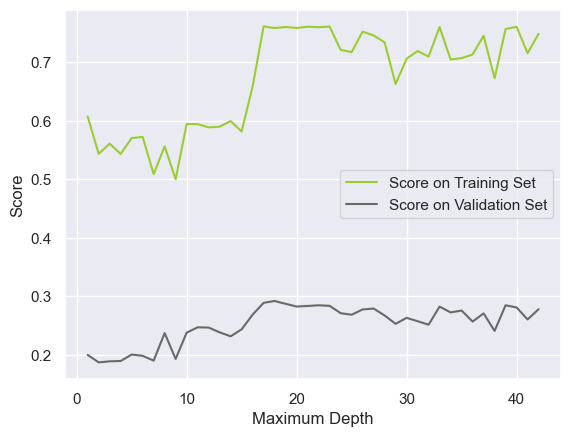

CPU times: total: 58min 18s
Wall time: 2h 22min 3s


In [330]:
'''
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    select_features = SelectKBest(mutual_info_classif, k = nof_list[n])
    X_train_kbest = select_features.fit_transform(X_train_bin, y_train_bin)
    X_val_kbest = select_features.transform(X_val_bin)

    kbest_model = bagging_model

    kbest_model.fit(X_train_kbest, y_train_bin)

    #storing results on training data
    kbest_labels_train = kbest_model.predict(X_train_kbest)
    train_score = f1_score(y_train_bin, kbest_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    kbest_labels_val = kbest_model.predict(X_val_kbest)
    val_score = f1_score(y_val_bin, kbest_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = select_features.get_support(), index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()
'''

In [331]:
selected_features = ['multiple_encounters', 'age', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year',
                     'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
                     'number_of_medications', 'number_diagnoses', 'medication_total', 'primary_diagnosis_freq',
                     'secondary_diagnosis_freq', 'additional_diagnosis_freq', 'total_visits_in_previous_year',
                     'daily_medications', 'daily_diagnosis', 'total_number_of_procedures']

In [332]:
X_train_bagging = X_train_bin[selected_features].copy()
X_val_bagging = X_val_bin[selected_features].copy()
test_bagging = test_bin[selected_features].copy()

In [333]:
bagging_model_final = BaggingClassifier(estimator = nn_model, n_estimators = 10, bootstrap_features = True, bootstrap = False,
                                  max_samples = 0.1, max_features = 0.2, random_state = 0)
bagging_model_final.fit(X_train_bagging, y_train_bin)

BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  estimator=MLPClassifier(activation='logistic', alpha=0.001,
                                          batch_size=500,
                                          hidden_layer_sizes=100,
                                          random_state=0),
                  max_features=0.2, max_samples=0.1, random_state=0)

In [334]:
bagging_labels_train_final = bagging_model_final.predict(X_train_bagging)
bagging_labels_val_final = bagging_model_final.predict(X_val_bagging)

In [335]:
metrics(y_train_bin, bagging_labels_train_final, y_val_bin, bagging_labels_val_final)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     44300
           1       0.73      0.79      0.76     44300

    accuracy                           0.75     88600
   macro avg       0.75      0.75      0.75     88600
weighted avg       0.75      0.75      0.75     88600

[[31479 12821]
 [ 9369 34931]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.23      0.40      0.29      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.62      0.58     21371
weighted avg       0.84      0.78      0.81     21371

[[15817  3169]
 [ 1436   949]]


In [336]:
f1_bagging_final = f1_score(y_val_bin, bagging_labels_val_final)
f1_bagging_final

0.2918652929417192

In [337]:
accuracy_bagging_final = accuracy_score(y_val_bin, bagging_labels_val_final)
roc_bagging_final = roc_auc_score(y_val_bin, bagging_labels_val_final)
precision_bagging_final = precision_score(y_val_bin, bagging_labels_val_final)
recall_bagging_final = recall_score(y_val_bin, bagging_labels_val_final)

print("Accuracy:", accuracy_bagging_final)
print("ROC  AUC:", roc_bagging_final)
print("Precision:", precision_bagging_final)
print("Recall:", recall_bagging_final)

Accuracy: 0.7845210799681812
ROC  AUC: 0.6154955510636658
Precision: 0.23045167557066537
Recall: 0.3979035639412998


In [338]:
'''
bagging_test_final = bagging_model_final.predict(test_bagging)
bagging_labels_test_list_final = bagging_test_final.tolist()
bagging_labels_test_list_final = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in bagging_labels_test_list_final]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = bagging_labels_test_list_final
submission.to_csv("submissions/Group14_Version124.csv", index = "encounter_id")
'''

'\nbagging_test_final = bagging_model_final.predict(test_bagging)\nbagging_labels_test_list_final = bagging_test_final.tolist()\nbagging_labels_test_list_final = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in bagging_labels_test_list_final]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = bagging_labels_test_list_final\nsubmission.to_csv("submissions/Group14_Version124.csv", index = "encounter_id")\n'

### Voting

Optimum number of features: 29
Score with 29 features: 0.292675
Features to select: 
gender                                    True
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                  True
health_insurance                          True
took_glucose_test                        False
took_a1c_test                             True
race_asian                               False
race_caucasian                            True
race_hispanic                            False
race_other                               False
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate                True
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

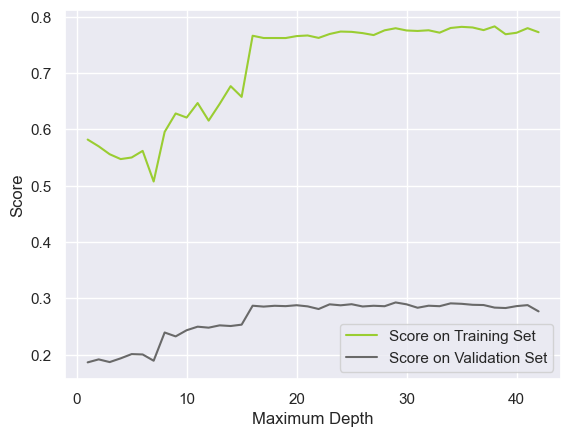

CPU times: total: 1h 12min 54s
Wall time: 3h 54min 12s


In [339]:
'''
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    select_features = SelectKBest(mutual_info_classif, k = nof_list[n])
    X_train_kbest = select_features.fit_transform(X_train_bin, y_train_bin)
    X_val_kbest = select_features.transform(X_val_bin)

    kbest_model = voting_model

    kbest_model.fit(X_train_kbest, y_train_bin)

    #storing results on training data
    kbest_labels_train = kbest_model.predict(X_train_kbest)
    train_score = f1_score(y_train_bin, kbest_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    kbest_labels_val = kbest_model.predict(X_val_kbest)
    val_score = f1_score(y_val_bin, kbest_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = select_features.get_support(), index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()
'''

In [340]:
selected_features = ['gender', 'prescribed_diabetes_meds', 'health_insurance', 'took_a1c_test',
                    'race_caucasian', 'diabetes_severity_moderate', 'multiple_encounters', 'patient_status',
                    'age', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year',
                    'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests',
                    'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'admission_type_freq',
                    'discharge_disp_freq', 'admission_source_freq', 'medication_total', 'primary_diagnosis_freq',
                    'secondary_diagnosis_freq', 'additional_diagnosis_freq', 'total_visits_in_previous_year',
                    'daily_medications', 'daily_diagnosis', 'total_number_of_procedures']

In [341]:
X_train_voting = X_train_bin[selected_features].copy()
X_val_voting = X_val_bin[selected_features].copy()
test_voting = test_bin[selected_features].copy()

In [342]:
voting_f1_scores = [f1_bagging, f1_bnb, f1_nn, f1_svcl, f1_rdf]

sum_f1_scores = sum(voting_f1_scores)
avg_f1_score = sum_f1_scores / len(voting_f1_scores)

weights = []
for i in voting_f1_scores:
    added_weight = i - avg_f1_score
    weight = 1 + 50 * added_weight
    weights.append(weight)

weights

[1.2776530148531464,
 1.152954776744843,
 1.199201973255242,
 0.7535818066378588,
 0.616608428508896]

In [343]:
estimators = [('Bagging', bagging_model), ('Bernoulli NB', bnb_model), ('NN', nn_model),
              ('SVC - Linear', svcl_model), ('RF', rdf_model)]
voting_model_final = VotingClassifier(estimators = estimators, weights = weights, voting = "hard")
voting_model_final.fit(X_train_voting, y_train_bin)

VotingClassifier(estimators=[('Bagging',
                              BaggingClassifier(bootstrap=False,
                                                bootstrap_features=True,
                                                estimator=MLPClassifier(activation='logistic',
                                                                        alpha=0.001,
                                                                        batch_size=500,
                                                                        hidden_layer_sizes=100,
                                                                        random_state=0),
                                                max_features=0.2,
                                                max_samples=0.1,
                                                random_state=0)),
                             ('Bernoulli NB', BernoulliNB(binarize=0.05)),
                             ('NN',
                              MLPClassifier(activation='logistic', alpha...
                                        intercept_scaling=20, random_state=0)),
                             ('RF',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=10,
                                                     max_features=0.3,
                                                     max_leaf_nodes=10,
                                                     max_samples=0.1,
                                                     min_impurity_decrease=0,
                                                     min_samples_leaf=400,
                                                     min_samples_split=1000,
                                                     random_state=0))],
                 weights=[1.2776530148531464, 1.152954776744843,
                          1.199201973255242, 0.7535818066378588,
                          0.616608428508896])

In [344]:
voting_labels_train_final = voting_model_final.predict(X_train_voting)
voting_labels_val_final = voting_model_final.predict(X_val_voting)

In [345]:
metrics(y_train_bin, voting_labels_train_final, y_val_bin, voting_labels_val_final)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     44300
           1       0.76      0.80      0.78     44300

    accuracy                           0.77     88600
   macro avg       0.77      0.77      0.77     88600
weighted avg       0.77      0.77      0.77     88600

[[33121 11179]
 [ 8874 35426]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.23      0.40      0.29      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.62      0.58     21371
weighted avg       0.84      0.78      0.81     21371

[[15800  3186]
 [ 1430   955]]


In [346]:
f1_voting_final = f1_score(y_val_bin, voting_labels_val_final)
f1_voting_final

0.2926754520380019

In [347]:
accuracy_voting_final = accuracy_score(y_val_bin, voting_labels_val_final)
roc_voting_final = roc_auc_score(y_val_bin, voting_labels_val_final)
precision_voting_final = precision_score(y_val_bin, voting_labels_val_final)
recall_voting_final = recall_score(y_val_bin, voting_labels_val_final)

print("Accuracy:", accuracy_voting_final)
print("ROC  AUC:", roc_voting_final)
print("Precision:", precision_voting_final)
print("Recall:", recall_voting_final)

Accuracy: 0.7840063637639793
ROC  AUC: 0.6163057143948724
Precision: 0.23062062303791356
Recall: 0.40041928721174


In [348]:
'''
voting_test_final = voting_model_final.predict(test_voting)
voting_labels_test_list_final = voting_test_final.tolist()
voting_labels_test_list_final = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in voting_labels_test_list_final]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = voting_labels_test_list_final
submission.to_csv("submissions/Group14_Version125.csv", index = "encounter_id")
'''

'\nvoting_test_final = voting_model_final.predict(test_voting)\nvoting_labels_test_list_final = voting_test_final.tolist()\nvoting_labels_test_list_final = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in voting_labels_test_list_final]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = voting_labels_test_list_final\nsubmission.to_csv("submissions/Group14_Version125.csv", index = "encounter_id")\n'

### Neural Networks

Optimum number of features: 25
Score with 25 features: 0.288994
Features to select: 
gender                                    True
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                 False
health_insurance                          True
took_glucose_test                        False
took_a1c_test                            False
race_asian                               False
race_caucasian                           False
race_hispanic                            False
race_other                               False
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate               False
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

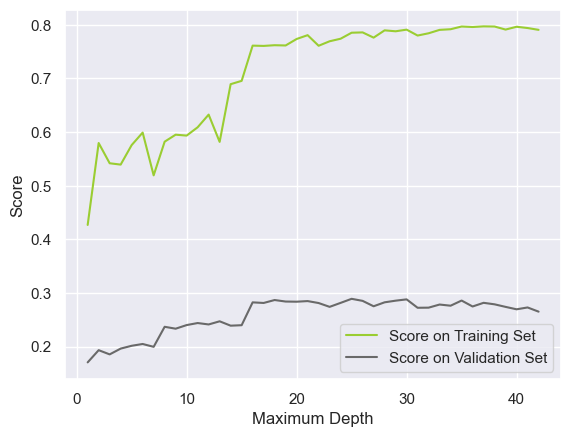

CPU times: total: 46min 51s
Wall time: 2h 47min 2s


In [349]:
'''
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    select_features = SelectKBest(mutual_info_classif, k = nof_list[n])
    X_train_kbest = select_features.fit_transform(X_train_bin, y_train_bin)
    X_val_kbest = select_features.transform(X_val_bin)

    kbest_model = nn_model

    kbest_model.fit(X_train_kbest, y_train_bin)

    #storing results on training data
    kbest_labels_train = kbest_model.predict(X_train_kbest)
    train_score = f1_score(y_train_bin, kbest_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    kbest_labels_val = kbest_model.predict(X_val_kbest)
    val_score = f1_score(y_val_bin, kbest_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = select_features.get_support(), index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()
'''

In [350]:
selected_features = ['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'health_insurance',
                    'took_a1c_test', 'race_caucasian', 'diabetes_severity_moderate', 'multiple_encounters', 'patient_status',
                    'age', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year',
                    'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests',
                    'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'admission_type_freq',
                    'discharge_disp_freq', 'admission_source_freq', 'medication_total', 'primary_diagnosis_freq',
                    'secondary_diagnosis_freq', 'additional_diagnosis_freq', 'total_visits_in_previous_year',
                    'daily_medications', 'daily_diagnosis', 'total_number_of_procedures']

In [351]:
X_train_nn = X_train_bin[selected_features].copy()
X_val_nn = X_val_bin[selected_features].copy()
test_nn = test_bin[selected_features].copy()

In [352]:
nn_model_final = MLPClassifier(solver = 'adam', learning_rate = 'constant', activation = 'logistic', alpha = 0.001,
                         hidden_layer_sizes = 100, batch_size = 500, random_state = 0)
nn_model_final.fit(X_train_nn, y_train_bin)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=500,
              hidden_layer_sizes=100, random_state=0)

In [353]:
nn_labels_train_final = nn_model_final.predict(X_train_nn)
nn_labels_val_final = nn_model_final.predict(X_val_nn)

In [354]:
metrics(y_train_bin, nn_labels_train_final, y_val_bin, nn_labels_val_final)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     44300
           1       0.78      0.80      0.79     44300

    accuracy                           0.79     88600
   macro avg       0.79      0.79      0.79     88600
weighted avg       0.79      0.79      0.79     88600

[[34251 10049]
 [ 8755 35545]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.23      0.39      0.29      2385

    accuracy                           0.78     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.78      0.81     21371

[[15818  3168]
 [ 1451   934]]


In [355]:
f1_nn_final = f1_score(y_val_bin, nn_labels_val_final)
print(f1_nn_final)

0.28796053645753045


In [356]:
accuracy_nn_final = accuracy_score(y_val_bin, nn_labels_val_final)
roc_nn_final = roc_auc_score(y_val_bin, nn_labels_val_final)
precision_nn_final = precision_score(y_val_bin, nn_labels_val_final)
recall_nn_final = recall_score(y_val_bin, nn_labels_val_final)

print("Accuracy:", accuracy_nn_final)
print("ROC  AUC:", roc_nn_final)
print("Precision:", precision_nn_final)
print("Recall:", recall_nn_final)

Accuracy: 0.7838659866173787
ROC  AUC: 0.6123772321699692
Precision: 0.22769380789858606
Recall: 0.39161425576519915


In [357]:
'''
nn_test_final = nn_model_final.predict(test_nn)
nn_labels_test_list_final = nn_test_final.tolist()
nn_labels_test_list_final = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in nn_labels_test_list_final]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = nn_labels_test_list_final
submission.to_csv("submissions/Group14_Version123.csv", index = "encounter_id")
'''

'\nnn_test_final = nn_model_final.predict(test_nn)\nnn_labels_test_list_final = nn_test_final.tolist()\nnn_labels_test_list_final = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in nn_labels_test_list_final]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = nn_labels_test_list_final\nsubmission.to_csv("submissions/Group14_Version123.csv", index = "encounter_id")\n'

### Bernoulli Naive Bayes

Optimum number of features: 16
Score with 16 features: 0.286592
Features to select: 
gender                                   False
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                 False
health_insurance                         False
took_glucose_test                        False
took_a1c_test                            False
race_asian                               False
race_caucasian                           False
race_hispanic                            False
race_other                               False
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate               False
diabetes_severity_severe                 False
diabetes_severity_unspecified            False
multiple_encounters   

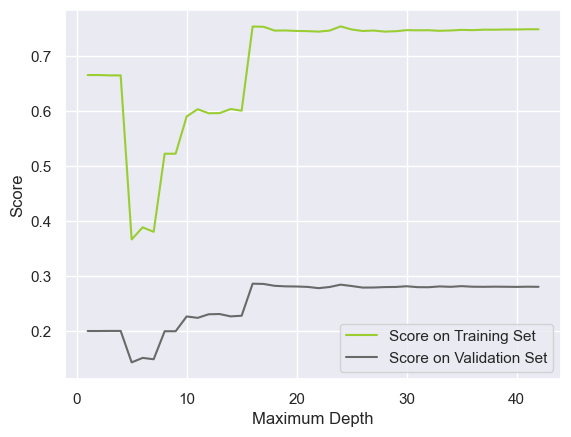

CPU times: total: 33min 5s
Wall time: 33min 18s


In [358]:
'''
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    select_features = SelectKBest(mutual_info_classif, k = nof_list[n])
    X_train_kbest = select_features.fit_transform(X_train_bin, y_train_bin)
    X_val_kbest = select_features.transform(X_val_bin)

    kbest_model = bnb_model

    kbest_model.fit(X_train_kbest, y_train_bin)

    #storing results on training data
    kbest_labels_train = kbest_model.predict(X_train_kbest)
    train_score = f1_score(y_train_bin, kbest_labels_train)
    train_score_list.append(train_score)

    #storing results on validation data
    kbest_labels_val = kbest_model.predict(X_val_kbest)
    val_score = f1_score(y_val_bin, kbest_labels_val)
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = select_features.get_support(), index = X_train_bin.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()
'''

In [359]:
selected_features = ['multiple_encounters', 'age', 'inpatient_visits_in_previous_year', 'average_pulse_bpm',
                     'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
                     'number_diagnoses', 'primary_diagnosis_freq','secondary_diagnosis_freq', 'additional_diagnosis_freq',
                     'total_visits_in_previous_year', 'daily_medications', 'daily_diagnosis', 'total_number_of_procedures']

In [360]:
X_train_bnb = X_train_bin[selected_features].copy()
X_val_bnb = X_val_bin[selected_features].copy()
test_bnb = test_bin[selected_features].copy()

In [361]:
bnb_model_final = BernoulliNB(binarize = 0.05)
bnb_model_final.fit(X_train_bnb, y_train_bin)

BernoulliNB(binarize=0.05)

In [362]:
bnb_labels_train_final = bnb_model_final.predict(X_train_bnb)
bnb_labels_val_final = bnb_model_final.predict(X_val_bnb)

In [363]:
metrics(y_train_bin, bnb_labels_train_final, y_val_bin, bnb_labels_val_final)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     44300
           1       0.74      0.77      0.75     44300

    accuracy                           0.75     88600
   macro avg       0.75      0.75      0.75     88600
weighted avg       0.75      0.75      0.75     88600

[[32022 12278]
 [10081 34219]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.82      0.86     18986
           1       0.22      0.41      0.29      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.61      0.58     21371
weighted avg       0.84      0.77      0.80     21371

[[15512  3474]
 [ 1405   980]]


In [364]:
f1_bnb_final = f1_score(y_val_bin, bnb_labels_val_final)
print(f1_bnb_final)

0.2865916069600819


In [365]:
accuracy_bnb_final = accuracy_score(y_val_bin, bnb_labels_val_final)
roc_bnb_final = roc_auc_score(y_val_bin, bnb_labels_val_final)
precision_bnb_final = precision_score(y_val_bin, bnb_labels_val_final)
recall_bnb_final = recall_score(y_val_bin, bnb_labels_val_final)

print("Accuracy:", accuracy_bnb_final)
print("ROC  AUC:", roc_bnb_final)
print("Precision:", precision_bnb_final)
print("Recall:", recall_bnb_final)

Accuracy: 0.7716999672453324
ROC  AUC: 0.6139622685677475
Precision: 0.22002694207453974
Recall: 0.4109014675052411


In [366]:
'''
bnb_test_final = bnb_model_final.predict(test_bnb)
bnb_labels_test_list_final = bnb_test_final.tolist()
bnb_labels_test_list_final = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in bnb_labels_test_list_final]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = bnb_labels_test_list_final
submission.to_csv("submissions/Group14_Version121.csv", index = "encounter_id")
'''

'\nbnb_test_final = bnb_model_final.predict(test_bnb)\nbnb_labels_test_list_final = bnb_test_final.tolist()\nbnb_labels_test_list_final = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in bnb_labels_test_list_final]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = bnb_labels_test_list_final\nsubmission.to_csv("submissions/Group14_Version121.csv", index = "encounter_id")\n'

In [367]:
# The random seed will no longer be necessary, so let's remove it
np.random.seed(None)

### Submit Test Results

Having been unsuccessful in the task of identifying a better set of features for the models that were initially developed, the choice for the optimal model will fall on the __Bagging Classifier__, using Neural Networks as the base estimator and bootstrapped features (amongst other tuned hyperparameters).

Despite not presenting an F1-Score that makes the decision more straightforward (being solely 0.000004 points larger than the Voting Classifier, as pictured in the table below), this model poses some advantages that make it the one that best fits our purpose.

Compared to Voting, Bagging achieved higher ROC-AUC and Recall scores, whilst falling short on the  Accuracy and Precision metrics. In fact, considering the specific purpose on this project, having a higher Recall is more important than a greater value for Precision. __Precision__ identifies the proportion of correctly identified positive events ("readmitted_binary" = 1) amongst all events that were identified as positive (true and false positives). A false positive would mean that a patient would be predicted to be readmitted within the following 30 days after his/hers departures from the hospital, when in reality he/she wasn't. __Recall__, on the other hand, relates to the proportion of events identified as positive amongst all positive events (true positives and false negatives). In this context, a false negative would mean that a patient would predicted as not being readmitted, whilst the real occurrence showed the exact opposite. This latter event would be considerably more serious than the former, hence supporting the selection of Bagging as the final model.

Nonetheless, the final submission for Kaggle will use __Voting__ as the chosen classifier, as it was the one that achieved the highest score on the public display of the competition (0.3205, compared to Bagging's 0.3171 F1-Score).

A final consideration over the __interpretability__ of the model is also worth mentioning. By using Ensemble methods, a compromise on the ability to interpret the outcome of the algorithm (mainly in what concerns feature importance) is inevitable. Therefore, if this capability is to be prioritised, a recomendation on the use of the __Bernoulli Naive Bayes Classifier__ should be made, since this was the top performing single model apart from Neural Networks (which, due to its "black box" operating nature, also lack this interpretability component).

In [368]:
models_final = pd.DataFrame({'Model': ['Bagging Classifier', 'Voting Classifier'],
                       'Accuracy Score - validation': [accuracy_bagging, accuracy_voting],
                       'ROC-AUC Score - validation': [roc_bagging, roc_voting],
                       'Precision Score - validation': [precision_bagging, precision_voting],
                       'Recall Score - validation': [recall_bagging, recall_voting],
                       'F1 Score - validation': [f1_bagging, f1_voting]})
models_final.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
0  Bagging Classifier                     0.772449   
1   Voting Classifier                     0.784708   

   ROC-AUC Score - validation  Precision Score - validation  \
0                    0.625199                      0.228051   
1                    0.621833                      0.235055   

   Recall Score - validation  F1 Score - validation  
0                   0.435639               0.299380  
1                   0.412159               0.299376

#### Final Kaggle Submission

In [369]:
voting_f1_scores = [f1_bagging, f1_bnb, f1_nn, f1_svcl, f1_rdf]

sum_f1_scores = sum(voting_f1_scores)
avg_f1_score = sum_f1_scores / len(voting_f1_scores)

weights = []
for i in voting_f1_scores:
    added_weight = i - avg_f1_score
    weight = 1 + 50 * added_weight
    weights.append(weight)

weights

[1.2776530148531464,
 1.152954776744843,
 1.199201973255242,
 0.7535818066378588,
 0.616608428508896]

In [370]:
estimators = [('Bagging', bagging_model), ('Bernoulli NB', bnb_model), ('NN', nn_model),
              ('SVC - Linear', svcl_model), ('RF', rdf_model)]
voting_model = VotingClassifier(estimators = estimators, weights = weights, voting = "hard")
voting_model.fit(X_train_bin_copy, y_train_bin)

VotingClassifier(estimators=[('Bagging',
                              BaggingClassifier(bootstrap=False,
                                                bootstrap_features=True,
                                                estimator=MLPClassifier(activation='logistic',
                                                                        alpha=0.001,
                                                                        batch_size=500,
                                                                        hidden_layer_sizes=100,
                                                                        random_state=0),
                                                max_features=0.2,
                                                max_samples=0.1,
                                                random_state=0)),
                             ('Bernoulli NB', BernoulliNB(binarize=0.05)),
                             ('NN',
                              MLPClassifier(activation='logistic', alpha...
                                        intercept_scaling=20, random_state=0)),
                             ('RF',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=10,
                                                     max_features=0.3,
                                                     max_leaf_nodes=10,
                                                     max_samples=0.1,
                                                     min_impurity_decrease=0,
                                                     min_samples_leaf=400,
                                                     min_samples_split=1000,
                                                     random_state=0))],
                 weights=[1.2776530148531464, 1.152954776744843,
                          1.199201973255242, 0.7535818066378588,
                          0.616608428508896])

In [371]:
voting_labels_train = voting_model.predict(X_train_bin_copy)
voting_labels_val = voting_model.predict(X_val_bin_copy)

metrics(y_train_bin, voting_labels_train, y_val_bin, voting_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     44300
           1       0.74      0.80      0.77     44300

    accuracy                           0.76     88600
   macro avg       0.76      0.76      0.76     88600
weighted avg       0.76      0.76      0.76     88600

[[32143 12157]
 [ 8952 35348]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     18986
           1       0.24      0.41      0.30      2385

    accuracy                           0.78     21371
   macro avg       0.58      0.62      0.59     21371
weighted avg       0.84      0.78      0.81     21371

[[15787  3199]
 [ 1402   983]]


In [372]:
accuracy_voting = accuracy_score(y_val_bin, voting_labels_val)
roc_voting = roc_auc_score(y_val_bin, voting_labels_val)
precision_voting = precision_score(y_val_bin, voting_labels_val)
recall_voting = recall_score(y_val_bin, voting_labels_val)
f1_voting = f1_score(y_val_bin, voting_labels_val)

print("Accuracy:", accuracy_voting)
print("ROC  AUC:", roc_voting)
print("Precision:", precision_voting)
print("Recall:", recall_voting)
print("F1 Score:", f1_voting)

Accuracy: 0.7847082494969819
ROC  AUC: 0.6218333778326344
Precision: 0.2350549976087996
Recall: 0.4121593291404612
F1 Score: 0.299375666209837


Uncomment this cell in order to generate the final submission in Kaggle.

In [373]:
'''
voting_test = voting_model.predict(test_bin_copy)
voting_labels_test_list = voting_test.tolist()
voting_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in voting_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = voting_labels_test_list
submission.to_csv("submissions/Group14_Version126.csv", index = "encounter_id")
'''

'\nvoting_test = voting_model.predict(test_bin_copy)\nvoting_labels_test_list = voting_test.tolist()\nvoting_labels_test_list = [\'No\' if x == 0.0 else \'Yes\' if x == 1.0 else x for x in voting_labels_test_list]\n\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = voting_labels_test_list\nsubmission.to_csv("submissions/Group14_Version126.csv", index = "encounter_id")\n'

#### Final Model for Binary Classification

In [374]:
bagging_model = BaggingClassifier(estimator = nn_model, n_estimators = 10, bootstrap_features = True, bootstrap = False,
                                  max_samples = 0.1, max_features = 0.2, random_state = 0)
bagging_model.fit(X_train_bin_copy, y_train_bin)

BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  estimator=MLPClassifier(activation='logistic', alpha=0.001,
                                          batch_size=500,
                                          hidden_layer_sizes=100,
                                          random_state=0),
                  max_features=0.2, max_samples=0.1, random_state=0)

In [375]:
bagging_labels_train = bagging_model.predict(X_train_bin_copy)
bagging_labels_val = bagging_model.predict(X_val_bin_copy)

metrics(y_train_bin, bagging_labels_train, y_val_bin, bagging_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     44300
           1       0.73      0.77      0.75     44300

    accuracy                           0.74     88600
   macro avg       0.74      0.74      0.74     88600
weighted avg       0.74      0.74      0.74     88600

[[31787 12513]
 [10266 34034]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     18986
           1       0.23      0.44      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

[[15469  3517]
 [ 1346  1039]]


In [376]:
accuracy_bagging = accuracy_score(y_val_bin, bagging_labels_val)
roc_bagging = roc_auc_score(y_val_bin, bagging_labels_val)
precision_bagging = precision_score(y_val_bin, bagging_labels_val)
recall_bagging = recall_score(y_val_bin, bagging_labels_val)
f1_bagging = f1_score(y_val_bin, bagging_labels_val)

print("Accuracy:", accuracy_bagging)
print("ROC  AUC:", roc_bagging)
print("Precision:", precision_bagging)
print("Recall:", recall_bagging)
print("F1 Score:", f1_bagging)

Accuracy: 0.7724486453605353
ROC  AUC: 0.6251988279568681
Precision: 0.2280509218612818
Recall: 0.43563941299790354
F1 Score: 0.29938049272439127


This cell will generate the predictions made by our final model selected (Bagging).

In [377]:
bagging_labels_test = bagging_model.predict(test_bin_copy)
bagging_labels_test_list = bagging_labels_test.tolist()
bagging_labels_test_list = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in bagging_labels_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_binary"] = bagging_labels_test_list
submission.to_csv("submissions/Group14_VersionFinalBinary.csv", index = "encounter_id")

'\nsubmission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")\nsubmission["readmitted_binary"] = bagging_labels_test_list\nsubmission.to_csv("submissions/Group14_VersionFinal.csv", index = "encounter_id")\n'

# <font color='#238278'>Multiclass Classification</font> <a class="anchor" id="multiclass"></a>
[Back to Contents](#toc)

In [378]:
X_train_multi = X_train.copy()
X_val_multi = X_val.copy()
test_multi = test.copy()

## <font color='#238278'>Oversampling</font> <a class="anchor" id="oversamplemulti"></a>
[Back to Contents](#toc)

In [379]:
unique, counts = np.unique(y_train_multi, return_counts=True)
result = dict(zip(unique, counts))
print(result)

smt = SMOTE(random_state = 2024)
X_train_multi, y_train_multi = smt.fit_resample(X_train_multi, y_train_multi)

unique, counts = np.unique(y_train_multi, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 26883, 1: 5565, 2: 17417}
{0: 26883, 1: 26883, 2: 26883}


## <font color='#238278'>Feature Selection</font> <a class="anchor" id="selectionmulti"></a>
[Back to Contents](#toc)

### Pearson Correlation

In [385]:
y_train_multi_new = pd.DataFrame(y_train_multi).set_index(X_train_multi.index)
X_corr_multiclass = pd.concat([X_train_multi, y_train_multi_new], axis = 1)

In [386]:
def cor_heatmap(cor, method):
    mask = np.triu(np.ones_like(cor, dtype=bool))

    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor,
                mask = mask,
                annot = True,
                annot_kws={"size": 7},
                cmap = "vlag",
                vmax = 1,
                vmin = -1,
                center = 0,
                fmt='.1')
    plt.title("{0} Correlation".format(method), y = 1.02)
    plt.show()

In [387]:
cor_pearson_multiclass = X_corr_multiclass.corr("pearson")
cor_pearson_multiclass

gender  \
gender                                 1.000000   
change_in_meds_during_hospitalization  0.020358   
prescribed_diabetes_meds               0.016710   
health_insurance                       0.000326   
took_glucose_test                     -0.009293   
took_a1c_test                          0.012073   
race_asian                             0.011154   
race_caucasian                         0.046380   
race_hispanic                          0.009105   
race_other                             0.012147   
race_unknown                          -0.001098   
diabetes_uncontrolled_typei           -0.025358   
diabetes_uncontrolled_typeii          -0.004134   
diabetes_unspecified                  -0.002965   
diabetes_unstated_typei               -0.021490   
diabetes_severity_mild                -0.029386   
diabetes_severity_moderate             0.008764   
diabetes_severity_severe              -0.007019   
diabetes_severity_unspecified         -0.011070   
multiple_encounters                   -0.023260   
patient_status                        -0.002270   
age                                   -0.044509   
outpatient_visits_in_previous_year     0.001868   
emergency_visits_in_previous_year     -0.013502   
inpatient_visits_in_previous_year     -0.017934   
average_pulse_bpm                      0.004788   
length_of_stay_in_hospital            -0.037685   
number_lab_tests                      -0.011445   
non_lab_procedures                     0.071117   
number_of_medications                 -0.032290   
number_diagnoses                       0.007272   
admission_type_freq                   -0.018472   
discharge_disp_freq                    0.062746   
admission_source_freq                 -0.011119   
medication_total                       0.028035   
primary_diagnosis_freq                 0.052345   
secondary_diagnosis_freq               0.025848   
additional_diagnosis_freq              0.007766   
total_visits_in_previous_year         -0.014604   
daily_medications                      0.023047   
daily_diagnosis                        0.047609   
total_number_of_procedures            -0.005290   
readmitted_multiclass                 -0.021150   

                                       change_in_meds_during_hospitalization  \
gender                                                              0.020358   
change_in_meds_during_hospitalization                               1.000000   
prescribed_diabetes_meds                                            0.500070   
health_insurance                                                    0.131323   
took_glucose_test                                                  -0.028863   
took_a1c_test                                                       0.076900   
race_asian                                                         -0.003652   
race_caucasian                                                      0.002757   
race_hispanic                                                      -0.001323   
race_other                                                          0.011594   
race_unknown                                                        0.004539   
diabetes_uncontrolled_typei                                         0.014278   
diabetes_uncontrolled_typeii                                        0.099945   
diabetes_unspecified                                                0.009084   
diabetes_unstated_typei                                            -0.005564   
diabetes_severity_mild                                              0.048438   
diabetes_severity_moderate                                          0.037374   
diabetes_severity_severe                                            0.061873   
diabetes_severity_unspecified                                      -0.013149   
multiple_encounters                                                 0.037316   
patient_status                                                      0.029152   
age                                 

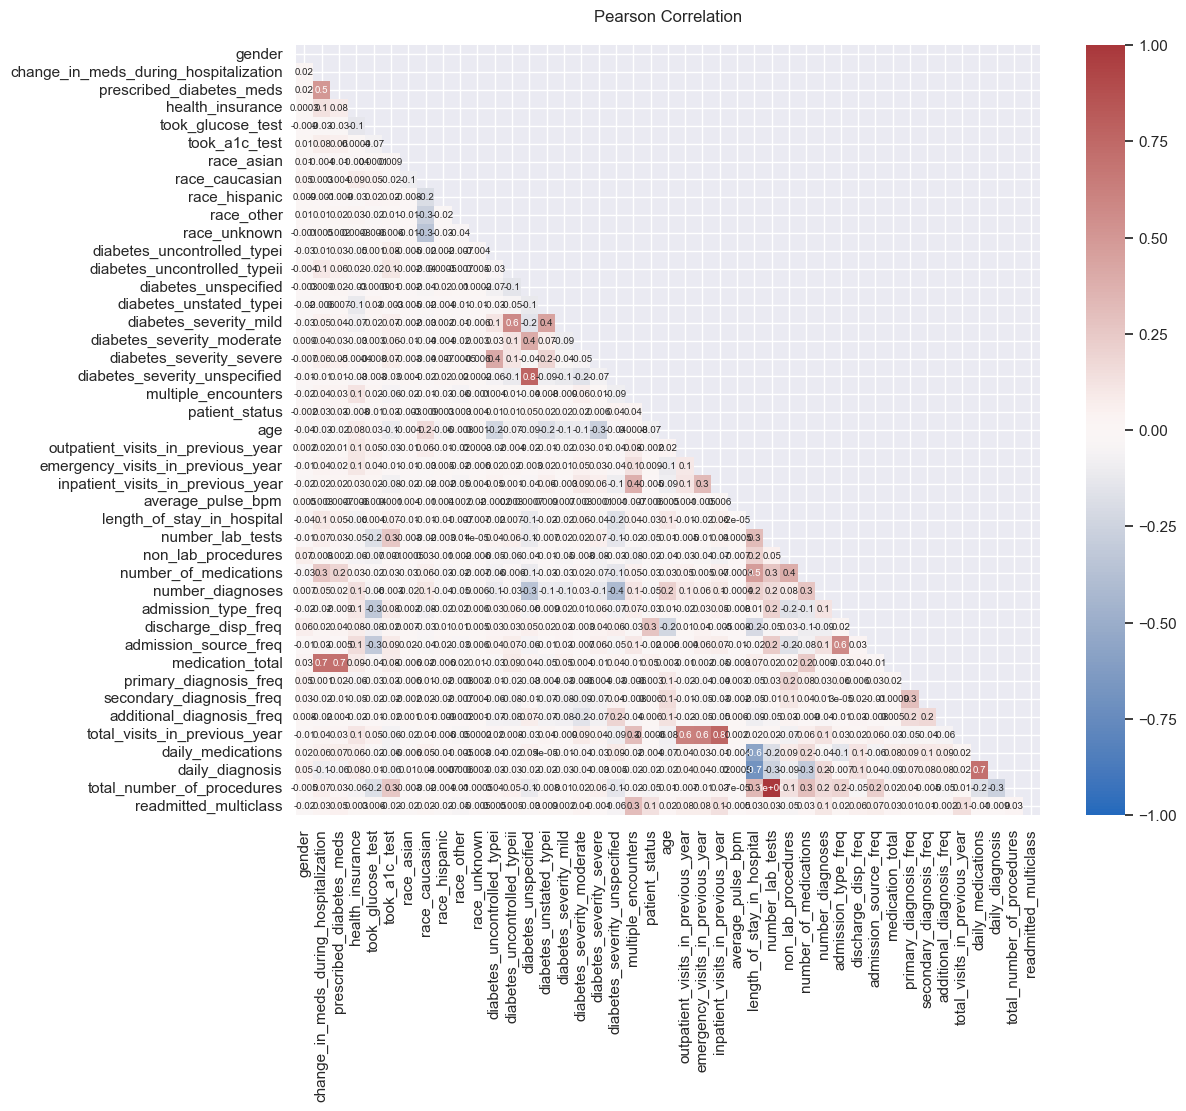

In [388]:
cor_heatmap(cor_pearson_multiclass, "Pearson")

In [389]:
# Calculate the correlation matrix
correlation_matrix_multi = X_corr_multiclass.corr("pearson")

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix_multi.columns)):
    for j in range(i + 1, len(correlation_matrix_multi.columns)):
        if abs(correlation_matrix_multi.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix_multi.columns[i], correlation_matrix_multi.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix_multi.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")

High Correlation: change_in_meds_during_hospitalization and medication_total - Correlation: 0.7100618420184479
High Correlation: prescribed_diabetes_meds and medication_total - Correlation: 0.705487335048246
High Correlation: diabetes_unspecified and diabetes_severity_unspecified - Correlation: 0.7692041136553643
High Correlation: inpatient_visits_in_previous_year and total_visits_in_previous_year - Correlation: 0.7596308577639324
High Correlation: length_of_stay_in_hospital and daily_diagnosis - Correlation: -0.6903262734908759
High Correlation: number_lab_tests and total_number_of_procedures - Correlation: 0.9963732325174771
High Correlation: daily_medications and daily_diagnosis - Correlation: 0.708785306131727


It is now time to analyze the correlation of the identified pair individually with the target feature.

In [390]:
# Last pair analyzed

correlation_matrix_multi.loc['daily_medications', 'readmitted_multiclass'] > correlation_matrix_multi.loc['daily_diagnosis', 'readmitted_multiclass']

False

### Spearman's Rank Correlation

In [391]:
cor_spearman_multiclass = X_corr_multiclass.corr("spearman")
cor_spearman_multiclass

gender  \
gender                                 1.000000   
change_in_meds_during_hospitalization  0.020358   
prescribed_diabetes_meds               0.016710   
health_insurance                       0.000326   
took_glucose_test                     -0.009293   
took_a1c_test                          0.012073   
race_asian                             0.011154   
race_caucasian                         0.046380   
race_hispanic                          0.009105   
race_other                             0.012147   
race_unknown                          -0.001098   
diabetes_uncontrolled_typei           -0.025358   
diabetes_uncontrolled_typeii          -0.004134   
diabetes_unspecified                  -0.002965   
diabetes_unstated_typei               -0.021490   
diabetes_severity_mild                -0.029386   
diabetes_severity_moderate             0.008764   
diabetes_severity_severe              -0.007019   
diabetes_severity_unspecified         -0.011070   
multiple_encounters                   -0.023260   
patient_status                        -0.002270   
age                                   -0.064098   
outpatient_visits_in_previous_year    -0.004553   
emergency_visits_in_previous_year     -0.028766   
inpatient_visits_in_previous_year     -0.017012   
average_pulse_bpm                      0.004620   
length_of_stay_in_hospital            -0.045765   
number_lab_tests                      -0.016478   
non_lab_procedures                     0.057239   
number_of_medications                 -0.044138   
number_diagnoses                       0.009952   
admission_type_freq                   -0.018506   
discharge_disp_freq                    0.062658   
admission_source_freq                 -0.015750   
medication_total                       0.024055   
primary_diagnosis_freq                 0.049947   
secondary_diagnosis_freq               0.015938   
additional_diagnosis_freq              0.010894   
total_visits_in_previous_year         -0.021322   
daily_medications                      0.016139   
daily_diagnosis                        0.047879   
total_number_of_procedures            -0.010323   
readmitted_multiclass                 -0.021150   

                                       change_in_meds_during_hospitalization  \
gender                                                              0.020358   
change_in_meds_during_hospitalization                               1.000000   
prescribed_diabetes_meds                                            0.500070   
health_insurance                                                    0.131323   
took_glucose_test                                                  -0.028863   
took_a1c_test                                                       0.076900   
race_asian                                                         -0.003652   
race_caucasian                                                      0.002757   
race_hispanic                                                      -0.001323   
race_other                                                          0.011594   
race_unknown                                                        0.004539   
diabetes_uncontrolled_typei                                         0.014278   
diabetes_uncontrolled_typeii                                        0.099945   
diabetes_unspecified                                                0.009084   
diabetes_unstated_typei                                            -0.005564   
diabetes_severity_mild                                              0.048438   
diabetes_severity_moderate                                          0.037374   
diabetes_severity_severe                                            0.061873   
diabetes_severity_unspecified                                      -0.013149   
multiple_encounters                                                 0.037316   
patient_status                                                      0.029152   
age                                 

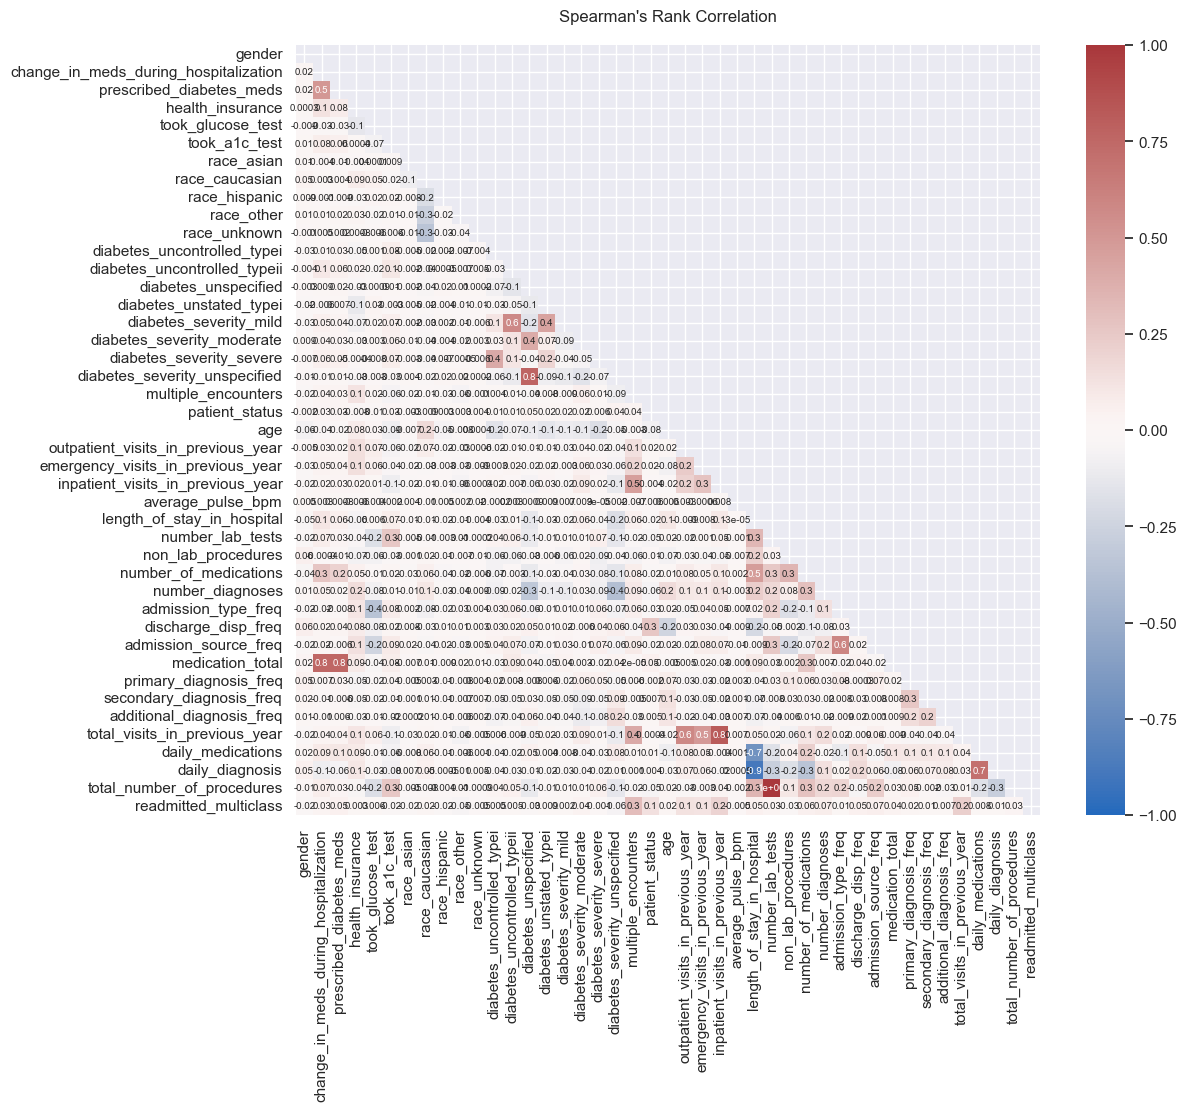

In [392]:
cor_heatmap(cor_spearman_multiclass, "Spearman's Rank")

In [393]:
# Calculate the correlation matrix
correlation_matrix_multi = X_corr_multiclass.corr("spearman")

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix_multi.columns)):
    for j in range(i + 1, len(correlation_matrix_multi.columns)):
        if abs(correlation_matrix_multi.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix_multi.columns[i], correlation_matrix_multi.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix_multi.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")

High Correlation: change_in_meds_during_hospitalization and medication_total - Correlation: 0.7567818538853206
High Correlation: prescribed_diabetes_meds and medication_total - Correlation: 0.7557773307894657
High Correlation: diabetes_unspecified and diabetes_severity_unspecified - Correlation: 0.7692041136553732
High Correlation: inpatient_visits_in_previous_year and total_visits_in_previous_year - Correlation: 0.8170283771381405
High Correlation: length_of_stay_in_hospital and daily_medications - Correlation: -0.6964989225268996
High Correlation: length_of_stay_in_hospital and daily_diagnosis - Correlation: -0.8900899421571509
High Correlation: number_lab_tests and total_number_of_procedures - Correlation: 0.9957689628850801
High Correlation: daily_medications and daily_diagnosis - Correlation: 0.7066533120886839


Let's now evaluate these correlations with the target feature in question.

In [394]:
# Last pair analyzed

correlation_matrix_multi.loc['daily_medications', 'readmitted_multiclass'] > correlation_matrix_multi.loc['daily_diagnosis', 'readmitted_multiclass']

False

### ANOVA

In [381]:
anova = SelectKBest(f_classif, k = 21)
X_anova = anova.fit_transform(X_train_multi, y_train_multi)
important_features = pd.Series(anova.get_support(), index = X_train_multi.columns)
important_features

gender                                   False
change_in_meds_during_hospitalization    False
prescribed_diabetes_meds                  True
health_insurance                         False
took_glucose_test                        False
took_a1c_test                             True
race_asian                               False
race_caucasian                           False
race_hispanic                            False
race_other                                True
race_unknown                             False
diabetes_uncontrolled_typei              False
diabetes_uncontrolled_typeii             False
diabetes_unspecified                     False
diabetes_unstated_typei                  False
diabetes_severity_mild                   False
diabetes_severity_moderate                True
diabetes_severity_severe                 False
diabetes_severity_unspecified             True
multiple_encounters                       True
patient_status                            True
age          

### Decision Tree

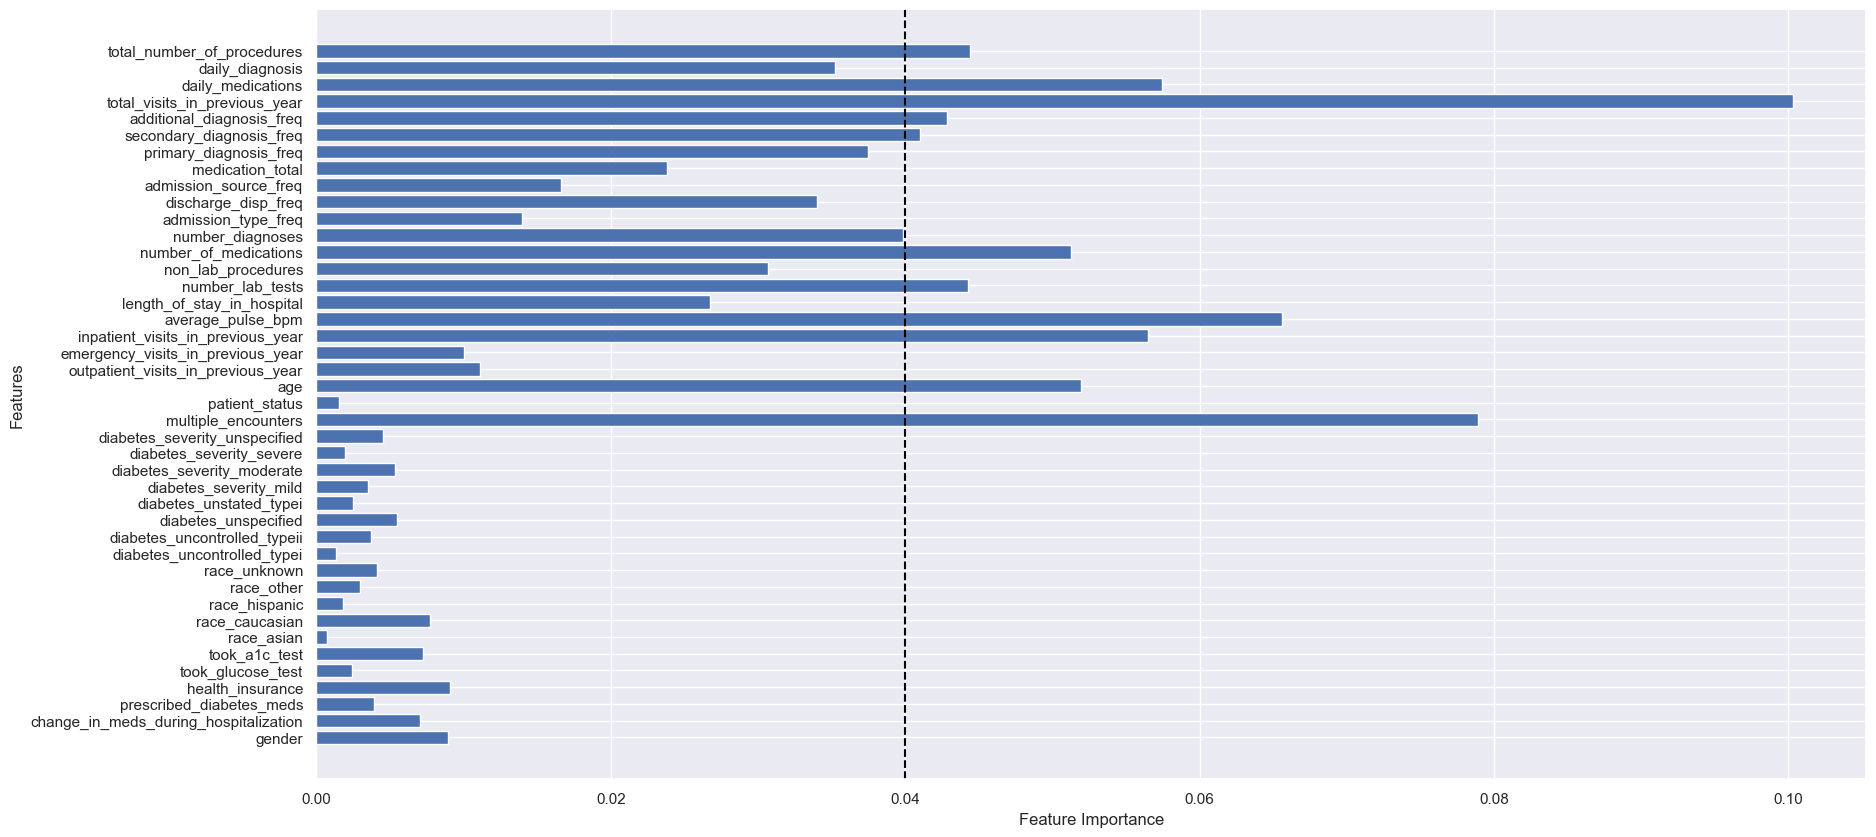

In [380]:
modelDT = DecisionTreeClassifier(random_state = 2024)

modelDT.fit(X_train_multi, y_train_multi)

modelDT.feature_importances_
def plot_feature_importances(modelDT):
  n_features = X_train_multi.shape[1]
  plt.figure(figsize = (20,10))
  plt.barh(range(n_features), modelDT.feature_importances_, align = 'center')
  plt.axvline(x = 0.04, color = "black", linestyle = "--")
  plt.yticks(np.arange(n_features), X_train_multi.columns)
  plt.xlabel('Feature Importance')
  plt.ylabel('Features')
  plt.show()

plot_feature_importances(modelDT)

### Random Forest

In [382]:
forest_fs = RandomForestClassifier(n_estimators = 500, random_state = 2024)

forest_fs.fit(X_train_multi, y_train_multi)
importances = forest_fs.feature_importances_

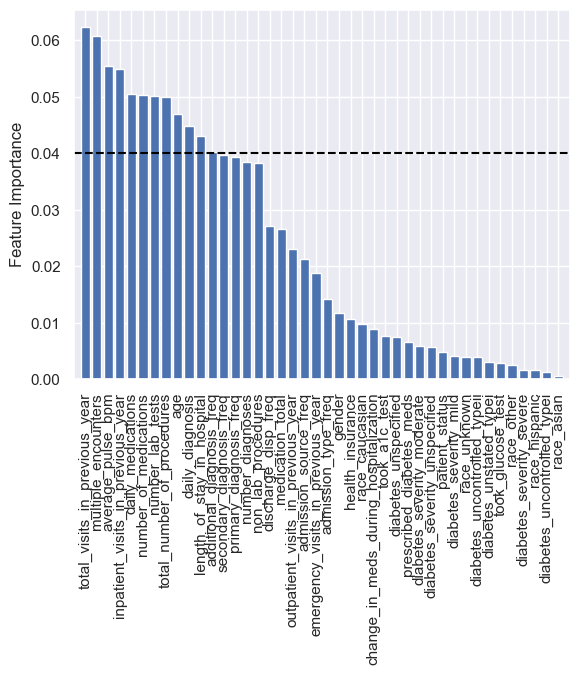

In [383]:
indices = np.argsort(importances)[::-1]

plt.bar(range(X_train_multi.shape[1]), importances[indices], align = "center")
plt.ylabel("Feature Importance")

feat_labels = X_train_multi.columns
plt.xticks(range(X_train_multi.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train_multi.shape[1]])

plt.axhline(y = 0.04, color = "black", linestyle = "--")

plt.show()

### RFE Logistic Regression

Optimum number of features: 39
Score with 39 features: 0.539290
Features to select: 
gender                                    True
change_in_meds_during_hospitalization     True
prescribed_diabetes_meds                  True
health_insurance                          True
took_glucose_test                         True
took_a1c_test                             True
race_asian                                True
race_caucasian                            True
race_hispanic                             True
race_other                                True
race_unknown                              True
diabetes_uncontrolled_typei               True
diabetes_uncontrolled_typeii              True
diabetes_unspecified                     False
diabetes_unstated_typei                   True
diabetes_severity_mild                    True
diabetes_severity_moderate                True
diabetes_severity_severe                  True
diabetes_severity_unspecified             True
multiple_encounters   

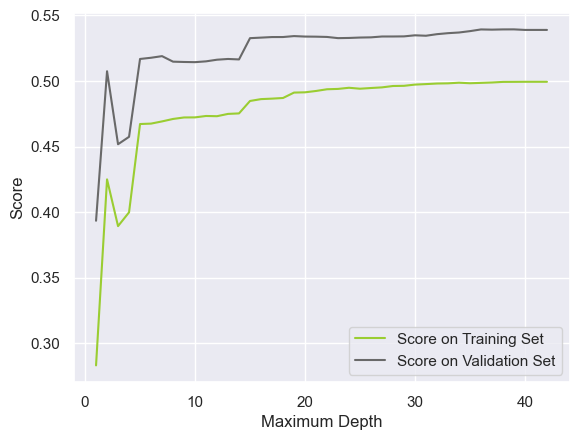

CPU times: total: 2h 25min 4s
Wall time: 2h 25min 51s


In [395]:
%%time
# Number of features
nof_list = np.arange(1, 43)
high_score = 0

# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    rfe_model = LogisticRegression(solver = 'saga', penalty = 'l1', C = 0.5, multi_class = 'auto', random_state = 2025)

    rfe = RFE(estimator = rfe_model, n_features_to_select = nof_list[n])

    X_train_rfe = rfe.fit_transform(X_train_multi, y_train_multi)
    X_val_rfe = rfe.transform(X_val_multi)

    rfe_model.fit(X_train_rfe, y_train_multi)

    #storing results on training data
    rfe_labels_train = rfe_model.predict(X_train_rfe)
    train_score = f1_score(y_train_multi, rfe_labels_train, average = 'weighted') # this gives more weight to the minority class. Useful for imbalanced datasets as ours.
    train_score_list.append(train_score)

    #storing results on validation data
    rfe_labels_val = rfe_model.predict(X_val_rfe)
    val_score = f1_score(y_val_multi, rfe_labels_val, average = 'weighted')
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        features_to_select = pd.Series(data = rfe.support_, index = X_train_multi.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

### RFE Support Vector Classifier - Linear

Optimum number of features: 42
Score with 42 features: 0.523894
Features to select: 
gender                                   True
change_in_meds_during_hospitalization    True
prescribed_diabetes_meds                 True
health_insurance                         True
took_glucose_test                        True
took_a1c_test                            True
race_asian                               True
race_caucasian                           True
race_hispanic                            True
race_other                               True
race_unknown                             True
diabetes_uncontrolled_typei              True
diabetes_uncontrolled_typeii             True
diabetes_unspecified                     True
diabetes_unstated_typei                  True
diabetes_severity_mild                   True
diabetes_severity_moderate               True
diabetes_severity_severe                 True
diabetes_severity_unspecified            True
multiple_encounters                      

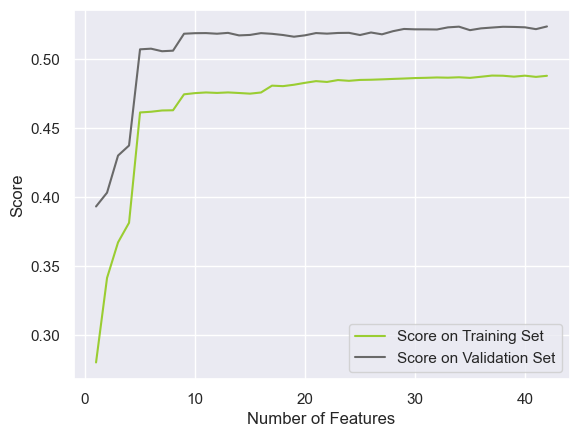

CPU times: total: 3h 36min 57s
Wall time: 3h 38min 4s


In [396]:
%%time
#no of features
nof_list=np.arange(1, 43)
high_score=0
#Variable to store the optimum features
nof=0
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    #call support vector machines classifier
    rfe_model = LinearSVC(penalty = 'l1', C = 0.05, dual = False, random_state = 2024)

    #create RFE instance
    rfe = RFE(estimator = rfe_model, n_features_to_select = nof_list[n])

    #fit and transform for training data, transform for val data
    X_train_rfe = rfe.fit_transform(X_train_multi,y_train_multi)
    X_val_rfe = rfe.transform(X_val_multi)

    rfe_model.fit(X_train_rfe,y_train_multi)

    #storing results on training data
    rfe_labels_train = rfe_model.predict(X_train_rfe)
    train_score = f1_score(y_train_multi, rfe_labels_train, average='weighted')
    train_score_list.append(train_score)

    #storing results on validation data
    rfe_labels_val = rfe_model.predict(X_val_rfe)
    val_score = f1_score(y_val_multi, rfe_labels_val, average='weighted')
    val_score_list.append(val_score)

    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]

        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_multi.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1, 43)), train_score_list, label = "Score on Training Set", color = "yellowgreen")
plt.plot(list(range(1, 43)), val_score_list, label = "Score on Validation Set", color = "dimgray")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.show()

### LASSO

Lasso picked 39 variables and eliminated the other 3 variables


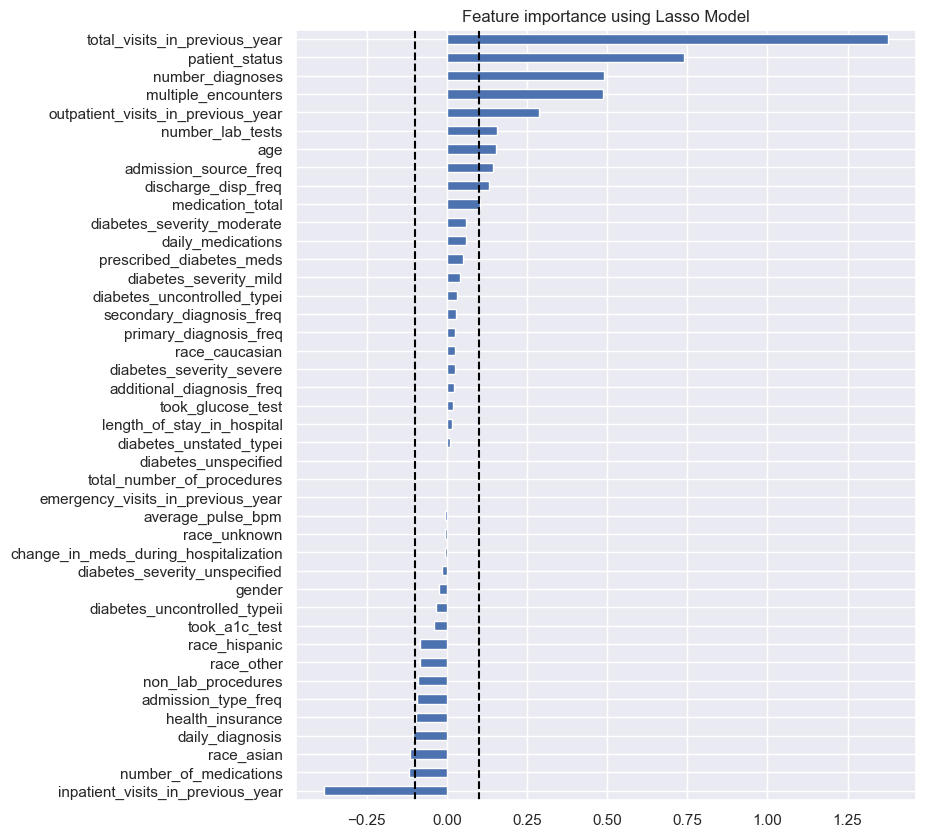

In [384]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (8,10))
    imp_coef.plot(kind = "barh")
    plt.axvline(x = -0.1, color = "black", linestyle = "--")
    plt.axvline(x = 0.1, color = "black", linestyle = "--")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()

reg.fit(X_train_multi, y_train_multi)

coef = pd.Series(data = reg.coef_, index = X_train_multi.columns)
coef

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

coef.sort_values()

plot_importance(coef, "Lasso")

### Dropping Variables

After applying different models for the feature selection, the results were compiled in the following table. Here, we will only keep variariables that are considered important for 5/8 of the feature selection methods.

In [456]:
excel_path = "Variable Selection.xlsx"
sheet_name = "Final_Multiclass"
wb = load_workbook(excel_path)
sheet = wb[sheet_name]

df = pd.DataFrame(sheet.values, columns=[cell.value for cell in sheet[1]])

def highlight_cell(val, column):
    if 'Result' in column:
        return 'background-color: #FFFF66' if val == 'Keep' else ''
    elif val == "Keep":
        return 'background-color: #99FF99'
    elif val == "Discard":
        return 'background-color: #FF8989'
    return ""

styled_df = df.style.apply(lambda row: [highlight_cell(val, column) for val, column in zip(row, df.columns)], axis=1)

styled_df.hide(0)

In [398]:
# Checkpoint if we wish to select different features for our models. Also, it ensures that we are using the correct values for the features.
X_train_multi_copy = X_train_multi.copy()
X_val_multi_copy = X_val_multi.copy()
test_multi_copy = test_multi.copy()

In [399]:
# Criteria: we will only keep variariables that are considered important for 5/8 of the feature selection methods
features_to_select = ['prescribed_diabetes_meds', 'health_insurance', 'took_a1c_test', 'race_asian', 'race_other',
                      'diabetes_severity_moderate', 'multiple_encounters', 'patient_status', 'age', 'outpatient_visits_in_previous_year',
                     'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital',
                     'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'discharge_disp_freq', 'admission_source_freq',
                     'secondary_diagnosis_freq', 'additional_diagnosis_freq', 'total_visits_in_previous_year', 'daily_diagnosis']

In [400]:
X_train_multi_copy = X_train_multi[features_to_select].copy()
X_val_multi_copy = X_val_multi[features_to_select].copy()
test_multi_copy = test_multi[features_to_select].copy()

In [401]:
X_train_multi_copy.head().T

0         1         2         3  \
prescribed_diabetes_meds            1.000000  1.000000  1.000000  1.000000   
health_insurance                    1.000000  1.000000  1.000000  0.000000   
took_a1c_test                       0.000000  0.000000  0.000000  0.000000   
race_asian                          0.000000  0.000000  0.000000  0.000000   
race_other                          0.000000  0.000000  0.000000  0.000000   
diabetes_severity_moderate          0.000000  0.000000  0.000000  0.000000   
multiple_encounters                 0.000000  0.000000  0.000000  1.000000   
patient_status                      1.000000  1.000000  1.000000  1.000000   
age                                 0.777778  0.555556  0.888889  0.555556   
outpatient_visits_in_previous_year  0.000000  0.047619  0.000000  0.000000   
emergency_visits_in_previous_year   0.000000  0.047619  0.000000  0.000000   
inpatient_visits_in_previous_year   0.142857  0.000000  0.000000  0.000000   
average_pulse_bpm                   0.962025  0.658228  0.544304  0.455696   
length_of_stay_in_hospital          0.153846  0.307692  0.000000  0.076923   
number_lab_tests                    0.213675  0.547009  0.264957  0.376068   
non_lab_procedures                  0.000000  0.000000  1.000000  0.000000   
number_of_medications               0.108108  0.175676  0.108108  0.135135   
number_diagnoses                    0.533333  0.533333  0.533333  0.333333   
discharge_disp_freq                 1.000000  1.000000  1.000000  1.000000   
admission_source_freq               0.476030  1.000000  0.476030  1.000000   
secondary_diagnosis_freq            0.250342  0.142997  1.000000  0.324702   
additional_diagnosis_freq           0.208162  0.687483  1.000000  0.116817   
total_visits_in_previous_year       0.044118  0.073529  0.000000  0.000000   
daily_diagnosis                     0.222222  0.128889  0.688889  0.222222   

                                           4  
prescribed_diabetes_meds            1.000000  
health_insurance                    0.000000  
took_a1c_test                       0.000000  
race_asian                          0.000000  
race_other                          0.000000  
diabetes_severity_moderate          0.000000  
multiple_encounters                 0.000000  
patient_status                      1.000000  
age                                 0.777778  
outpatient_visits_in_previous_year  0.023810  
emergency_visits_in_previous_year   0.015873  
inpatient_visits_in_previous_year   0.095238  
average_pulse_bpm                   0.810127  
length_of_stay_in_hospital          0.307692  
number_lab_tests                    0.307692  
non_lab_procedures                  0.333333  
number_of_medications               0.175676  
number_diagnoses                    0.533333  
discharge_disp_freq                 1.000000  
admission_source_freq               1.000000  
secondary_diagnosis_freq            0.076768  
additional_diagnosis_freq           0.059710  
total_visits_in_previous_year       0.058824  
daily_diagnosis                     0.128889

## <font color='#238278'>Best Model Selection</font> <a class="anchor" id="modelmulti"></a>
[Back to Contents](#toc)

In [402]:
def metrics(y_train, pred_train, y_val, pred_val):
    print('            TRAINING SCORES              ')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print('_________________________________________')
    print('            VALIDATION SCORES            ')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

### Logistic Regression

In [403]:
logR_model_multi = LogisticRegression(multi_class='multinomial', random_state = 2024)
logR_model_multi.fit(X_train_multi_copy, y_train_multi)

LogisticRegression(multi_class='multinomial', random_state=2024)

In [404]:
'''
param_dist = {
    'penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'sag', 'lbfgs', 'saga'],
    'multi_class': ['ovr', 'multinomial']
}

random_search = RandomizedSearchCV(
    logR_model_multi,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=10,
    random_state=2024,
)

random_search.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search.best_params_)
'''

'\nparam_dist = {\n    \'penalty\': [\'l1\', \'l2\', \'none\', \'elasticnet\'],\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100],\n    \'class_weight\': [None, \'balanced\'],\n    \'solver\': [\'newton-cg\', \'sag\', \'lbfgs\', \'saga\'],\n    \'multi_class\': [\'ovr\', \'multinomial\']\n}\n\nrandom_search = RandomizedSearchCV(\n    logR_model_multi,\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring=\'f1_weighted\',\n    cv=10,\n    random_state=2024,\n)\n\nrandom_search.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search.best_params_)\n'

Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 100}

In [405]:
logR_model_multi_random = LogisticRegression(solver= 'saga', penalty= 'l1', multi_class= 'multinomial', class_weight= 'balanced', C= 100, random_state = 2024)
logR_model_multi_random.fit(X_train_multi_copy, y_train_multi)

LogisticRegression(C=100, class_weight='balanced', multi_class='multinomial',
                   penalty='l1', random_state=2024, solver='saga')

In [406]:
logR_labels_train_multi_random = logR_model_multi_random.predict(X_train_multi_copy)
logR_labels_val_multi_random = logR_model_multi_random.predict(X_val_multi_copy)

In [407]:
metrics(y_train_multi, logR_labels_train_multi_random, y_val_multi, logR_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.53      0.80      0.64     26883
           1       0.52      0.42      0.46     26883
           2       0.48      0.32      0.38     26883

    accuracy                           0.51     80649
   macro avg       0.51      0.51      0.49     80649
weighted avg       0.51      0.51      0.49     80649

[[21622  2893  2368]
 [ 8652 11270  6961]
 [10705  7614  8564]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.65      0.85      0.73     11522
           1       0.24      0.35      0.28      2385
           2       0.57      0.22      0.31      7464

    accuracy                           0.57     21371
   macro avg       0.49      0.47      0.44     21371
weighted avg       0.58      0.57      0.54     21371

[[9740 1009  773]
 [1135  831  419]
 [4168 1690 

In [408]:
f1_logR_multi_random = f1_score(y_val_multi, logR_labels_val_multi_random, average='weighted')
print(f1_logR_multi_random)

0.536025417837958


In [409]:
accuracy_logR_multi = accuracy_score(y_val_multi, logR_labels_val_multi_random)
precision_logR_multi = precision_score(y_val_multi, logR_labels_val_multi_random, average='weighted')
recall_logR_multi = recall_score(y_val_multi, logR_labels_val_multi_random, average='weighted')

In [500]:
f1_logR_multi_macro = f1_score(y_val_multi, logR_labels_val_multi_random, average='macro')
precision_logR_macro = precision_score(y_val_multi, logR_labels_val_multi_random, average='macro')
recall_logR_macro = recall_score(y_val_multi, logR_labels_val_multi_random, average='macro')

### Decision Tree Classifier

In [410]:
dtc_model_multi = DecisionTreeClassifier(random_state = 2024)
dtc_model_multi.fit(X_train_multi_copy, y_train_multi)

DecisionTreeClassifier(random_state=2024)

In [411]:
'''
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(sp_randint(1, 20).rvs(10)),
    'min_samples_split': list(sp_randint(2, 1000).rvs(15)),
    'min_samples_leaf': list(sp_randint(1, 500).rvs(15)),
    'class_weight': [None, 'balanced'],
    'max_features': [None, 0.1, 0.3, 0.5, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20, 30],
    'min_impurity_decrease': [0, 0.01, 0.05]
}

random_search_DT = RandomizedSearchCV(
    dtc_model_multi,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=10,
    random_state=2024,
)

random_search_DT.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_DT.best_params_)
'''

'\nparam_dist = {\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'splitter\': [\'best\', \'random\'],\n    \'max_depth\': [None] + list(sp_randint(1, 20).rvs(10)),\n    \'min_samples_split\': list(sp_randint(2, 1000).rvs(15)),\n    \'min_samples_leaf\': list(sp_randint(1, 500).rvs(15)),\n    \'class_weight\': [None, \'balanced\'],\n    \'max_features\': [None, 0.1, 0.3, 0.5, \'sqrt\', \'log2\'],\n    \'max_leaf_nodes\': [None, 5, 10, 20, 30],\n    \'min_impurity_decrease\': [0, 0.01, 0.05]\n}\n\nrandom_search_DT = RandomizedSearchCV(\n    dtc_model_multi,\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring=\'f1_weighted\',\n    cv=10,\n    random_state=2024,\n)\n\nrandom_search_DT.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_DT.best_params_)\n'

Best Parameters: {'splitter': 'best', 'min_samples_split': 724, 'min_samples_leaf': 256, 'min_impurity_decrease': 0, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 14, 'criterion': 'entropy', 'class_weight': None}

In [412]:
dtc_model_multi_random = DecisionTreeClassifier(splitter= 'best', min_samples_split= 724, min_samples_leaf= 256, min_impurity_decrease= 0, max_leaf_nodes= 30, max_features= None, max_depth= 14, criterion= 'entropy', class_weight= None, random_state = 2024)
dtc_model_multi_random.fit(X_train_multi_copy, y_train_multi)

DecisionTreeClassifier(criterion='entropy', max_depth=14, max_leaf_nodes=30,
                       min_impurity_decrease=0, min_samples_leaf=256,
                       min_samples_split=724, random_state=2024)

In [413]:
dtc_labels_train_multi_random = dtc_model_multi_random.predict(X_train_multi_copy)
dtc_labels_val_multi_random = dtc_model_multi_random.predict(X_val_multi_copy)

In [414]:
metrics(y_train_multi, dtc_labels_train_multi_random, y_val_multi, dtc_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.62      0.85      0.72     26883
           1       0.68      0.60      0.64     26883
           2       0.51      0.37      0.43     26883

    accuracy                           0.61     80649
   macro avg       0.60      0.61      0.60     80649
weighted avg       0.60      0.61      0.60     80649

[[22972   351  3560]
 [ 4468 16225  6190]
 [ 9543  7313 10027]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.63      0.92      0.74     11522
           1       0.26      0.10      0.14      2385
           2       0.58      0.28      0.38      7464

    accuracy                           0.60     21371
   macro avg       0.49      0.43      0.42     21371
weighted avg       0.57      0.60      0.55     21371

[[10558   227   737]
 [ 1370   234   781]
 [ 490

In [415]:
f1_dct_multi_random = f1_score(y_val_multi, dtc_labels_val_multi_random, average = 'weighted')
print(f1_dct_multi_random)

0.5504224645285515


#### Decision Tree - Postpruning

In [416]:
path = dtc_model_multi_random.cost_complexity_pruning_path(X_train_multi_copy, y_train_multi)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

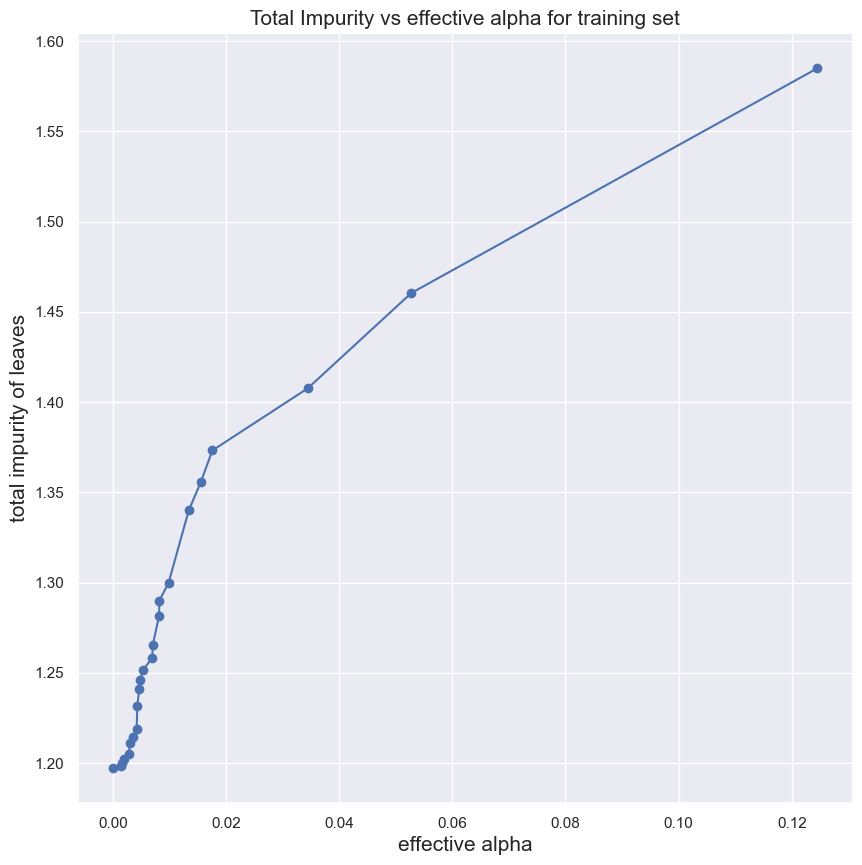

In [417]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas, impurities, marker='o')
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

In [418]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(splitter= 'best', min_samples_split= 724, min_samples_leaf= 256, min_impurity_decrease= 0, max_leaf_nodes= 30, max_features= None, max_depth= 14, criterion= 'entropy', class_weight= None, random_state = 2024, ccp_alpha=ccp_alpha).fit(X_train_multi_copy, y_train_multi)
    trees.append(dt_alpha)

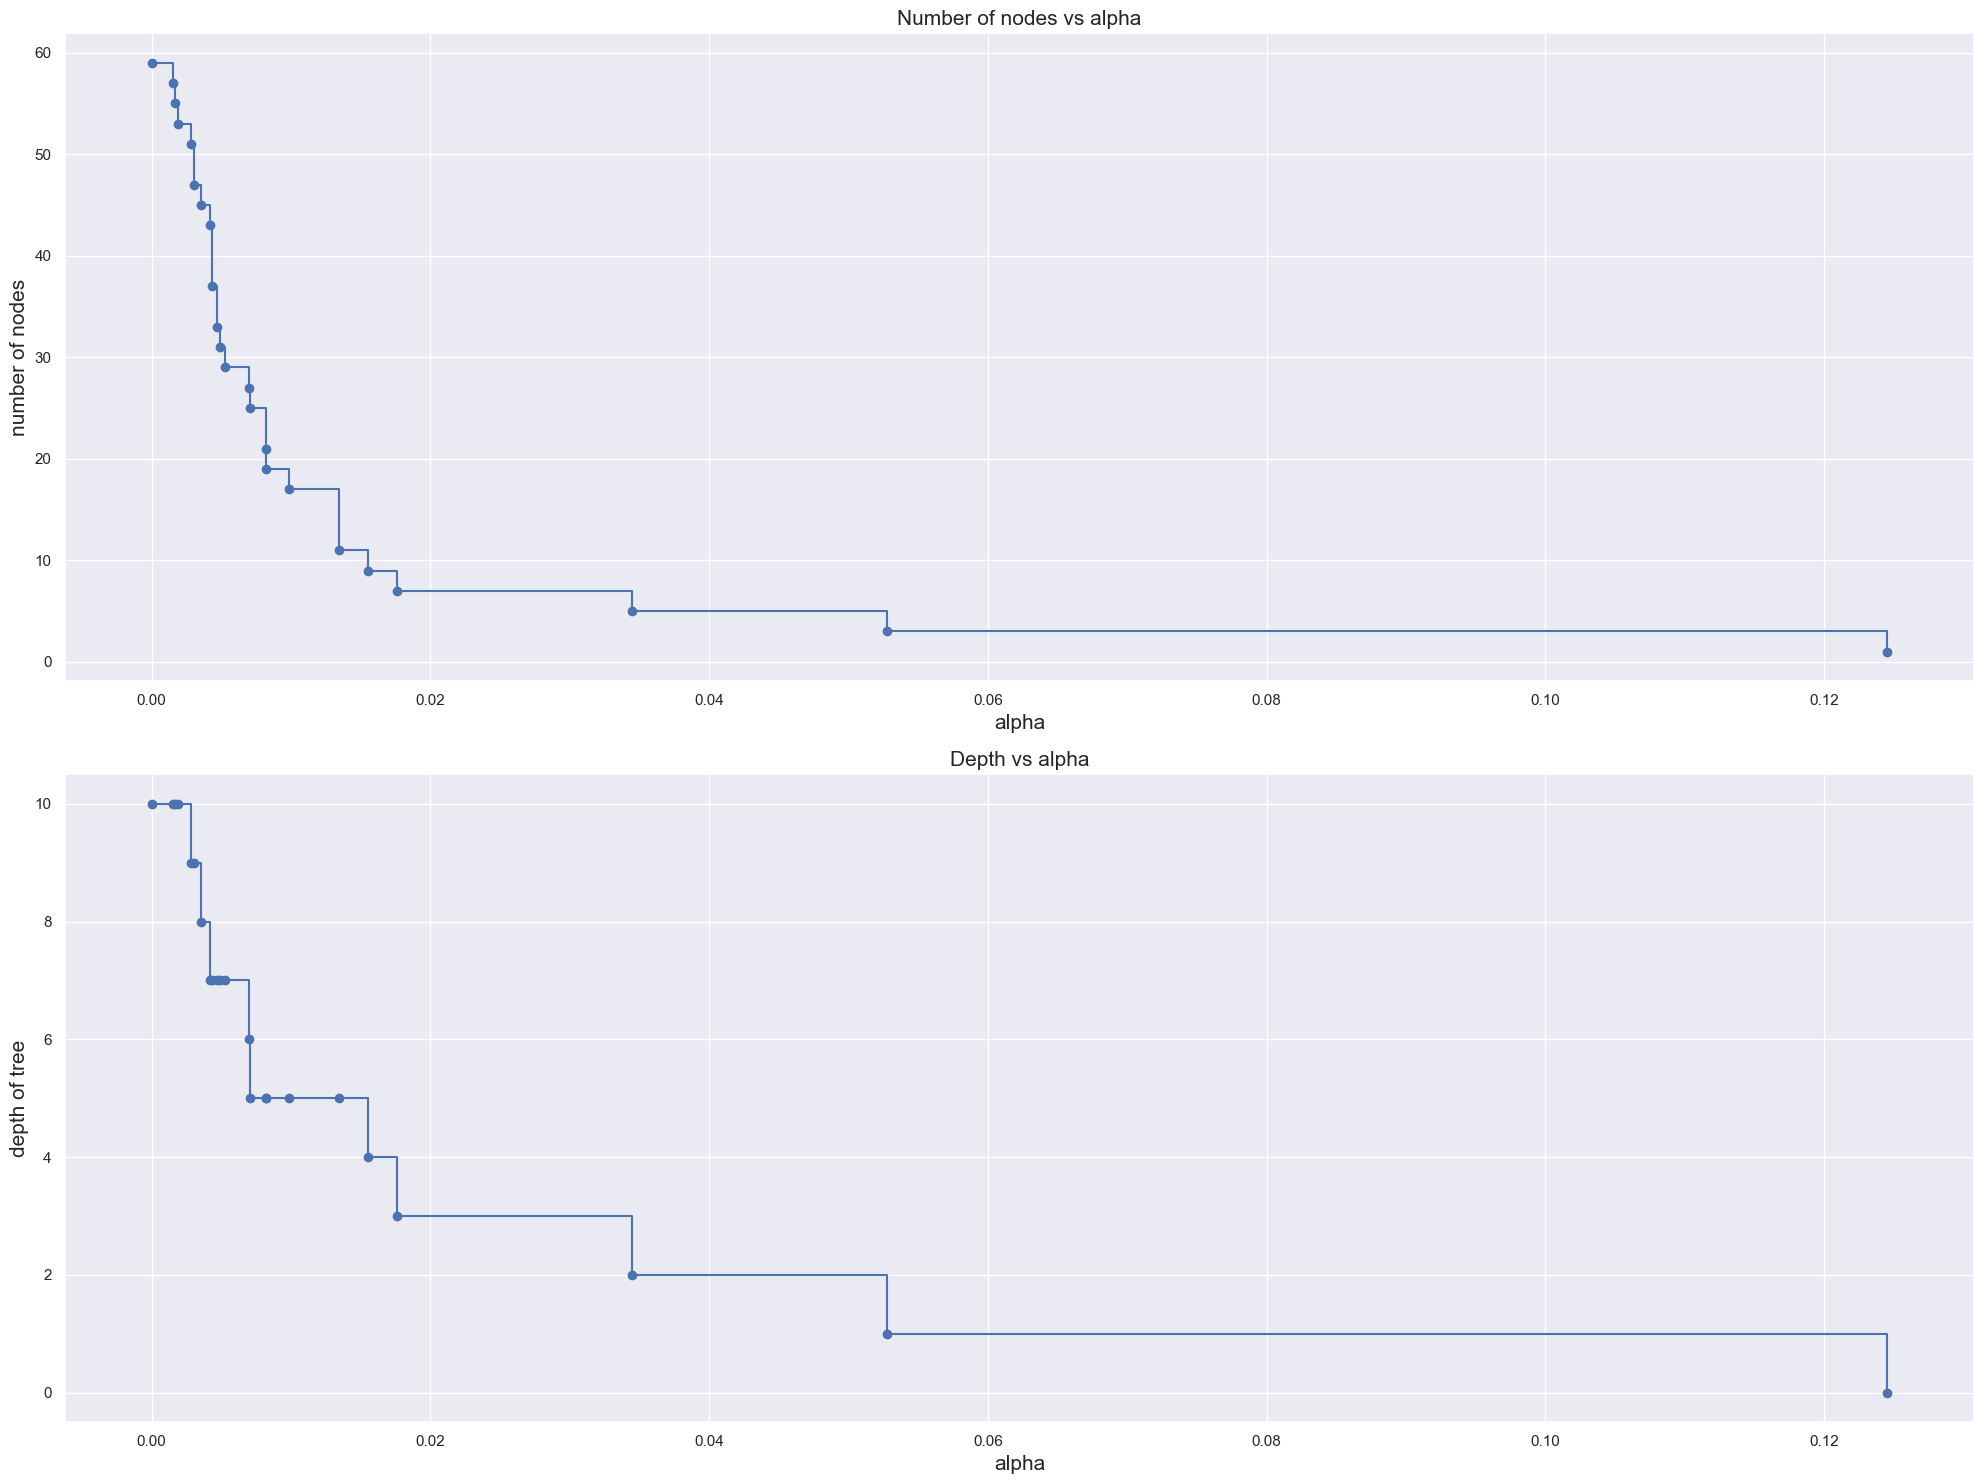

In [419]:
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.get_depth() for tree in trees]

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha", fontsize=15)
ax[0].set_ylabel("number of nodes", fontsize=15)
ax[0].set_title("Number of nodes vs alpha", fontsize=15)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=15)
ax[1].set_ylabel("depth of tree", fontsize=15)
ax[1].set_title("Depth vs alpha", fontsize=15)
fig.tight_layout()

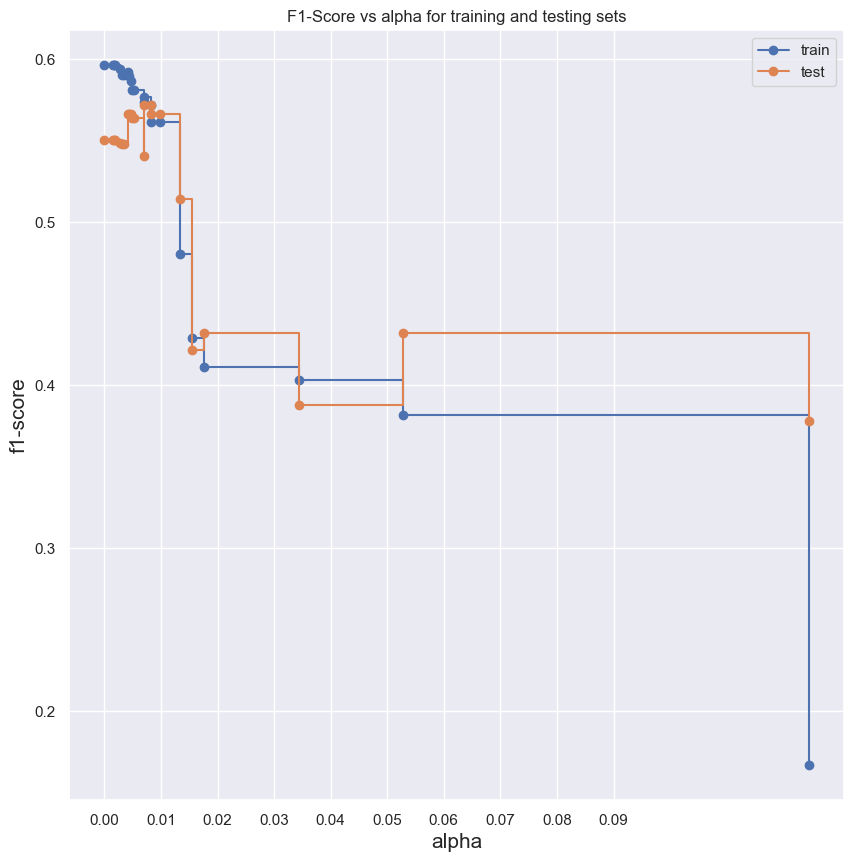

In [420]:
train_f1_scores_multi = [f1_score(y_train_multi, tree.predict(X_train_multi_copy), average = 'weighted') for tree in trees]
val_f1_scores_multi = [f1_score(y_val_multi, tree.predict(X_val_multi_copy), average = 'weighted') for tree in trees]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("f1-score", fontsize=15)
ax.set_title("F1-Score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_f1_scores_multi, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_f1_scores_multi, marker='o', label="test", drawstyle="steps-post")
plt.xticks(np.arange(0,0.1,0.01))
ax.legend()
plt.show()

In [421]:
index_best_model = np.argmax(val_f1_scores_multi)
best_model = trees[index_best_model]
print('ccp_alpha of best model: ',ccp_alphas[index_best_model])
print('_____________________________________________________________')
print('\nTraining f1 score of best model:', f1_score(y_train_multi, best_model.predict(X_train_multi_copy), average='weighted'))
print('Test f1 score of best model:', f1_score(y_val_multi, best_model.predict(X_val_multi_copy), average='weighted'))

ccp_alpha of best model:  0.007053273696359469
_____________________________________________________________

Training f1 score of best model: 0.5767216179948289
Test f1 score of best model: 0.5717573761947748


In [422]:
dtc_model_multi_random = DecisionTreeClassifier(ccp_alpha= ccp_alphas[index_best_model], splitter= 'best', min_samples_split= 724, min_samples_leaf= 256, min_impurity_decrease= 0, max_leaf_nodes= 30, max_features= None, max_depth= 14, criterion= 'entropy', class_weight= None, random_state = 2024)
dtc_model_multi_random.fit(X_train_multi_copy, y_train_multi)

DecisionTreeClassifier(ccp_alpha=0.007053273696359469, criterion='entropy',
                       max_depth=14, max_leaf_nodes=30, min_impurity_decrease=0,
                       min_samples_leaf=256, min_samples_split=724,
                       random_state=2024)

In [423]:
dtc_labels_train_multi_random = dtc_model_multi_random.predict(X_train_multi_copy)
dtc_labels_val_multi_random = dtc_model_multi_random.predict(X_val_multi_copy)

In [424]:
metrics(y_train_multi, dtc_labels_train_multi_random, y_val_multi, dtc_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.63      0.76      0.69     26883
           1       0.65      0.54      0.59     26883
           2       0.46      0.44      0.45     26883

    accuracy                           0.58     80649
   macro avg       0.58      0.58      0.58     80649
weighted avg       0.58      0.58      0.58     80649

[[20562   680  5641]
 [ 4138 14610  8135]
 [ 7968  7190 11725]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.66      0.80      0.72     11522
           1       0.30      0.11      0.16      2385
           2       0.50      0.44      0.47      7464

    accuracy                           0.60     21371
   macro avg       0.49      0.45      0.45     21371
weighted avg       0.57      0.60      0.57     21371

[[9230  167 2125]
 [1021  260 1104]
 [3749  436 

In [425]:
f1_dct_multi_random = f1_score(y_val_multi, dtc_labels_val_multi_random, average = 'weighted')
print(f1_dct_multi_random)

0.5717573761947748


In [426]:
accuracy_DT_multi = accuracy_score(y_val_multi, dtc_labels_val_multi_random)
precision_DT_multi = precision_score(y_val_multi, dtc_labels_val_multi_random, average='weighted')
recall_DT_multi = recall_score(y_val_multi, dtc_labels_val_multi_random, average='weighted')

In [502]:
f1_dct_multi_macro = f1_score(y_val_multi, dtc_labels_val_multi_random, average = 'macro')
precision_DT_macro = precision_score(y_val_multi, dtc_labels_val_multi_random, average='macro')
recall_DT_macro = recall_score(y_val_multi, dtc_labels_val_multi_random, average='macro')

### Gaussian Naïve Bayes

In [427]:
# To ensure that classes with less samples are given a higher weight we used the 'priors' parameter. However, first we must
# normalize our weights so that the sum of all is equal to 1.

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_multi), y=y_train_multi)
normalized_weights = weights/ np.sum(weights)

In [428]:
'''
model_gnb = GaussianNB()

param_dist = {
    'priors': [None, normalized_weights],
    'var_smoothing': np.logspace(0,-9, num=100),
}

random_search_gnb = RandomizedSearchCV(
    model_gnb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=10,
    random_state = 2024
)

random_search_gnb.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_gnb.best_params_)
'''

'\nmodel_gnb = GaussianNB()\n\nparam_dist = {\n    \'priors\': [None, normalized_weights],\n    \'var_smoothing\': np.logspace(0,-9, num=100),\n}\n\nrandom_search_gnb = RandomizedSearchCV(\n    model_gnb,\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring=\'f1_weighted\',\n    cv=10,\n    random_state = 2024\n)\n\nrandom_search_gnb.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_gnb.best_params_)\n'

Best Parameters: {'var_smoothing': 8.111308307896873e-08, 'priors': array([0.33333333, 0.33333333, 0.33333333])}

In [429]:
gnb_model_multi_random = GaussianNB(var_smoothing= 8.111308307896873e-08, priors= normalized_weights)
gnb_model_multi_random.fit(X_train_multi_copy, y_train_multi)

GaussianNB(priors=array([0.33333333, 0.33333333, 0.33333333]),
           var_smoothing=8.111308307896873e-08)

In [430]:
gnb_labels_train_multi_random = gnb_model_multi_random.predict(X_train_multi_copy)
gnb_labels_val_multi_random = gnb_model_multi_random.predict(X_val_multi_copy)

In [431]:
metrics(y_train_multi, gnb_labels_train_multi_random, y_val_multi, gnb_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     26883
           1       0.50      0.50      0.50     26883
           2       0.43      0.42      0.42     26883

    accuracy                           0.51     80649
   macro avg       0.51      0.51      0.51     80649
weighted avg       0.51      0.51      0.51     80649

[[16484  4051  6348]
 [ 5018 13422  8443]
 [ 6606  9117 11160]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.69      0.63      0.66     11522
           1       0.20      0.40      0.27      2385
           2       0.45      0.37      0.41      7464

    accuracy                           0.52     21371
   macro avg       0.45      0.47      0.45     21371
weighted avg       0.55      0.52      0.53     21371

[[7274 1626 2622]
 [ 693  964  728]
 [2562 2119 

In [432]:
f1_gnb_multi_random = f1_score(y_val_multi, gnb_labels_val_multi_random, average = 'weighted')
print(f1_gnb_multi_random)

0.528996357410575


In [433]:
accuracy_gnb_multi = accuracy_score(y_val_multi, gnb_labels_val_multi_random)
precision_gnb_multi = precision_score(y_val_multi, gnb_labels_val_multi_random, average='weighted')
recall_gnb_multi = recall_score(y_val_multi, gnb_labels_val_multi_random, average='weighted')

In [504]:
f1_gnb_multi_macro = f1_score(y_val_multi, gnb_labels_val_multi_random, average = 'macro')
precision_gnb_macro = precision_score(y_val_multi, gnb_labels_val_multi_random, average='macro')
recall_gnb_macro = recall_score(y_val_multi, gnb_labels_val_multi_random, average='macro')

### Bernoulli Naïve Bayes

In [434]:
'''
model_bnb = BernoulliNB()

param_dist = {
    'alpha': [0.1, 0.5, 1.0],  # Add more alpha values or other hyperparameters as needed
    'binarize': [0.0, 0.1, 0.2],  # Example binarize values
    'fit_prior': [True, False],
    'class_prior': [None, normalized_weights, (weights/len(y_train_multi))]
}

random_search_bnb = RandomizedSearchCV(
    model_bnb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=10,
    random_state = 2024
)

random_search_bnb.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_bnb.best_params_)
'''

'\nmodel_bnb = BernoulliNB()\n\nparam_dist = {\n    \'alpha\': [0.1, 0.5, 1.0],  # Add more alpha values or other hyperparameters as needed\n    \'binarize\': [0.0, 0.1, 0.2],  # Example binarize values\n    \'fit_prior\': [True, False],\n    \'class_prior\': [None, normalized_weights, (weights/len(y_train_multi))]\n}\n\nrandom_search_bnb = RandomizedSearchCV(\n    model_bnb,\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring=\'f1_weighted\',\n    cv=10,\n    random_state = 2024\n)\n\nrandom_search_bnb.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_bnb.best_params_)\n'

Best Parameters: {'fit_prior': False, 'class_prior': array([0.33333333, 0.33333333, 0.33333333]), 'binarize': 0.0, 'alpha': 0.1}

In [435]:
bnb_model_multi_random = BernoulliNB(fit_prior= False, class_prior= normalized_weights, binarize= 0.0, alpha= 0.1)
bnb_model_multi_random.fit(X_train_multi_copy, y_train_multi)

BernoulliNB(alpha=0.1, class_prior=array([0.33333333, 0.33333333, 0.33333333]),
            fit_prior=False)

In [436]:
bnb_labels_train_multi_random = bnb_model_multi_random.predict(X_train_multi_copy)
bnb_labels_val_multi_random = bnb_model_multi_random.predict(X_val_multi_copy)

In [437]:
metrics(y_train_multi, bnb_labels_train_multi_random, y_val_multi, bnb_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.61      0.69      0.65     26883
           1       0.51      0.67      0.58     26883
           2       0.46      0.25      0.33     26883

    accuracy                           0.54     80649
   macro avg       0.53      0.54      0.52     80649
weighted avg       0.53      0.54      0.52     80649

[[18624  4689  3570]
 [ 4422 17923  4538]
 [ 7448 12626  6809]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     11522
           1       0.17      0.39      0.24      2385
           2       0.47      0.25      0.33      7464

    accuracy                           0.51     21371
   macro avg       0.44      0.45      0.42     21371
weighted avg       0.55      0.51      0.51     21371

[[8057 1907 1558]
 [ 854  933  598]
 [3009 2576 

In [438]:
f1_bnb_multi_random = f1_score(y_val_multi, bnb_labels_val_multi_random, average = 'weighted')
print(f1_bnb_multi_random)

0.5114415521929921


In [439]:
accuracy_bnb_multi = accuracy_score(y_val_multi, bnb_labels_val_multi_random)
precision_bnb_multi = precision_score(y_val_multi, bnb_labels_val_multi_random, average='weighted')
recall_bnb_multi = recall_score(y_val_multi, bnb_labels_val_multi_random, average='weighted')

In [506]:
f1_bnb_multi_macro = f1_score(y_val_multi, bnb_labels_val_multi_random, average = 'macro')
precision_bnb_macro = precision_score(y_val_multi, bnb_labels_val_multi_random, average='macro')
recall_bnb_macro = recall_score(y_val_multi, bnb_labels_val_multi_random, average='macro')

### Multinomial Naïve Bayes

In [440]:
nb_model_multi = MultinomialNB(class_prior = weights/len(y_train_multi))
nb_model_multi.fit(X_train_multi_copy, y_train_multi)

MultinomialNB(class_prior=array([1.23994098e-05, 1.23994098e-05, 1.23994098e-05]))

In [441]:
nb_labels_train_multi = nb_model_multi.predict(X_train_multi_copy)
nb_labels_val_multi = nb_model_multi.predict(X_val_multi_copy)

In [442]:
metrics(y_train_multi, nb_labels_train_multi, y_val_multi, nb_labels_val_multi)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.50      0.83      0.62     26883
           1       0.49      0.53      0.51     26883
           2       0.51      0.12      0.20     26883

    accuracy                           0.49     80649
   macro avg       0.50      0.49      0.44     80649
weighted avg       0.50      0.49      0.44     80649

[[22281  3836   766]
 [10180 14293  2410]
 [12251 11289  3343]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.63      0.89      0.73     11522
           1       0.21      0.37      0.27      2385
           2       0.63      0.07      0.13      7464

    accuracy                           0.55     21371
   macro avg       0.49      0.44      0.38     21371
weighted avg       0.58      0.55      0.47     21371

[[10233  1134   155]
 [ 1333   887   165]
 [ 480

In [443]:
f1_nb_multi = f1_score(y_val_multi, nb_labels_val_multi, average = 'weighted')
print(f1_nb_multi)

0.4723591661943235


In [444]:
accuracy_mnb_multi = accuracy_score(y_val_multi, nb_labels_val_multi)
precision_mnb_multi = precision_score(y_val_multi, nb_labels_val_multi, average='weighted')
recall_mnb_multi = recall_score(y_val_multi, nb_labels_val_multi, average='weighted')

In [508]:
f1_nb_macro = f1_score(y_val_multi, nb_labels_val_multi, average = 'macro')
precision_mnb_macro = precision_score(y_val_multi, nb_labels_val_multi, average='macro')
recall_mnb_macro = recall_score(y_val_multi, nb_labels_val_multi, average='macro')

### Complement Naive Bayes

In [445]:
cnb_model = ComplementNB(class_prior = weights/len(y_train_multi))
cnb_model.fit(X_train_multi_copy, y_train_multi)

ComplementNB(class_prior=array([1.23994098e-05, 1.23994098e-05, 1.23994098e-05]))

In [446]:
cnb_labels_train = cnb_model.predict(X_train_multi_copy)
cnb_labels_val = cnb_model.predict(X_val_multi_copy)

In [447]:
metrics(y_train_multi, cnb_labels_train, y_val_multi, cnb_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.49      0.83      0.62     26883
           1       0.48      0.58      0.52     26883
           2       0.54      0.05      0.09     26883

    accuracy                           0.49     80649
   macro avg       0.50      0.49      0.41     80649
weighted avg       0.50      0.49      0.41     80649

[[22411  4191   281]
 [10483 15549   851]
 [12588 12988  1307]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.62      0.89      0.73     11522
           1       0.21      0.40      0.28      2385
           2       0.64      0.03      0.05      7464

    accuracy                           0.54     21371
   macro avg       0.49      0.44      0.35     21371
weighted avg       0.58      0.54      0.44     21371

[[10300  1163    59]
 [ 1371   961    53]
 [ 487

In [448]:
f1_cnb = f1_score(y_val_multi, cnb_labels_val, average = 'weighted')
print(f1_cnb)

0.44427497663015475


In [449]:
accuracy_cnb_multi = accuracy_score(y_val_multi, cnb_labels_val)
precision_cnb_multi = precision_score(y_val_multi, cnb_labels_val, average='weighted')
recall_cnb_multi = recall_score(y_val_multi, cnb_labels_val, average='weighted')

In [510]:
f1_cnb_macro = f1_score(y_val_multi, cnb_labels_val, average = 'macro')
precision_cnb_macro = precision_score(y_val_multi, cnb_labels_val, average='macro')
recall_cnb_macro = recall_score(y_val_multi, cnb_labels_val, average='macro')

### Neural Networks

In [450]:
'''
model = MLPClassifier(random_state = 2024)

parameter_space = {
    'hidden_layer_sizes': sp_randint(1, 100),
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': np.logspace(-4, -1.301, 5),
    'learning_rate': ['constant','adaptive', 'invscaling']
}


random_search_nn = RandomizedSearchCV(
    model,
    param_distributions=parameter_space,
    n_iter=30,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
)

random_search_nn.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_nn.best_params_)
'''

'\nmodel = MLPClassifier(random_state = 2024)\n\nparameter_space = {\n    \'hidden_layer_sizes\': sp_randint(1, 100),\n    \'activation\': [\'identity\', \'logistic\', \'tanh\', \'relu\'],\n    \'solver\': [\'sgd\', \'adam\'],\n    \'alpha\': np.logspace(-4, -1.301, 5),\n    \'learning_rate\': [\'constant\',\'adaptive\', \'invscaling\']\n}\n\n\nrandom_search_nn = RandomizedSearchCV(\n    model,\n    param_distributions=parameter_space,\n    n_iter=30,\n    cv=10,\n    scoring=make_scorer(f1_score, average=\'weighted\'),\n)\n\nrandom_search_nn.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_nn.best_params_)\n'

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 79, 'learning_rate': 'constant', 'solver': 'adam'}

In [451]:
nn_model_multi_random = MLPClassifier(activation= 'relu', alpha=0.0001, hidden_layer_sizes= 79, learning_rate= 'constant', solver= 'adam', random_state = 2024)
nn_model_multi_random.fit(X_train_multi_copy, y_train_multi)

MLPClassifier(hidden_layer_sizes=79, random_state=2024)

In [452]:
nn_labels_train_multi_random = nn_model_multi_random.predict(X_train_multi_copy)
nn_labels_val_multi_random = nn_model_multi_random.predict(X_val_multi_copy)

In [453]:
metrics(y_train_multi, nn_labels_train_multi_random, y_val_multi, nn_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.63      0.80      0.71     26883
           1       0.67      0.55      0.61     26883
           2       0.53      0.47      0.50     26883

    accuracy                           0.61     80649
   macro avg       0.61      0.61      0.60     80649
weighted avg       0.61      0.61      0.60     80649

[[21638  1503  3742]
 [ 4338 14805  7740]
 [ 8496  5695 12692]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.66      0.82      0.73     11522
           1       0.22      0.20      0.21      2385
           2       0.55      0.35      0.43      7464

    accuracy                           0.59     21371
   macro avg       0.48      0.46      0.46     21371
weighted avg       0.57      0.59      0.57     21371

[[9496  695 1331]
 [1077  481  827]
 [3888  973 

In [454]:
f1_nn_multi_random = f1_score(y_val_multi, nn_labels_val_multi_random, average = 'weighted')
print(f1_nn_multi_random)

0.5664898953585968


In [455]:
accuracy_nn_multi = accuracy_score(y_val_multi, nn_labels_val_multi_random)
precision_nn_multi = precision_score(y_val_multi, nn_labels_val_multi_random, average='weighted')
recall_nn_multi = recall_score(y_val_multi, nn_labels_val_multi_random, average='weighted')

In [512]:
f1_nn_multi_macro = f1_score(y_val_multi, nn_labels_val_multi_random, average = 'macro')
precision_nn_macro = precision_score(y_val_multi, nn_labels_val_multi_random, average='macro')
recall_nn_macro = recall_score(y_val_multi, nn_labels_val_multi_random, average='macro')

### Support Vector Classifier

In [458]:
'''
model_svm = LinearSVC(random_state = 2024)

parameter_space = {
    'C': uniform(0.1, 10),
    'class_weight': [None, 'balanced'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [False, True, 'auto'],
    'multi_class': ['ovr', 'crammer_singer'],
    'penalty': ['l1', 'l2'],
}

random_search_svm = RandomizedSearchCV(
    model_svm,
    param_distributions=parameter_space,
    n_iter=10,
    cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    random_state = 2024,
)

random_search_svm.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_svm.best_params_)
'''

'\nmodel_svm = LinearSVC(random_state = 2024)\n\nparameter_space = {\n    \'C\': uniform(0.1, 10),\n    \'class_weight\': [None, \'balanced\'],\n    \'loss\': [\'hinge\', \'squared_hinge\'],\n    \'dual\': [False, True, \'auto\'],\n    \'multi_class\': [\'ovr\', \'crammer_singer\'],\n    \'penalty\': [\'l1\', \'l2\'],\n}\n\nrandom_search_svm = RandomizedSearchCV(\n    model_svm,\n    param_distributions=parameter_space,\n    n_iter=10,\n    cv=5,\n    scoring=make_scorer(f1_score, average=\'weighted\'),\n    random_state = 2024,\n)\n\nrandom_search_svm.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_svm.best_params_)\n'

Best Parameters: {'C': 6.894005235251416, 'class_weight': 'balanced', 'dual': False, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}

In [459]:
svm_model_multi_random = LinearSVC(C= 6.894005235251416, class_weight= 'balanced', dual= False, loss= 'squared_hinge', multi_class= 'ovr', penalty= 'l2', random_state = 2024)
svm_model_multi_random.fit(X_train_multi_copy, y_train_multi)

LinearSVC(C=6.894005235251416, class_weight='balanced', dual=False,
          random_state=2024)

In [460]:
svm_labels_train_multi_random = svm_model_multi_random.predict(X_train_multi_copy)
svm_labels_val_multi_random = svm_model_multi_random.predict(X_val_multi_copy)

In [461]:
metrics(y_train_multi, svm_labels_train_multi_random, y_val_multi, svm_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.51      0.83      0.63     26883
           1       0.52      0.42      0.46     26883
           2       0.49      0.28      0.36     26883

    accuracy                           0.51     80649
   macro avg       0.51      0.51      0.48     80649
weighted avg       0.51      0.51      0.48     80649

[[22308  2803  1772]
 [ 9589 11344  5950]
 [11620  7789  7474]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.64      0.88      0.74     11522
           1       0.24      0.34      0.28      2385
           2       0.61      0.17      0.27      7464

    accuracy                           0.57     21371
   macro avg       0.50      0.46      0.43     21371
weighted avg       0.58      0.57      0.52     21371

[[10131   888   503]
 [ 1260   804   321]
 [ 451

In [462]:
f1_svm_multi_random = f1_score(y_val_multi, svm_labels_val_multi_random, average = 'weighted')
print(f1_svm_multi_random)

0.5237474306239766


In [463]:
accuracy_svm_multi = accuracy_score(y_val_multi, svm_labels_val_multi_random)
precision_svm_multi = precision_score(y_val_multi, svm_labels_val_multi_random, average='weighted')
recall_svm_multi = recall_score(y_val_multi, svm_labels_val_multi_random, average='weighted')

In [514]:
f1_svm_multi_macro = f1_score(y_val_multi, svm_labels_val_multi_random, average = 'macro')
precision_svm_macro = precision_score(y_val_multi, svm_labels_val_multi_random, average='macro')
recall_svm_macro = recall_score(y_val_multi, svm_labels_val_multi_random, average='macro')

## Model Results (Before Ensemble)

In [536]:
models_multi = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree Classifier', 'Gaussian Naive Bayes','Bernoulli Naive Bayes',
                                       'Multinomial Naive Bayes', 'Complement Naive Bayes', 'Neural Networks', 'Support Vector Classifier'],

                       'Accuracy Score - validation': [accuracy_logR_multi, accuracy_DT_multi, accuracy_gnb_multi,accuracy_bnb_multi,
                                                       accuracy_mnb_multi, accuracy_cnb_multi, accuracy_nn_multi,accuracy_svm_multi],

                       'Precision Score - validation': [precision_logR_multi, precision_DT_multi, precision_gnb_multi, precision_bnb_multi,
                                                        precision_mnb_multi, precision_cnb_multi, precision_nn_multi, precision_svm_multi],

                       'Recall Score - validation': [recall_logR_multi, recall_DT_multi, recall_gnb_multi, recall_bnb_multi, recall_mnb_multi,
                                                     recall_cnb_multi, recall_nn_multi, recall_svm_multi],

                       'F1 Score - validation': [f1_logR_multi_random, f1_dct_multi_random, f1_gnb_multi_random, f1_bnb_multi_random, f1_nb_multi,
                                                 f1_cnb, f1_nn_multi_random, f1_svm_multi_random]})

models_multi.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
1   Decision Tree Classifier                     0.597492   
6            Neural Networks                     0.588648   
0        Logistic Regression                     0.569791   
2       Gaussian Naive Bayes                     0.515699   
7  Support Vector Classifier                     0.572130   
3      Bernoulli Naive Bayes                     0.508586   
4    Multinomial Naive Bayes                     0.546207   
5     Complement Naive Bayes                     0.536054   

   Precision Score - validation  Recall Score - validation  \
1                      0.565042                   0.597492   
6                      0.569965                   0.588648   
0                      0.575822                   0.569791   
2                      0.553799                   0.515699   
7                      0.583385                   0.572130   
3                      0.546284                   0.508586   
4                      0.582282                   0.546207   
5                      0.581169                   0.536054   

   F1 Score - validation  
1               0.571757  
6               0.566490  
0               0.536025  
2               0.528996  
7               0.523747  
3               0.511442  
4               0.472359  
5               0.444275

## Ensemble Methods

### Random Forest

In [465]:
rdf_model_multi = RandomForestClassifier(random_state = 2024)
rdf_model_multi.fit(X_train_multi_copy, y_train_multi)

RandomForestClassifier(random_state=2024)

In [466]:
'''
param_dist = {
    'n_estimators': sp_randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(sp_randint(1, 20).rvs(10)),
    'min_samples_split': list(sp_randint(2, 1000).rvs(15)),
    'min_samples_leaf': list(sp_randint(1, 500).rvs(15)),
    'class_weight': [None, 'balanced'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
}

random_search_RF = RandomizedSearchCV(
    rdf_model_multi,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    cv=10,
    random_state = 2024
)

random_search_RF.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_RF.best_params_)
'''

'\nparam_dist = {\n    \'n_estimators\': sp_randint(10, 200),\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'max_depth\': [None] + list(sp_randint(1, 20).rvs(10)),\n    \'min_samples_split\': list(sp_randint(2, 1000).rvs(15)),\n    \'min_samples_leaf\': list(sp_randint(1, 500).rvs(15)),\n    \'class_weight\': [None, \'balanced\'],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None],\n    \'bootstrap\': [True, False],\n    \'oob_score\': [True, False],\n}\n\nrandom_search_RF = RandomizedSearchCV(\n    rdf_model_multi,\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring=\'f1_weighted\',\n    cv=10,\n    random_state = 2024\n)\n\nrandom_search_RF.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_RF.best_params_)\n'

Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 225, 'min_samples_split': 46, 'n_estimators': 17, 'oob_score': False}

In [467]:
rdf_model_multi_random = RandomForestClassifier(bootstrap= False, class_weight= 'balanced', criterion= 'gini', max_depth= None, max_features= 'log2', min_samples_leaf= 225, min_samples_split= 46, n_estimators= 17, oob_score= False, random_state = 2024)
rdf_model_multi_random.fit(X_train_multi_copy, y_train_multi)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', min_samples_leaf=225,
                       min_samples_split=46, n_estimators=17,
                       random_state=2024)

In [468]:
rdf_labels_train_multi_random = rdf_model_multi_random.predict(X_train_multi_copy)
rdf_labels_val_multi_random = rdf_model_multi_random.predict(X_val_multi_copy)

In [469]:
metrics(y_train_multi, rdf_labels_train_multi_random, y_val_multi, rdf_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.65      0.83      0.73     26883
           1       0.68      0.70      0.69     26883
           2       0.56      0.39      0.46     26883

    accuracy                           0.64     80649
   macro avg       0.63      0.64      0.63     80649
weighted avg       0.63      0.64      0.63     80649

[[22222   817  3844]
 [ 3564 18952  4367]
 [ 8171  8292 10420]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.65      0.86      0.74     11522
           1       0.24      0.14      0.18      2385
           2       0.56      0.36      0.44      7464

    accuracy                           0.61     21371
   macro avg       0.48      0.45      0.45     21371
weighted avg       0.57      0.61      0.57     21371

[[9941  358 1223]
 [1150  333  902]
 [4099  689 

In [470]:
f1_rdf_multi_random = f1_score(y_val_multi, rdf_labels_val_multi_random, average = 'weighted')
print(f1_rdf_multi_random)

0.5734332828006894


In [471]:
accuracy_rdf_multi = accuracy_score(y_val_multi, rdf_labels_val_multi_random)
precision_rdf_multi = precision_score(y_val_multi, rdf_labels_val_multi_random, average='weighted')
recall_rdf_multi = recall_score(y_val_multi, rdf_labels_val_multi_random, average='weighted')

In [517]:
f1_rdf_multi_macro = f1_score(y_val_multi, rdf_labels_val_multi_random, average = 'macro')
precision_rdf_macro = precision_score(y_val_multi, rdf_labels_val_multi_random, average='macro')
recall_rdf_macro = recall_score(y_val_multi, rdf_labels_val_multi_random, average='macro')

### AdaBoost

Let's quickly determine the best number for 'n_estimators' and for the 'learning_rate'

In [472]:
'''
model_adab = AdaBoostClassifier()

parameter_space = {
    'n_estimators': sp_randint(50, 200),
    'learning_rate': [0.1, 0.5, 1.0]
}

random_search_adab = RandomizedSearchCV(
    model_adab,
    param_distributions=parameter_space,
    n_iter=10,
    cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    random_state=2024
)

random_search_adab.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_adab.best_params_)
'''

'\nmodel_adab = AdaBoostClassifier()\n\nparameter_space = {\n    \'n_estimators\': sp_randint(50, 200),\n    \'learning_rate\': [0.1, 0.5, 1.0]\n}\n\nrandom_search_adab = RandomizedSearchCV(\n    model_adab,\n    param_distributions=parameter_space,\n    n_iter=10,\n    cv=5,\n    scoring=make_scorer(f1_score, average=\'weighted\'),\n    random_state=2024\n)\n\nrandom_search_adab.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_adab.best_params_)\n'

Best Parameters: {'learning_rate': 1.0, 'n_estimators': 164}

In [473]:
adaboost_dt_multi = AdaBoostClassifier(estimator= dtc_model_multi_random, learning_rate=1.0, n_estimators= 164, random_state= 2024)
adaboost_dt_multi.fit(X_train_multi_copy, y_train_multi)

AdaBoostClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.007053273696359469,
                                                    criterion='entropy',
                                                    max_depth=14,
                                                    max_leaf_nodes=30,
                                                    min_impurity_decrease=0,
                                                    min_samples_leaf=256,
                                                    min_samples_split=724,
                                                    random_state=2024),
                   n_estimators=164, random_state=2024)

In [474]:
adaboost_dt_labels_train_multi = adaboost_dt_multi.predict(X_train_multi_copy)
adaboost_dt_labels_val_multi = adaboost_dt_multi.predict(X_val_multi_copy)

In [475]:
metrics(y_train_multi, adaboost_dt_labels_train_multi, y_val_multi, adaboost_dt_labels_val_multi)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.68      0.85      0.75     26883
           1       0.68      0.72      0.70     26883
           2       0.53      0.36      0.43     26883

    accuracy                           0.64     80649
   macro avg       0.63      0.64      0.63     80649
weighted avg       0.63      0.64      0.63     80649

[[22764   243  3876]
 [ 2763 19344  4776]
 [ 8188  8904  9791]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.64      0.89      0.74     11522
           1       0.27      0.04      0.07      2385
           2       0.55      0.36      0.44      7464

    accuracy                           0.61     21371
   macro avg       0.49      0.43      0.42     21371
weighted avg       0.57      0.61      0.56     21371

[[10280    67  1175]
 [ 1287    90  1008]
 [ 458

In [476]:
f1_adaboost_dt_multi = f1_score(y_val_multi, adaboost_dt_labels_val_multi, average = 'weighted')
print(f1_adaboost_dt_multi)

0.560738048889626


In [477]:
accuracy_adabDT_multi = accuracy_score(y_val_multi, adaboost_dt_labels_val_multi)
precision_adabDT_multi = precision_score(y_val_multi, adaboost_dt_labels_val_multi, average='weighted')
recall_adabDT_multi = recall_score(y_val_multi, adaboost_dt_labels_val_multi, average='weighted')

In [519]:
f1_adaboost_dt_macro = f1_score(y_val_multi, adaboost_dt_labels_val_multi, average = 'macro')
precision_adabDT_macro = precision_score(y_val_multi, adaboost_dt_labels_val_multi, average='macro')
recall_adabDT_macro = recall_score(y_val_multi, adaboost_dt_labels_val_multi, average='macro')

### Bagging

In [478]:
'''
model_bag = BaggingClassifier(estimator= nn_model_multi_random, random_state= 2024)

parameter_space = {
    'n_estimators': sp_randint(50, 200),
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score' : [True, False],
}

random_search_bag = RandomizedSearchCV(
    model_bag,
    param_distributions=parameter_space,
    n_iter=10,
    cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    random_state= 2024
)

random_search_bag.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_bag.best_params_)
'''

'\nmodel_bag = BaggingClassifier(estimator= nn_model_multi_random, random_state= 2024)\n\nparameter_space = {\n    \'n_estimators\': sp_randint(50, 200),\n    \'max_samples\': [0.5, 0.7, 0.9, 1.0],\n    \'max_features\': [0.5, 0.7, 0.9, 1.0],\n    \'bootstrap\': [True, False],\n    \'bootstrap_features\': [True, False],\n    \'oob_score\' : [True, False],\n}\n\nrandom_search_bag = RandomizedSearchCV(\n    model_bag,\n    param_distributions=parameter_space,\n    n_iter=10,\n    cv=5,\n    scoring=make_scorer(f1_score, average=\'weighted\'),\n    random_state= 2024\n)\n\nrandom_search_bag.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_bag.best_params_)\n'

Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 110, 'oob_score': False}

In [479]:
bag_nn_multi = BaggingClassifier(estimator = nn_model_multi_random, bootstrap= True, bootstrap_features= False, max_features= 0.7, max_samples= 1.0, n_estimators= 110, oob_score= False, random_state= 2024)
bag_nn_multi.fit(X_train_multi_copy, y_train_multi)

BaggingClassifier(estimator=MLPClassifier(hidden_layer_sizes=79,
                                          random_state=2024),
                  max_features=0.7, n_estimators=110, random_state=2024)

In [480]:
bag_nn_multi_labels_train_multi = bag_nn_multi.predict(X_train_multi_copy)
bag_nn_multi_labels_val_multi = bag_nn_multi.predict(X_val_multi_copy)

In [481]:
metrics(y_train_multi, bag_nn_multi_labels_train_multi, y_val_multi, bag_nn_multi_labels_val_multi)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     26883
           1       0.65      0.69      0.67     26883
           2       0.56      0.43      0.49     26883

    accuracy                           0.63     80649
   macro avg       0.62      0.63      0.62     80649
weighted avg       0.62      0.63      0.62     80649

[[20811  1863  4209]
 [ 3327 18458  5098]
 [ 7233  8031 11619]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.68      0.79      0.73     11522
           1       0.24      0.26      0.25      2385
           2       0.54      0.39      0.45      7464

    accuracy                           0.59     21371
   macro avg       0.49      0.48      0.48     21371
weighted avg       0.58      0.59      0.58     21371

[[9108  814 1600]
 [ 946  622  817]
 [3395 1185 

In [482]:
f1_bag_nn_multi = f1_score(y_val_multi, bag_nn_multi_labels_val_multi, average = 'weighted')
print(f1_bag_nn_multi)

0.578845352198923


In [483]:
accuracy_bag_nn_multi = accuracy_score(y_val_multi, bag_nn_multi_labels_val_multi)
precision_bag_nn_multi = precision_score(y_val_multi, bag_nn_multi_labels_val_multi, average='weighted')
recall_bag_nn_multi = recall_score(y_val_multi, bag_nn_multi_labels_val_multi, average='weighted')

In [521]:
f1_bag_nn_macro = f1_score(y_val_multi, bag_nn_multi_labels_val_multi, average = 'macro')
precision_bag_nn_macro = precision_score(y_val_multi, bag_nn_multi_labels_val_multi, average='macro')
recall_bag_nn_macro= recall_score(y_val_multi, bag_nn_multi_labels_val_multi, average='macro')

### Gradient Boosting

In [484]:
gb_model_multi = HistGradientBoostingClassifier(random_state= 2024)
gb_model_multi.fit(X_train_multi_copy, y_train_multi)

HistGradientBoostingClassifier(random_state=2024)

In [485]:
'''
param_grid = {
    'learning_rate': list(uniform(0.01, 0.5).rvs(10)),
    'max_depth': list(randint(3, 10).rvs(10)),
    'max_leaf_nodes': [None] + list(randint(10, 50).rvs(10)),
    'min_samples_leaf': list(randint(1, 10).rvs(10)),
    'l2_regularization': list(uniform(0, 1).rvs(10))
}

random_search_gb = RandomizedSearchCV(
    gb_model_multi,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    random_state= 2024
)

random_search_gb.fit(X_train_multi_copy, y_train_multi)

print("Best Parameters: ", random_search_gb.best_params_)
'''

'\nparam_grid = {\n    \'learning_rate\': list(uniform(0.01, 0.5).rvs(10)),\n    \'max_depth\': list(randint(3, 10).rvs(10)),\n    \'max_leaf_nodes\': [None] + list(randint(10, 50).rvs(10)),\n    \'min_samples_leaf\': list(randint(1, 10).rvs(10)),\n    \'l2_regularization\': list(uniform(0, 1).rvs(10))\n}\n\nrandom_search_gb = RandomizedSearchCV(\n    gb_model_multi,\n    param_distributions=param_grid,\n    n_iter=10,\n    cv=5,\n    scoring=make_scorer(f1_score, average=\'weighted\'),\n    random_state= 2024\n)\n\nrandom_search_gb.fit(X_train_multi_copy, y_train_multi)\n\nprint("Best Parameters: ", random_search_gb.best_params_)\n'

Best Parameters:  {'min_samples_leaf': 5, 'max_leaf_nodes': 36, 'max_depth': 9, 'learning_rate': 0.3128699301868304, 'l2_regularization': 0.3900124038695685}

In [486]:
gb_nn_model_multi_random = HistGradientBoostingClassifier(min_samples_leaf= 5, max_leaf_nodes= 36, max_depth= 9, learning_rate= 0.3128699301868304, l2_regularization= 0.3900124038695685, random_state= 2024)
gb_nn_model_multi_random.fit(X_train_multi_copy, y_train_multi)

HistGradientBoostingClassifier(l2_regularization=0.3900124038695685,
                               learning_rate=0.3128699301868304, max_depth=9,
                               max_leaf_nodes=36, min_samples_leaf=5,
                               random_state=2024)

In [487]:
gb_nn_labels_train_multi_random = gb_nn_model_multi_random.predict(X_train_multi_copy)
gb_nn_labels_val_multi_random = gb_nn_model_multi_random.predict(X_val_multi_copy)

In [488]:
metrics(y_train_multi, gb_nn_labels_train_multi_random, y_val_multi, gb_nn_labels_val_multi_random)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.76      0.91      0.83     26883
           1       0.84      0.82      0.83     26883
           2       0.76      0.63      0.69     26883

    accuracy                           0.79     80649
   macro avg       0.79      0.79      0.78     80649
weighted avg       0.79      0.79      0.78     80649

[[24401   122  2360]
 [ 1801 22027  3055]
 [ 5929  4021 16933]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.64      0.88      0.74     11522
           1       0.31      0.07      0.11      2385
           2       0.56      0.39      0.46      7464

    accuracy                           0.61     21371
   macro avg       0.50      0.44      0.44     21371
weighted avg       0.58      0.61      0.57     21371

[[10086   111  1325]
 [ 1253   157   975]
 [ 434

In [489]:
f1_gb_nn_multi_random = f1_score(y_val_multi, gb_nn_labels_val_multi_random, average = 'weighted')
print(f1_gb_nn_multi_random)

0.5708412007896821


In [490]:
accuracy_gb_nn_multi = accuracy_score(y_val_multi, gb_nn_labels_val_multi_random)
precision_gb_nn_multi = precision_score(y_val_multi, gb_nn_labels_val_multi_random, average='weighted')
recall_gb_nn_multi = recall_score(y_val_multi, gb_nn_labels_val_multi_random, average='weighted')

In [523]:
f1_gb_nn_multi_macro = f1_score(y_val_multi, gb_nn_labels_val_multi_random, average = 'macro')
precision_gb_nn_macro = precision_score(y_val_multi, gb_nn_labels_val_multi_random, average='macro')
recall_gb_nn_macro = recall_score(y_val_multi, gb_nn_labels_val_multi_random, average='macro')

### Stacking Classifier

In [493]:
estimators = [('Random Forest', rdf_model_multi_random), ('Bagging', BaggingClassifier(estimator = nn_model_multi_random, random_state = 2024)), ('Neural Networks', nn_model_multi_random),
 ('Gaussian Naïve Bayes', gnb_model_multi_random), ('Decision Tree', dtc_model_multi_random)]
final_estimator = logR_model_multi

In [494]:
stacking_model_multi = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
stacking_model_multi.fit(X_train_multi_copy, y_train_multi)

StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       max_features='log2',
                                                       min_samples_leaf=225,
                                                       min_samples_split=46,
                                                       n_estimators=17,
                                                       random_state=2024)),
                               ('Bagging',
                                BaggingClassifier(estimator=MLPClassifier(hidden_layer_sizes=79,
                                                                          random_state=2024),
                                                  random_state=2024)),
                               ('Neural Networks',
                                MLPClassif...
                                GaussianNB(priors=array([0.33333333, 0.33333333, 0.33333333]),
                                           var_smoothing=8.111308307896873e-08)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.007053273696359469,
                                                       criterion='entropy',
                                                       max_depth=14,
                                                       max_leaf_nodes=30,
                                                       min_impurity_decrease=0,
                                                       min_samples_leaf=256,
                                                       min_samples_split=724,
                                                       random_state=2024))],
                   final_estimator=LogisticRegression(multi_class='multinomial',
                                                      random_state=2024))

In [495]:
stacking_model_multi_labels_train = stacking_model_multi.predict(X_train_multi_copy)
stacking_model_multi_labels_val = stacking_model_multi.predict(X_val_multi_copy)

In [496]:
metrics(y_train_multi, stacking_model_multi_labels_train, y_val_multi, stacking_model_multi_labels_val)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.69      0.81      0.74     26883
           1       0.68      0.70      0.69     26883
           2       0.55      0.44      0.49     26883

    accuracy                           0.65     80649
   macro avg       0.64      0.65      0.64     80649
weighted avg       0.64      0.65      0.64     80649

[[21738  1001  4144]
 [ 2574 18785  5524]
 [ 7377  7759 11747]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.66      0.83      0.74     11522
           1       0.27      0.19      0.22      2385
           2       0.53      0.38      0.44      7464

    accuracy                           0.60     21371
   macro avg       0.49      0.47      0.47     21371
weighted avg       0.57      0.60      0.58     21371

[[9591  355 1576]
 [1027  451  907]
 [3823  840 

In [497]:
f1_stacking_model_multi = f1_score(y_val_multi, stacking_model_multi_labels_val, average = 'weighted')
print(f1_stacking_model_multi)

0.5767799342276712


In [498]:
accuracy_stack1_multi = accuracy_score(y_val_multi, stacking_model_multi_labels_val)
precision_stack1_multi = precision_score(y_val_multi, stacking_model_multi_labels_val, average='weighted')
recall_stack1_multi = recall_score(y_val_multi, stacking_model_multi_labels_val, average='weighted')

In [525]:
f1_stacking_model_macro = f1_score(y_val_multi, stacking_model_multi_labels_val, average = 'macro')
precision_stack1_macro = precision_score(y_val_multi, stacking_model_multi_labels_val, average='macro')
recall_stack1_macro = recall_score(y_val_multi, stacking_model_multi_labels_val, average='macro')

### Voting

In [526]:
voting_f1_scores_multi = [f1_dct_multi_random, f1_rdf_multi_random, f1_bag_nn_multi, f1_gb_nn_multi_random, f1_stacking_model_multi]

sum_f1_scores_multi = sum(voting_f1_scores_multi)
avg_f1_score_multi = sum_f1_scores_multi / len(voting_f1_scores_multi)

weights_multi = []
for i in voting_f1_scores_multi:
    added_weight = i - avg_f1_score_multi
    weight = 1 + 50 * added_weight
    weights_multi.append(weight)

weights_multi

[0.8712973476213406,
 0.9550926779170679,
 1.2256961478287467,
 0.8254885773667056,
 1.122425249266156]

In [527]:
estimators_voting = [('Decision Tree', dtc_model_multi_random), ('Random Forest', rdf_model_multi_random), ('Bagging', bag_nn_multi), ('Gradient Boosting', gb_nn_model_multi_random), ('Stacking', stacking_model_multi)]
voting_model_multi = VotingClassifier(estimators = estimators_voting, weights = weights_multi, voting = "hard")
voting_model_multi.fit(X_train_multi_copy, y_train_multi)

VotingClassifier(estimators=[('Decision Tree',
                              DecisionTreeClassifier(ccp_alpha=0.007053273696359469,
                                                     criterion='entropy',
                                                     max_depth=14,
                                                     max_leaf_nodes=30,
                                                     min_impurity_decrease=0,
                                                     min_samples_leaf=256,
                                                     min_samples_split=724,
                                                     random_state=2024)),
                             ('Random Forest',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     max_features='log2',
                                                     min_samples_le...
                                                              DecisionTreeClassifier(ccp_alpha=0.007053273696359469,
                                                                                     criterion='entropy',
                                                                                     max_depth=14,
                                                                                     max_leaf_nodes=30,
                                                                                     min_impurity_decrease=0,
                                                                                     min_samples_leaf=256,
                                                                                     min_samples_split=724,
                                                                                     random_state=2024))],
                                                 final_estimator=LogisticRegression(multi_class='multinomial',
                                                                                    random_state=2024)))],
                 weights=[0.8712973476213406, 0.9550926779170679,
                          1.2256961478287467, 0.8254885773667056,
                          1.122425249266156])

In [528]:
voting_labels_train_multi = voting_model_multi.predict(X_train_multi_copy)
voting_labels_val_multi = voting_model_multi.predict(X_val_multi_copy)

In [529]:
metrics(y_train_multi, voting_labels_train_multi, y_val_multi, voting_labels_val_multi)

            TRAINING SCORES              
              precision    recall  f1-score   support

           0       0.67      0.83      0.74     26883
           1       0.72      0.73      0.73     26883
           2       0.61      0.46      0.52     26883

    accuracy                           0.67     80649
   macro avg       0.67      0.67      0.66     80649
weighted avg       0.67      0.67      0.66     80649

[[22206   791  3886]
 [ 3083 19746  4054]
 [ 7673  6898 12312]]
_________________________________________
            VALIDATION SCORES            
              precision    recall  f1-score   support

           0       0.66      0.85      0.74     11522
           1       0.28      0.14      0.18      2385
           2       0.56      0.40      0.46      7464

    accuracy                           0.61     21371
   macro avg       0.50      0.46      0.46     21371
weighted avg       0.58      0.61      0.58     21371

[[9834  285 1403]
 [1102  328  955]
 [3946  553 

In [530]:
f1_voting_multi = f1_score(y_val_multi, voting_labels_val_multi, average = 'weighted')
print(f1_voting_multi)

0.5841857378900582


In [532]:
accuracy_voting_multi = accuracy_score(y_val_multi, voting_labels_val_multi)
precision_voting_multi = precision_score(y_val_multi, voting_labels_val_multi, average='weighted')
recall_voting_multi = recall_score(y_val_multi, voting_labels_val_multi, average='weighted')

In [533]:
f1_voting_macro = f1_score(y_val_multi, voting_labels_val_multi, average = 'macro')
precision_voting_macro = precision_score(y_val_multi, voting_labels_val_multi, average='macro')
recall_voting_macro = recall_score(y_val_multi, voting_labels_val_multi, average='macro')

## Model Results (After Ensemble)

### Weighted Metrics

In [534]:
models3_multi = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree Classifier', 'Gaussian Naive Bayes','Bernoulli Naive Bayes',
                                       'Multinomial Naive Bayes', 'Complement Naive Bayes', 'Neural Networks', 'Linear SVC',
                                       'Random Forest', 'AdaBoost','Bagging', 'Gradient Boosting', 'Stacking Classifier', 'Voting'],

                       'Accuracy Score - validation': [accuracy_logR_multi, accuracy_DT_multi, accuracy_gnb_multi,accuracy_bnb_multi,
                                                       accuracy_mnb_multi, accuracy_cnb_multi, accuracy_nn_multi,accuracy_svm_multi,
                                                       accuracy_rdf_multi, accuracy_adabDT_multi, accuracy_bag_nn_multi,accuracy_gb_nn_multi,
                                                       accuracy_stack1_multi, accuracy_voting_multi],

                       'Precision Score - validation': [precision_logR_multi, precision_DT_multi, precision_gnb_multi, precision_bnb_multi,
                                                        precision_mnb_multi, precision_cnb_multi, precision_nn_multi, precision_svm_multi,
                                                        precision_rdf_multi, precision_adabDT_multi, precision_bag_nn_multi, precision_gb_nn_multi,
                                                        precision_stack1_multi, precision_voting_multi],

                       'Recall Score - validation': [recall_logR_multi, recall_DT_multi, recall_gnb_multi, recall_bnb_multi, recall_mnb_multi,
                                                     recall_cnb_multi, recall_nn_multi, recall_svm_multi, recall_rdf_multi, recall_adabDT_multi,
                                                     recall_bag_nn_multi, recall_gb_nn_multi, recall_stack1_multi, recall_voting_multi],

                       'F1 Score - validation': [f1_logR_multi_random, f1_dct_multi_random, f1_gnb_multi_random, f1_bnb_multi_random, f1_nb_multi,
                                                 f1_cnb, f1_nn_multi_random, f1_svm_multi_random, f1_rdf_multi_random, f1_adaboost_dt_multi,
                                                 f1_bag_nn_multi, f1_gb_nn_multi_random, f1_stacking_model_multi, f1_voting_multi]})

models3_multi.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
13                    Voting                     0.614244   
10                   Bagging                     0.590239   
12       Stacking Classifier                     0.600955   
8              Random Forest                     0.605961   
1   Decision Tree Classifier                     0.597492   
11         Gradient Boosting                     0.613916   
6            Neural Networks                     0.588648   
9                   AdaBoost                     0.611670   
0        Logistic Regression                     0.569791   
2       Gaussian Naive Bayes                     0.515699   
7                 Linear SVC                     0.572130   
3      Bernoulli Naive Bayes                     0.508586   
4    Multinomial Naive Bayes                     0.546207   
5     Complement Naive Bayes                     0.536054   

    Precision Score - validation  Recall Score - validation  \
13                      0.582200                   0.614244   
10                      0.581618                   0.590239   
12                      0.573788                   0.600955   
8                       0.574438                   0.605961   
1                       0.565042                   0.597492   
11                      0.575112                   0.613916   
6                       0.569965                   0.588648   
9                       0.566602                   0.611670   
0                       0.575822                   0.569791   
2                       0.553799                   0.515699   
7                       0.583385                   0.572130   
3                       0.546284                   0.508586   
4                       0.582282                   0.546207   
5                       0.581169                   0.536054   

    F1 Score - validation  
13               0.584186  
10               0.578845  
12               0.576780  
8                0.573433  
1                0.571757  
11               0.570841  
6                0.566490  
9                0.560738  
0                0.536025  
2                0.528996  
7                0.523747  
3                0.511442  
4                0.472359  
5                0.444275

### Macro Metrics

In [535]:
models4_multi = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree Classifier', 'Gaussian Naive Bayes','Bernoulli Naive Bayes',
                                       'Multinomial Naive Bayes', 'Complement Naive Bayes', 'Neural Networks', 'Linear SVC',
                                       'Random Forest', 'AdaBoost','Bagging', 'Gradient Boosting', 'Stacking Classifier', 'Voting'],

                       'Accuracy Score - validation': [accuracy_logR_multi, accuracy_DT_multi, accuracy_gnb_multi,accuracy_bnb_multi,
                                                       accuracy_mnb_multi, accuracy_cnb_multi, accuracy_nn_multi,accuracy_svm_multi,
                                                       accuracy_rdf_multi, accuracy_adabDT_multi, accuracy_bag_nn_multi,accuracy_gb_nn_multi,
                                                       accuracy_stack1_multi, accuracy_voting_multi],

                       'Precision Score - validation': [precision_logR_macro, precision_DT_macro, precision_gnb_macro, precision_bnb_macro,
                                                        precision_mnb_macro, precision_cnb_macro, precision_nn_macro, precision_svm_macro,
                                                        precision_rdf_macro, precision_adabDT_macro, precision_bag_nn_macro, precision_gb_nn_macro,
                                                        precision_stack1_macro, precision_voting_macro],

                       'Recall Score - validation': [recall_logR_macro, recall_DT_macro, recall_gnb_macro, recall_bnb_macro, recall_mnb_macro,
                                                     recall_cnb_macro, recall_nn_macro, recall_svm_macro, recall_rdf_macro, recall_adabDT_macro,
                                                     recall_bag_nn_macro, recall_gb_nn_macro, recall_stack1_macro, recall_voting_macro],

                       'F1 Score - validation': [f1_logR_multi_macro, f1_dct_multi_macro, f1_gnb_multi_macro, f1_bnb_multi_macro, f1_nb_macro,
                                                 f1_cnb, f1_nn_multi_macro, f1_svm_multi_macro, f1_rdf_multi_macro, f1_adaboost_dt_macro,
                                                 f1_bag_nn_macro, f1_gb_nn_multi_macro, f1_stacking_model_macro, f1_voting_macro]})

models4_multi.sort_values(by='F1 Score - validation', ascending=False)

Model  Accuracy Score - validation  \
10                   Bagging                     0.590239   
12       Stacking Classifier                     0.600955   
13                    Voting                     0.614244   
6            Neural Networks                     0.588648   
8              Random Forest                     0.605961   
1   Decision Tree Classifier                     0.597492   
2       Gaussian Naive Bayes                     0.515699   
5     Complement Naive Bayes                     0.536054   
0        Logistic Regression                     0.569791   
11         Gradient Boosting                     0.613916   
7                 Linear SVC                     0.572130   
3      Bernoulli Naive Bayes                     0.508586   
9                   AdaBoost                     0.611670   
4    Multinomial Naive Bayes                     0.546207   

    Precision Score - validation  Recall Score - validation  \
10                      0.486196                   0.479224   
12                      0.489413                   0.465591   
13                      0.499706                   0.462755   
6                       0.475741                   0.458193   
8                       0.484377                   0.453643   
1                       0.488134                   0.449800   
2                       0.449781                   0.469454   
5                       0.490137                   0.441001   
0                       0.485623                   0.469644   
11                      0.502028                   0.442216   
7                       0.495905                   0.463160   
3                       0.437955                   0.447403   
9                       0.487120                   0.430649   
4                       0.491129                   0.444708   

    F1 Score - validation  
10               0.476616  
12               0.467343  
13               0.464459  
6                0.456321  
8                0.452522  
1                0.450921  
2                0.446959  
5                0.444275  
0                0.442425  
11               0.435031  
7                0.429661  
3                0.417803  
9                0.415578  
4                0.379584

## <font color='#238278'>Final Model</font> <a class="anchor" id="finalmulti"></a>
[Back to Contents](#toc)

#### Final Model for Multiclass Classification

In this final stage, we used our best model, i.e., voting, to make predictions on our test dataset, the same way we did for the binary classification.

In [542]:
voting_model_multi_test = voting_model_multi.predict(test_multi_copy)
voting_model_multi_test_list = voting_model_multi_test.tolist()
voting_model_multi_test_list = ['No' if x == 0 else '<30 days' if x == 1 else '>30 days' if x == 2 else x for x in voting_model_multi_test_list]

submission = pd.read_csv("sample_submission.csv", index_col = "encounter_id")
submission["readmitted_multiclass"] = voting_model_multi_test_list
submission.to_csv("submissions/Group14_VersionFinalMulticlass.csv", index = "encounter_id")